In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

imagename  pen_pressure  letter_spacing  size  dimension  \
0  0968c_num1.png             2               2     2          1   
1  0809c_num2.png             2               2     2          2   
2  0237b_num6.png             2               2     2          2   
3  0069b_num2.png             2               2     2          1   
4  0966c_num4.png             2               2     2          2   

   is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0             2              2          3     2               1           2   
1             2              2          3     1               1           2   
2             2              2          2     2               1           2   
3             2              2          1     1               1           1   
4             2              2          2     1               1           2   

   formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0            2           3              2               2          1  
1            2           3              1               2          2  
2            2           2              2               2          2  
3            1           1              1               1          1  
4            2           2              2               2          2

(13570, 16)

13798

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

imagename  pen_pressure  letter_spacing  size  dimension  \
0   0968c_num1.png             2               2     2          1   
1   0809c_num2.png             2               2     2          2   
2   0237b_num6.png             2               2     2          2   
3   0069b_num2.png             2               2     2          1   
4   0966c_num4.png             2               2     2          2   
5   1316a_num2.png             2               2     1          1   
6   1503c_num2.png             2               1     2          2   
7   0113c_num1.png             2               3     2          2   
8   0221a_num6.png             2               2     2          2   
9   0068a_num4.png             1               1     2          2   
10  1094b_num1.png             2               3     1          1   
11  0337c_num6.png             2               2     2          2   
12  0837a_num4.png             2               2     2          2   
13  0941b_num3.png             2               2     2          2   
14  0260a_num3.png             2               2     2          2   
15  0598c_num4.png             1               3     2          2   
16  0380a_num2.png             2               2     2          2   
17  0384b_num2.png             2               2     2          2   
18  1224a_num3.png             2               2     2          2   
19  1131b_num3.png             2               2     2          2   

    is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0              2              2          3     2               1           2   
1              2              2          3     1               1           2   
2              2              2          2     2               1           2   
3              2              2          1     1               1           1   
4              2              2          2     1               1           2   
5              2              2          3     1               1           2   
6              2              2          2     1               1           3   
7              2              1          2     1               1           1   
8              2              1          1     1               1           4   
9              2              2          1     1               1           2   
10             2              2          2     1               1           1   
11             2              2          3     1               1           2   
12             2              2          1     1               1           3   
13             2              2          2     1               1           1   
14             2              2          2     1               1           2   
15             1              1          2     1               1           1   
16             2              2          4     1               1           2   
17             2              2          2     1               1           2   
18             2              2          1     1               1           4   
19             2              2          1     1               1           2   

    formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0             2           3              2               2          1  
1             2           3              1               2          2  
2             2           2              2               2          2  
3             1           1              1               1          1  
4             2           2              2               2          2  
5             2           2              3               2          2  
6             2           2              3               2          2  
7             2           2              2               2          2  
8             1           2              3               1          2  
9             2           2              2               2          2  
10            1           3              2               1          1  
11            

(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.load_weights('weights/simple_ae_maxpool_seen_weights_v1.h5')

In [10]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
for layer in encoder.layers:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:

# # model = Sequential()
# input_layer = Input((64,64,1))
# model = BatchNormalization()(input_layer)

# model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
# model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)
# # model = Flatten()(model)

# dense_layer = Dense(512, activation='relu')(model)
# dense_layer = Dropout(0.5)(dense_layer)
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten()((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

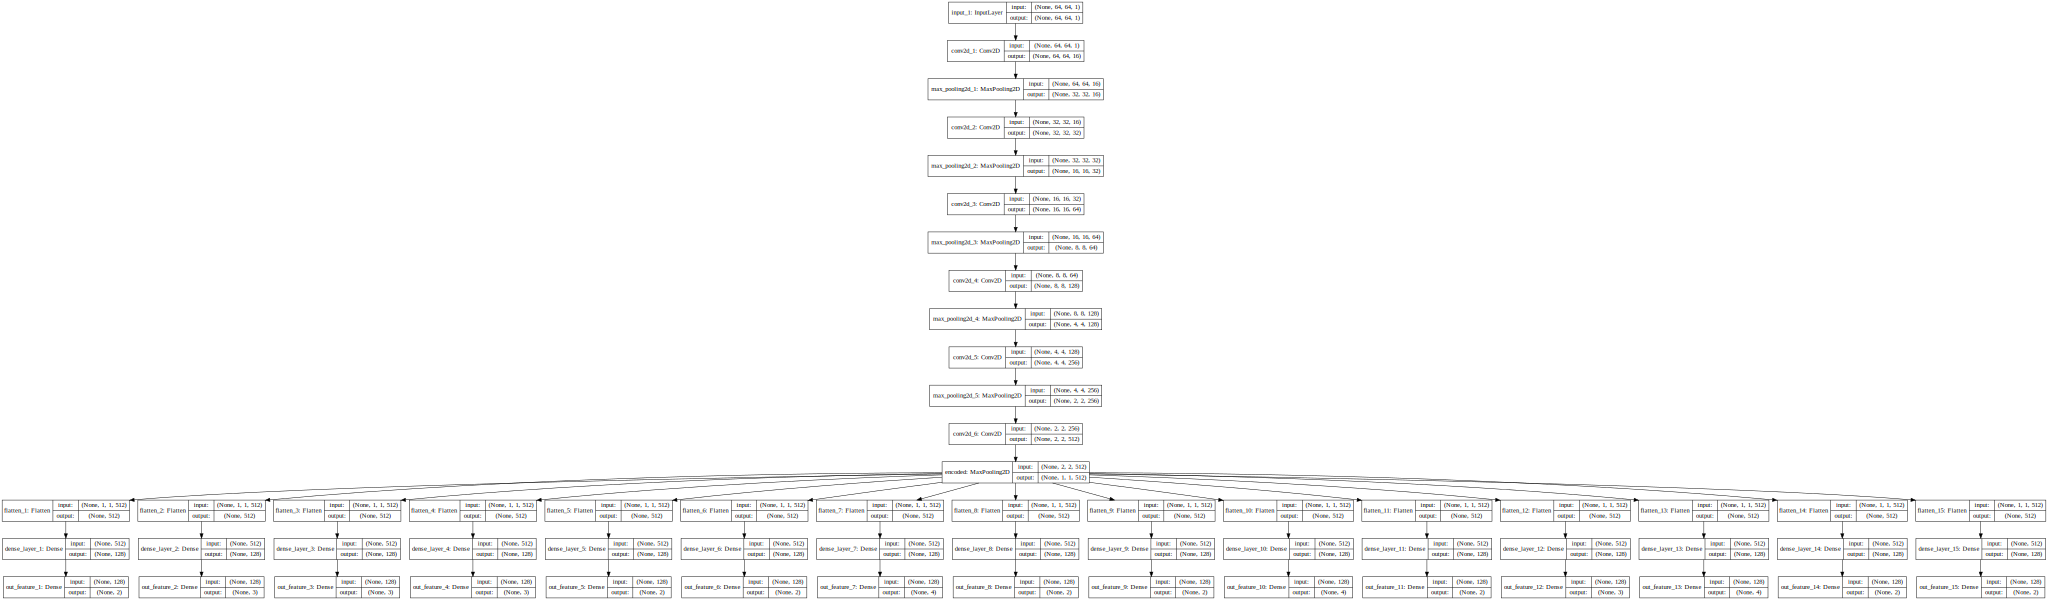

In [12]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [14]:
# df_data[df_data['f8']==2]

In [15]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [16]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [17]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [18]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [19]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [20]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
1
3
2
1
2
2
3
1
1
2
2
3
3
1
2


In [21]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

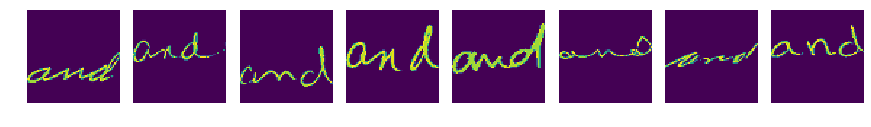

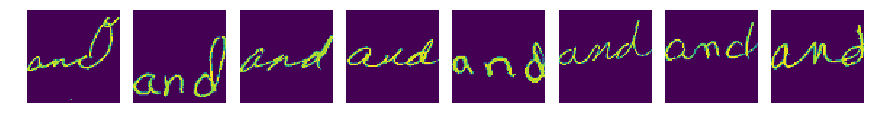

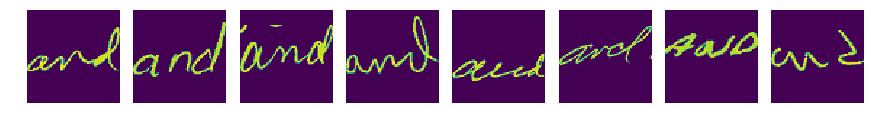

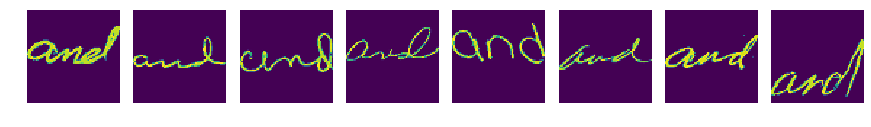

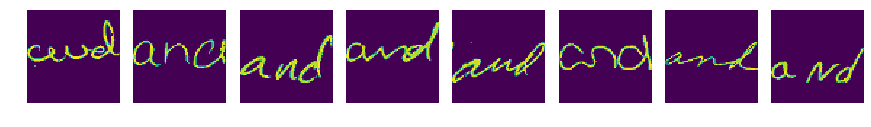

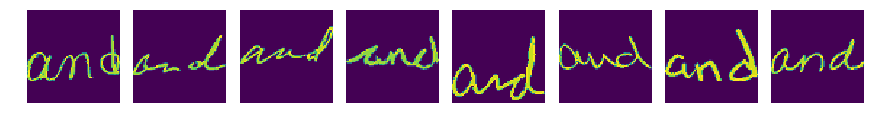

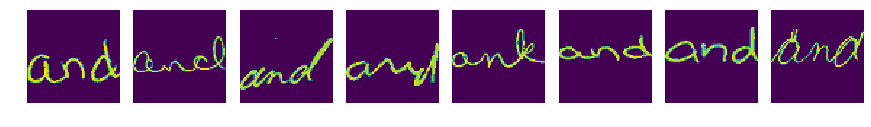

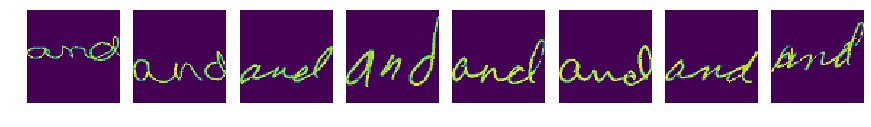

In [22]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [23]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [24]:
mc = ModelCheckpoint(filepath='weights/15-Multitask-FrozenEncoder-seen_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [25]:
EPOCHS = 500000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
# human_features.load_weights('15_human_features_weights_seen_v1.h5')

In [27]:
# human_features.load_weights('weights/15-Multitask-FrozenEncoder-seen_v1.h5')
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/500000

Epoch 00001: val_loss improved from inf to 15.84475, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 2/500000

Epoch 00002: val_loss did not improve from 15.84475
Epoch 3/500000

Epoch 00003: val_loss did not improve from 15.84475
Epoch 4/500000

Epoch 00004: val_loss improved from 15.84475 to 15.46073, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 5/500000

Epoch 00005: val_loss did not improve from 15.46073
Epoch 6/500000

Epoch 00006: val_loss did not improve from 15.46073
Epoch 7/500000

Epoch 00007: val_loss improved from 15.46073 to 15.40589, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 8/500000

Epoch 00008: val_loss did not improve from 15.40589
Epoch 9/500000

Epoch 00009: val_loss improved from 15.40589 to 15.35613, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 10/500000

Epoch 00010: val_loss did not improve from 15.35613
Epoch 11/500000

Epoch 00011: val_loss improved from


Epoch 00098: val_loss did not improve from 10.44231
Epoch 99/500000

Epoch 00099: val_loss did not improve from 10.44231
Epoch 100/500000

Epoch 00100: val_loss did not improve from 10.44231
Epoch 101/500000

Epoch 00101: val_loss did not improve from 10.44231
Epoch 102/500000

Epoch 00102: val_loss did not improve from 10.44231
Epoch 103/500000

Epoch 00103: val_loss did not improve from 10.44231
Epoch 104/500000

Epoch 00104: val_loss did not improve from 10.44231
Epoch 105/500000

Epoch 00105: val_loss did not improve from 10.44231
Epoch 106/500000

Epoch 00106: val_loss did not improve from 10.44231
Epoch 107/500000

Epoch 00107: val_loss did not improve from 10.44231
Epoch 108/500000

Epoch 00108: val_loss did not improve from 10.44231
Epoch 109/500000

Epoch 00109: val_loss did not improve from 10.44231
Epoch 110/500000

Epoch 00110: val_loss did not improve from 10.44231
Epoch 111/500000

Epoch 00111: val_loss did not improve from 10.44231
Epoch 112/500000

Epoch 00112: val_los


Epoch 00210: val_loss did not improve from 9.22964
Epoch 211/500000

Epoch 00211: val_loss did not improve from 9.22964
Epoch 212/500000

Epoch 00212: val_loss did not improve from 9.22964
Epoch 213/500000

Epoch 00213: val_loss did not improve from 9.22964
Epoch 214/500000

Epoch 00214: val_loss did not improve from 9.22964
Epoch 215/500000

Epoch 00215: val_loss did not improve from 9.22964
Epoch 216/500000

Epoch 00216: val_loss did not improve from 9.22964
Epoch 217/500000

Epoch 00217: val_loss did not improve from 9.22964
Epoch 218/500000

Epoch 00218: val_loss did not improve from 9.22964
Epoch 219/500000

Epoch 00219: val_loss did not improve from 9.22964
Epoch 220/500000

Epoch 00220: val_loss did not improve from 9.22964
Epoch 221/500000

Epoch 00221: val_loss did not improve from 9.22964
Epoch 222/500000

Epoch 00222: val_loss did not improve from 9.22964
Epoch 223/500000

Epoch 00223: val_loss did not improve from 9.22964
Epoch 224/500000

Epoch 00224: val_loss improved fr


Epoch 00326: val_loss did not improve from 8.82905
Epoch 327/500000

Epoch 00327: val_loss did not improve from 8.82905
Epoch 328/500000

Epoch 00328: val_loss did not improve from 8.82905
Epoch 329/500000

Epoch 00329: val_loss did not improve from 8.82905
Epoch 330/500000

Epoch 00330: val_loss did not improve from 8.82905
Epoch 331/500000

Epoch 00331: val_loss did not improve from 8.82905
Epoch 332/500000

Epoch 00332: val_loss did not improve from 8.82905
Epoch 333/500000

Epoch 00333: val_loss did not improve from 8.82905
Epoch 334/500000

Epoch 00334: val_loss did not improve from 8.82905
Epoch 335/500000

Epoch 00335: val_loss did not improve from 8.82905
Epoch 336/500000

Epoch 00336: val_loss did not improve from 8.82905
Epoch 337/500000

Epoch 00337: val_loss did not improve from 8.82905
Epoch 338/500000

Epoch 00338: val_loss did not improve from 8.82905
Epoch 339/500000

Epoch 00339: val_loss did not improve from 8.82905
Epoch 340/500000

Epoch 00340: val_loss did not imp


Epoch 00442: val_loss did not improve from 8.52873
Epoch 443/500000

Epoch 00443: val_loss did not improve from 8.52873
Epoch 444/500000

Epoch 00444: val_loss did not improve from 8.52873
Epoch 445/500000

Epoch 00445: val_loss did not improve from 8.52873
Epoch 446/500000

Epoch 00446: val_loss did not improve from 8.52873
Epoch 447/500000

Epoch 00447: val_loss did not improve from 8.52873
Epoch 448/500000

Epoch 00448: val_loss did not improve from 8.52873
Epoch 449/500000

Epoch 00449: val_loss did not improve from 8.52873
Epoch 450/500000

Epoch 00450: val_loss did not improve from 8.52873
Epoch 451/500000

Epoch 00451: val_loss did not improve from 8.52873
Epoch 452/500000

Epoch 00452: val_loss did not improve from 8.52873
Epoch 453/500000

Epoch 00453: val_loss did not improve from 8.52873
Epoch 454/500000

Epoch 00454: val_loss improved from 8.52873 to 8.39122, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 455/500000

Epoch 00455: val_loss did not impro


Epoch 00559: val_loss did not improve from 8.37945
Epoch 560/500000

Epoch 00560: val_loss did not improve from 8.37945
Epoch 561/500000

Epoch 00561: val_loss did not improve from 8.37945
Epoch 562/500000

Epoch 00562: val_loss did not improve from 8.37945
Epoch 563/500000

Epoch 00563: val_loss did not improve from 8.37945
Epoch 564/500000

Epoch 00564: val_loss did not improve from 8.37945
Epoch 565/500000

Epoch 00565: val_loss did not improve from 8.37945
Epoch 566/500000

Epoch 00566: val_loss did not improve from 8.37945
Epoch 567/500000

Epoch 00567: val_loss did not improve from 8.37945
Epoch 568/500000

Epoch 00568: val_loss did not improve from 8.37945
Epoch 569/500000

Epoch 00569: val_loss did not improve from 8.37945
Epoch 570/500000

Epoch 00570: val_loss did not improve from 8.37945
Epoch 571/500000

Epoch 00571: val_loss did not improve from 8.37945
Epoch 572/500000

Epoch 00572: val_loss did not improve from 8.37945
Epoch 573/500000

Epoch 00573: val_loss improved fr


Epoch 00672: val_loss did not improve from 7.94375
Epoch 673/500000

Epoch 00673: val_loss did not improve from 7.94375
Epoch 674/500000

Epoch 00674: val_loss did not improve from 7.94375
Epoch 675/500000

Epoch 00675: val_loss did not improve from 7.94375
Epoch 676/500000

Epoch 00676: val_loss did not improve from 7.94375
Epoch 677/500000

Epoch 00677: val_loss did not improve from 7.94375
Epoch 678/500000

Epoch 00678: val_loss did not improve from 7.94375
Epoch 679/500000

Epoch 00679: val_loss did not improve from 7.94375
Epoch 680/500000

Epoch 00680: val_loss did not improve from 7.94375
Epoch 681/500000

Epoch 00681: val_loss did not improve from 7.94375
Epoch 682/500000

Epoch 00682: val_loss did not improve from 7.94375
Epoch 683/500000

Epoch 00683: val_loss did not improve from 7.94375
Epoch 684/500000

Epoch 00684: val_loss did not improve from 7.94375
Epoch 685/500000

Epoch 00685: val_loss did not improve from 7.94375
Epoch 686/500000

Epoch 00686: val_loss did not imp


Epoch 00788: val_loss did not improve from 7.51752
Epoch 789/500000

Epoch 00789: val_loss did not improve from 7.51752
Epoch 790/500000

Epoch 00790: val_loss did not improve from 7.51752
Epoch 791/500000

Epoch 00791: val_loss did not improve from 7.51752
Epoch 792/500000

Epoch 00792: val_loss did not improve from 7.51752
Epoch 793/500000

Epoch 00793: val_loss did not improve from 7.51752
Epoch 794/500000

Epoch 00794: val_loss did not improve from 7.51752
Epoch 795/500000

Epoch 00795: val_loss did not improve from 7.51752
Epoch 796/500000

Epoch 00796: val_loss did not improve from 7.51752
Epoch 797/500000

Epoch 00797: val_loss did not improve from 7.51752
Epoch 798/500000

Epoch 00798: val_loss did not improve from 7.51752
Epoch 799/500000

Epoch 00799: val_loss did not improve from 7.51752
Epoch 800/500000

Epoch 00800: val_loss did not improve from 7.51752
Epoch 801/500000

Epoch 00801: val_loss did not improve from 7.51752
Epoch 802/500000

Epoch 00802: val_loss did not imp


Epoch 00906: val_loss did not improve from 7.46084
Epoch 907/500000

Epoch 00907: val_loss did not improve from 7.46084
Epoch 908/500000

Epoch 00908: val_loss did not improve from 7.46084
Epoch 909/500000

Epoch 00909: val_loss did not improve from 7.46084
Epoch 910/500000

Epoch 00910: val_loss did not improve from 7.46084
Epoch 911/500000

Epoch 00911: val_loss did not improve from 7.46084
Epoch 912/500000

Epoch 00912: val_loss did not improve from 7.46084
Epoch 913/500000

Epoch 00913: val_loss did not improve from 7.46084
Epoch 914/500000

Epoch 00914: val_loss did not improve from 7.46084
Epoch 915/500000

Epoch 00915: val_loss did not improve from 7.46084
Epoch 916/500000

Epoch 00916: val_loss did not improve from 7.46084
Epoch 917/500000

Epoch 00917: val_loss did not improve from 7.46084
Epoch 918/500000

Epoch 00918: val_loss did not improve from 7.46084
Epoch 919/500000

Epoch 00919: val_loss did not improve from 7.46084
Epoch 920/500000

Epoch 00920: val_loss did not imp


Epoch 01025: val_loss did not improve from 7.46084
Epoch 1026/500000

Epoch 01026: val_loss did not improve from 7.46084
Epoch 1027/500000

Epoch 01027: val_loss did not improve from 7.46084
Epoch 1028/500000

Epoch 01028: val_loss did not improve from 7.46084
Epoch 1029/500000

Epoch 01029: val_loss did not improve from 7.46084
Epoch 1030/500000

Epoch 01030: val_loss did not improve from 7.46084
Epoch 1031/500000

Epoch 01031: val_loss did not improve from 7.46084
Epoch 1032/500000

Epoch 01032: val_loss did not improve from 7.46084
Epoch 1033/500000

Epoch 01033: val_loss did not improve from 7.46084
Epoch 1034/500000

Epoch 01034: val_loss did not improve from 7.46084
Epoch 1035/500000

Epoch 01035: val_loss did not improve from 7.46084
Epoch 1036/500000

Epoch 01036: val_loss did not improve from 7.46084
Epoch 1037/500000

Epoch 01037: val_loss did not improve from 7.46084
Epoch 1038/500000

Epoch 01038: val_loss did not improve from 7.46084
Epoch 1039/500000

Epoch 01039: val_lo


Epoch 01143: val_loss did not improve from 7.46084
Epoch 1144/500000

Epoch 01144: val_loss did not improve from 7.46084
Epoch 1145/500000

Epoch 01145: val_loss did not improve from 7.46084
Epoch 1146/500000

Epoch 01146: val_loss did not improve from 7.46084
Epoch 1147/500000

Epoch 01147: val_loss did not improve from 7.46084
Epoch 1148/500000

Epoch 01148: val_loss did not improve from 7.46084
Epoch 1149/500000

Epoch 01149: val_loss did not improve from 7.46084
Epoch 1150/500000

Epoch 01150: val_loss did not improve from 7.46084
Epoch 1151/500000

Epoch 01151: val_loss did not improve from 7.46084
Epoch 1152/500000

Epoch 01152: val_loss did not improve from 7.46084
Epoch 1153/500000

Epoch 01153: val_loss did not improve from 7.46084
Epoch 1154/500000

Epoch 01154: val_loss did not improve from 7.46084
Epoch 1155/500000

Epoch 01155: val_loss did not improve from 7.46084
Epoch 1156/500000

Epoch 01156: val_loss did not improve from 7.46084
Epoch 1157/500000

Epoch 01157: val_lo


Epoch 01259: val_loss did not improve from 7.28717
Epoch 1260/500000

Epoch 01260: val_loss did not improve from 7.28717
Epoch 1261/500000

Epoch 01261: val_loss did not improve from 7.28717
Epoch 1262/500000

Epoch 01262: val_loss did not improve from 7.28717
Epoch 1263/500000

Epoch 01263: val_loss did not improve from 7.28717
Epoch 1264/500000

Epoch 01264: val_loss did not improve from 7.28717
Epoch 1265/500000

Epoch 01265: val_loss did not improve from 7.28717
Epoch 1266/500000

Epoch 01266: val_loss did not improve from 7.28717
Epoch 1267/500000

Epoch 01267: val_loss did not improve from 7.28717
Epoch 1268/500000

Epoch 01268: val_loss did not improve from 7.28717
Epoch 1269/500000

Epoch 01269: val_loss did not improve from 7.28717
Epoch 1270/500000

Epoch 01270: val_loss did not improve from 7.28717
Epoch 1271/500000

Epoch 01271: val_loss did not improve from 7.28717
Epoch 1272/500000

Epoch 01272: val_loss did not improve from 7.28717
Epoch 1273/500000

Epoch 01273: val_lo


Epoch 01377: val_loss did not improve from 7.28717
Epoch 1378/500000

Epoch 01378: val_loss did not improve from 7.28717
Epoch 1379/500000

Epoch 01379: val_loss did not improve from 7.28717
Epoch 1380/500000

Epoch 01380: val_loss did not improve from 7.28717
Epoch 1381/500000

Epoch 01381: val_loss did not improve from 7.28717
Epoch 1382/500000

Epoch 01382: val_loss did not improve from 7.28717
Epoch 1383/500000

Epoch 01383: val_loss did not improve from 7.28717
Epoch 1384/500000

Epoch 01384: val_loss did not improve from 7.28717
Epoch 1385/500000

Epoch 01385: val_loss did not improve from 7.28717
Epoch 1386/500000

Epoch 01386: val_loss did not improve from 7.28717
Epoch 1387/500000

Epoch 01387: val_loss did not improve from 7.28717
Epoch 1388/500000

Epoch 01388: val_loss did not improve from 7.28717
Epoch 1389/500000

Epoch 01389: val_loss did not improve from 7.28717
Epoch 1390/500000

Epoch 01390: val_loss did not improve from 7.28717
Epoch 1391/500000

Epoch 01391: val_lo


Epoch 01494: val_loss did not improve from 7.24230
Epoch 1495/500000

Epoch 01495: val_loss did not improve from 7.24230
Epoch 1496/500000

Epoch 01496: val_loss did not improve from 7.24230
Epoch 1497/500000

Epoch 01497: val_loss did not improve from 7.24230
Epoch 1498/500000

Epoch 01498: val_loss did not improve from 7.24230
Epoch 1499/500000

Epoch 01499: val_loss did not improve from 7.24230
Epoch 1500/500000

Epoch 01500: val_loss did not improve from 7.24230
Epoch 1501/500000

Epoch 01501: val_loss did not improve from 7.24230
Epoch 1502/500000

Epoch 01502: val_loss did not improve from 7.24230
Epoch 1503/500000

Epoch 01503: val_loss did not improve from 7.24230
Epoch 1504/500000

Epoch 01504: val_loss did not improve from 7.24230
Epoch 1505/500000

Epoch 01505: val_loss did not improve from 7.24230
Epoch 1506/500000

Epoch 01506: val_loss did not improve from 7.24230
Epoch 1507/500000

Epoch 01507: val_loss did not improve from 7.24230
Epoch 1508/500000

Epoch 01508: val_lo


Epoch 01611: val_loss did not improve from 7.11675
Epoch 1612/500000

Epoch 01612: val_loss did not improve from 7.11675
Epoch 1613/500000

Epoch 01613: val_loss did not improve from 7.11675
Epoch 1614/500000

Epoch 01614: val_loss did not improve from 7.11675
Epoch 1615/500000

Epoch 01615: val_loss did not improve from 7.11675
Epoch 1616/500000

Epoch 01616: val_loss did not improve from 7.11675
Epoch 1617/500000

Epoch 01617: val_loss did not improve from 7.11675
Epoch 1618/500000

Epoch 01618: val_loss did not improve from 7.11675
Epoch 1619/500000

Epoch 01619: val_loss did not improve from 7.11675
Epoch 1620/500000

Epoch 01620: val_loss did not improve from 7.11675
Epoch 1621/500000

Epoch 01621: val_loss did not improve from 7.11675
Epoch 1622/500000

Epoch 01622: val_loss did not improve from 7.11675
Epoch 1623/500000

Epoch 01623: val_loss did not improve from 7.11675
Epoch 1624/500000

Epoch 01624: val_loss did not improve from 7.11675
Epoch 1625/500000

Epoch 01625: val_lo


Epoch 01729: val_loss did not improve from 7.11675
Epoch 1730/500000

Epoch 01730: val_loss did not improve from 7.11675
Epoch 1731/500000

Epoch 01731: val_loss did not improve from 7.11675
Epoch 1732/500000

Epoch 01732: val_loss did not improve from 7.11675
Epoch 1733/500000

Epoch 01733: val_loss did not improve from 7.11675
Epoch 1734/500000

Epoch 01734: val_loss did not improve from 7.11675
Epoch 1735/500000

Epoch 01735: val_loss did not improve from 7.11675
Epoch 1736/500000

Epoch 01736: val_loss did not improve from 7.11675
Epoch 1737/500000

Epoch 01737: val_loss did not improve from 7.11675
Epoch 1738/500000

Epoch 01738: val_loss did not improve from 7.11675
Epoch 1739/500000

Epoch 01739: val_loss did not improve from 7.11675
Epoch 1740/500000

Epoch 01740: val_loss did not improve from 7.11675
Epoch 1741/500000

Epoch 01741: val_loss did not improve from 7.11675
Epoch 1742/500000

Epoch 01742: val_loss did not improve from 7.11675
Epoch 1743/500000

Epoch 01743: val_lo


Epoch 01847: val_loss did not improve from 7.11675
Epoch 1848/500000

Epoch 01848: val_loss did not improve from 7.11675
Epoch 1849/500000

Epoch 01849: val_loss did not improve from 7.11675
Epoch 1850/500000

Epoch 01850: val_loss did not improve from 7.11675
Epoch 1851/500000

Epoch 01851: val_loss did not improve from 7.11675
Epoch 1852/500000

Epoch 01852: val_loss did not improve from 7.11675
Epoch 1853/500000

Epoch 01853: val_loss did not improve from 7.11675
Epoch 1854/500000

Epoch 01854: val_loss did not improve from 7.11675
Epoch 1855/500000

Epoch 01855: val_loss did not improve from 7.11675
Epoch 1856/500000

Epoch 01856: val_loss did not improve from 7.11675
Epoch 1857/500000

Epoch 01857: val_loss did not improve from 7.11675
Epoch 1858/500000

Epoch 01858: val_loss did not improve from 7.11675
Epoch 1859/500000

Epoch 01859: val_loss did not improve from 7.11675
Epoch 1860/500000

Epoch 01860: val_loss did not improve from 7.11675
Epoch 1861/500000

Epoch 01861: val_lo


Epoch 01964: val_loss did not improve from 7.05502
Epoch 1965/500000

Epoch 01965: val_loss did not improve from 7.05502
Epoch 1966/500000

Epoch 01966: val_loss did not improve from 7.05502
Epoch 1967/500000

Epoch 01967: val_loss did not improve from 7.05502
Epoch 1968/500000

Epoch 01968: val_loss did not improve from 7.05502
Epoch 1969/500000

Epoch 01969: val_loss did not improve from 7.05502
Epoch 1970/500000

Epoch 01970: val_loss did not improve from 7.05502
Epoch 1971/500000

Epoch 01971: val_loss did not improve from 7.05502
Epoch 1972/500000

Epoch 01972: val_loss did not improve from 7.05502
Epoch 1973/500000

Epoch 01973: val_loss did not improve from 7.05502
Epoch 1974/500000

Epoch 01974: val_loss did not improve from 7.05502
Epoch 1975/500000

Epoch 01975: val_loss did not improve from 7.05502
Epoch 1976/500000

Epoch 01976: val_loss did not improve from 7.05502
Epoch 1977/500000

Epoch 01977: val_loss did not improve from 7.05502
Epoch 1978/500000

Epoch 01978: val_lo


Epoch 02082: val_loss did not improve from 7.05502
Epoch 2083/500000

Epoch 02083: val_loss did not improve from 7.05502
Epoch 2084/500000

Epoch 02084: val_loss did not improve from 7.05502
Epoch 2085/500000

Epoch 02085: val_loss did not improve from 7.05502
Epoch 2086/500000

Epoch 02086: val_loss did not improve from 7.05502
Epoch 2087/500000

Epoch 02087: val_loss did not improve from 7.05502
Epoch 2088/500000

Epoch 02088: val_loss did not improve from 7.05502
Epoch 2089/500000

Epoch 02089: val_loss did not improve from 7.05502
Epoch 2090/500000

Epoch 02090: val_loss did not improve from 7.05502
Epoch 2091/500000

Epoch 02091: val_loss did not improve from 7.05502
Epoch 2092/500000

Epoch 02092: val_loss did not improve from 7.05502
Epoch 2093/500000

Epoch 02093: val_loss did not improve from 7.05502
Epoch 2094/500000

Epoch 02094: val_loss did not improve from 7.05502
Epoch 2095/500000

Epoch 02095: val_loss did not improve from 7.05502
Epoch 2096/500000

Epoch 02096: val_lo


Epoch 02200: val_loss did not improve from 7.05502
Epoch 2201/500000

Epoch 02201: val_loss did not improve from 7.05502
Epoch 2202/500000

Epoch 02202: val_loss did not improve from 7.05502
Epoch 2203/500000

Epoch 02203: val_loss did not improve from 7.05502
Epoch 2204/500000

Epoch 02204: val_loss did not improve from 7.05502
Epoch 2205/500000

Epoch 02205: val_loss did not improve from 7.05502
Epoch 2206/500000

Epoch 02206: val_loss did not improve from 7.05502
Epoch 2207/500000

Epoch 02207: val_loss did not improve from 7.05502
Epoch 2208/500000

Epoch 02208: val_loss did not improve from 7.05502
Epoch 2209/500000

Epoch 02209: val_loss did not improve from 7.05502
Epoch 2210/500000

Epoch 02210: val_loss did not improve from 7.05502
Epoch 2211/500000

Epoch 02211: val_loss did not improve from 7.05502
Epoch 2212/500000

Epoch 02212: val_loss did not improve from 7.05502
Epoch 2213/500000

Epoch 02213: val_loss did not improve from 7.05502
Epoch 2214/500000

Epoch 02214: val_lo


Epoch 02318: val_loss did not improve from 7.05502
Epoch 2319/500000

Epoch 02319: val_loss did not improve from 7.05502
Epoch 2320/500000

Epoch 02320: val_loss did not improve from 7.05502
Epoch 2321/500000

Epoch 02321: val_loss did not improve from 7.05502
Epoch 2322/500000

Epoch 02322: val_loss did not improve from 7.05502
Epoch 2323/500000

Epoch 02323: val_loss did not improve from 7.05502
Epoch 2324/500000

Epoch 02324: val_loss did not improve from 7.05502
Epoch 2325/500000

Epoch 02325: val_loss did not improve from 7.05502
Epoch 2326/500000

Epoch 02326: val_loss did not improve from 7.05502
Epoch 2327/500000

Epoch 02327: val_loss did not improve from 7.05502
Epoch 2328/500000

Epoch 02328: val_loss did not improve from 7.05502
Epoch 2329/500000

Epoch 02329: val_loss did not improve from 7.05502
Epoch 2330/500000

Epoch 02330: val_loss did not improve from 7.05502
Epoch 2331/500000

Epoch 02331: val_loss did not improve from 7.05502
Epoch 2332/500000

Epoch 02332: val_lo


Epoch 02434: val_loss did not improve from 6.90881
Epoch 2435/500000

Epoch 02435: val_loss did not improve from 6.90881
Epoch 2436/500000

Epoch 02436: val_loss did not improve from 6.90881
Epoch 2437/500000

Epoch 02437: val_loss did not improve from 6.90881
Epoch 2438/500000

Epoch 02438: val_loss did not improve from 6.90881
Epoch 2439/500000

Epoch 02439: val_loss did not improve from 6.90881
Epoch 2440/500000

Epoch 02440: val_loss did not improve from 6.90881
Epoch 2441/500000

Epoch 02441: val_loss did not improve from 6.90881
Epoch 2442/500000

Epoch 02442: val_loss did not improve from 6.90881
Epoch 2443/500000

Epoch 02443: val_loss did not improve from 6.90881
Epoch 2444/500000

Epoch 02444: val_loss did not improve from 6.90881
Epoch 2445/500000

Epoch 02445: val_loss did not improve from 6.90881
Epoch 2446/500000

Epoch 02446: val_loss did not improve from 6.90881
Epoch 2447/500000

Epoch 02447: val_loss did not improve from 6.90881
Epoch 2448/500000

Epoch 02448: val_lo


Epoch 02552: val_loss did not improve from 6.90881
Epoch 2553/500000

Epoch 02553: val_loss did not improve from 6.90881
Epoch 2554/500000

Epoch 02554: val_loss did not improve from 6.90881
Epoch 2555/500000

Epoch 02555: val_loss did not improve from 6.90881
Epoch 2556/500000

Epoch 02556: val_loss did not improve from 6.90881
Epoch 2557/500000

Epoch 02557: val_loss did not improve from 6.90881
Epoch 2558/500000

Epoch 02558: val_loss did not improve from 6.90881
Epoch 2559/500000

Epoch 02559: val_loss did not improve from 6.90881
Epoch 2560/500000

Epoch 02560: val_loss did not improve from 6.90881
Epoch 2561/500000

Epoch 02561: val_loss did not improve from 6.90881
Epoch 2562/500000

Epoch 02562: val_loss did not improve from 6.90881
Epoch 2563/500000

Epoch 02563: val_loss did not improve from 6.90881
Epoch 2564/500000

Epoch 02564: val_loss did not improve from 6.90881
Epoch 2565/500000

Epoch 02565: val_loss did not improve from 6.90881
Epoch 2566/500000

Epoch 02566: val_lo


Epoch 02670: val_loss did not improve from 6.90881
Epoch 2671/500000

Epoch 02671: val_loss did not improve from 6.90881
Epoch 2672/500000

Epoch 02672: val_loss did not improve from 6.90881
Epoch 2673/500000

Epoch 02673: val_loss did not improve from 6.90881
Epoch 2674/500000

Epoch 02674: val_loss did not improve from 6.90881
Epoch 2675/500000

Epoch 02675: val_loss did not improve from 6.90881
Epoch 2676/500000

Epoch 02676: val_loss did not improve from 6.90881
Epoch 2677/500000

Epoch 02677: val_loss did not improve from 6.90881
Epoch 2678/500000

Epoch 02678: val_loss did not improve from 6.90881
Epoch 2679/500000

Epoch 02679: val_loss did not improve from 6.90881
Epoch 2680/500000

Epoch 02680: val_loss did not improve from 6.90881
Epoch 2681/500000

Epoch 02681: val_loss did not improve from 6.90881
Epoch 2682/500000

Epoch 02682: val_loss did not improve from 6.90881
Epoch 2683/500000

Epoch 02683: val_loss did not improve from 6.90881
Epoch 2684/500000

Epoch 02684: val_lo


Epoch 02787: val_loss did not improve from 6.88532
Epoch 2788/500000

Epoch 02788: val_loss did not improve from 6.88532
Epoch 2789/500000

Epoch 02789: val_loss did not improve from 6.88532
Epoch 2790/500000

Epoch 02790: val_loss did not improve from 6.88532
Epoch 2791/500000

Epoch 02791: val_loss did not improve from 6.88532
Epoch 2792/500000

Epoch 02792: val_loss did not improve from 6.88532
Epoch 2793/500000

Epoch 02793: val_loss did not improve from 6.88532
Epoch 2794/500000

Epoch 02794: val_loss did not improve from 6.88532
Epoch 2795/500000

Epoch 02795: val_loss did not improve from 6.88532
Epoch 2796/500000

Epoch 02796: val_loss did not improve from 6.88532
Epoch 2797/500000

Epoch 02797: val_loss did not improve from 6.88532
Epoch 2798/500000

Epoch 02798: val_loss did not improve from 6.88532
Epoch 2799/500000

Epoch 02799: val_loss did not improve from 6.88532
Epoch 2800/500000

Epoch 02800: val_loss did not improve from 6.88532
Epoch 2801/500000

Epoch 02801: val_lo


Epoch 02904: val_loss did not improve from 6.88465
Epoch 2905/500000

Epoch 02905: val_loss did not improve from 6.88465
Epoch 2906/500000

Epoch 02906: val_loss did not improve from 6.88465
Epoch 2907/500000

Epoch 02907: val_loss did not improve from 6.88465
Epoch 2908/500000

Epoch 02908: val_loss did not improve from 6.88465
Epoch 2909/500000

Epoch 02909: val_loss did not improve from 6.88465
Epoch 2910/500000

Epoch 02910: val_loss did not improve from 6.88465
Epoch 2911/500000

Epoch 02911: val_loss did not improve from 6.88465
Epoch 2912/500000

Epoch 02912: val_loss did not improve from 6.88465
Epoch 2913/500000

Epoch 02913: val_loss did not improve from 6.88465
Epoch 2914/500000

Epoch 02914: val_loss did not improve from 6.88465
Epoch 2915/500000

Epoch 02915: val_loss did not improve from 6.88465
Epoch 2916/500000

Epoch 02916: val_loss did not improve from 6.88465
Epoch 2917/500000

Epoch 02917: val_loss did not improve from 6.88465
Epoch 2918/500000

Epoch 02918: val_lo


Epoch 03022: val_loss did not improve from 6.88465
Epoch 3023/500000

Epoch 03023: val_loss did not improve from 6.88465
Epoch 3024/500000

Epoch 03024: val_loss did not improve from 6.88465
Epoch 3025/500000

Epoch 03025: val_loss did not improve from 6.88465
Epoch 3026/500000

Epoch 03026: val_loss did not improve from 6.88465
Epoch 3027/500000

Epoch 03027: val_loss did not improve from 6.88465
Epoch 3028/500000

Epoch 03028: val_loss did not improve from 6.88465
Epoch 3029/500000

Epoch 03029: val_loss did not improve from 6.88465
Epoch 3030/500000

Epoch 03030: val_loss did not improve from 6.88465
Epoch 3031/500000

Epoch 03031: val_loss did not improve from 6.88465
Epoch 3032/500000

Epoch 03032: val_loss did not improve from 6.88465
Epoch 3033/500000

Epoch 03033: val_loss did not improve from 6.88465
Epoch 3034/500000

Epoch 03034: val_loss did not improve from 6.88465
Epoch 3035/500000

Epoch 03035: val_loss did not improve from 6.88465
Epoch 3036/500000

Epoch 03036: val_lo


Epoch 03140: val_loss did not improve from 6.88465
Epoch 3141/500000

Epoch 03141: val_loss did not improve from 6.88465
Epoch 3142/500000

Epoch 03142: val_loss did not improve from 6.88465
Epoch 3143/500000

Epoch 03143: val_loss did not improve from 6.88465
Epoch 3144/500000

Epoch 03144: val_loss did not improve from 6.88465
Epoch 3145/500000

Epoch 03145: val_loss did not improve from 6.88465
Epoch 3146/500000

Epoch 03146: val_loss did not improve from 6.88465
Epoch 3147/500000

Epoch 03147: val_loss did not improve from 6.88465
Epoch 3148/500000

Epoch 03148: val_loss improved from 6.88465 to 6.82367, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 3149/500000

Epoch 03149: val_loss did not improve from 6.82367
Epoch 3150/500000

Epoch 03150: val_loss did not improve from 6.82367
Epoch 3151/500000

Epoch 03151: val_loss did not improve from 6.82367
Epoch 3152/500000

Epoch 03152: val_loss did not improve from 6.82367
Epoch 3153/500000

Epoch 03153: val_loss 


Epoch 03257: val_loss did not improve from 6.82367
Epoch 3258/500000

Epoch 03258: val_loss did not improve from 6.82367
Epoch 3259/500000

Epoch 03259: val_loss did not improve from 6.82367
Epoch 3260/500000

Epoch 03260: val_loss did not improve from 6.82367
Epoch 3261/500000

Epoch 03261: val_loss did not improve from 6.82367
Epoch 3262/500000

Epoch 03262: val_loss did not improve from 6.82367
Epoch 3263/500000

Epoch 03263: val_loss did not improve from 6.82367
Epoch 3264/500000

Epoch 03264: val_loss did not improve from 6.82367
Epoch 3265/500000

Epoch 03265: val_loss did not improve from 6.82367
Epoch 3266/500000

Epoch 03266: val_loss did not improve from 6.82367
Epoch 3267/500000

Epoch 03267: val_loss did not improve from 6.82367
Epoch 3268/500000

Epoch 03268: val_loss did not improve from 6.82367
Epoch 3269/500000

Epoch 03269: val_loss did not improve from 6.82367
Epoch 3270/500000

Epoch 03270: val_loss did not improve from 6.82367
Epoch 3271/500000

Epoch 03271: val_lo


Epoch 03373: val_loss did not improve from 6.57857
Epoch 3374/500000

Epoch 03374: val_loss did not improve from 6.57857
Epoch 3375/500000

Epoch 03375: val_loss did not improve from 6.57857
Epoch 3376/500000

Epoch 03376: val_loss did not improve from 6.57857
Epoch 3377/500000

Epoch 03377: val_loss did not improve from 6.57857
Epoch 3378/500000

Epoch 03378: val_loss did not improve from 6.57857
Epoch 3379/500000

Epoch 03379: val_loss did not improve from 6.57857
Epoch 3380/500000

Epoch 03380: val_loss did not improve from 6.57857
Epoch 3381/500000

Epoch 03381: val_loss did not improve from 6.57857
Epoch 3382/500000

Epoch 03382: val_loss did not improve from 6.57857
Epoch 3383/500000

Epoch 03383: val_loss did not improve from 6.57857
Epoch 3384/500000

Epoch 03384: val_loss did not improve from 6.57857
Epoch 3385/500000

Epoch 03385: val_loss did not improve from 6.57857
Epoch 3386/500000

Epoch 03386: val_loss did not improve from 6.57857
Epoch 3387/500000

Epoch 03387: val_lo


Epoch 03491: val_loss did not improve from 6.57857
Epoch 3492/500000

Epoch 03492: val_loss did not improve from 6.57857
Epoch 3493/500000

Epoch 03493: val_loss did not improve from 6.57857
Epoch 3494/500000

Epoch 03494: val_loss did not improve from 6.57857
Epoch 3495/500000

Epoch 03495: val_loss did not improve from 6.57857
Epoch 3496/500000

Epoch 03496: val_loss did not improve from 6.57857
Epoch 3497/500000

Epoch 03497: val_loss did not improve from 6.57857
Epoch 3498/500000

Epoch 03498: val_loss did not improve from 6.57857
Epoch 3499/500000

Epoch 03499: val_loss did not improve from 6.57857
Epoch 3500/500000

Epoch 03500: val_loss did not improve from 6.57857
Epoch 3501/500000

Epoch 03501: val_loss did not improve from 6.57857
Epoch 3502/500000

Epoch 03502: val_loss did not improve from 6.57857
Epoch 3503/500000

Epoch 03503: val_loss did not improve from 6.57857
Epoch 3504/500000

Epoch 03504: val_loss did not improve from 6.57857
Epoch 3505/500000

Epoch 03505: val_lo


Epoch 03609: val_loss did not improve from 6.57857
Epoch 3610/500000

Epoch 03610: val_loss did not improve from 6.57857
Epoch 3611/500000

Epoch 03611: val_loss did not improve from 6.57857
Epoch 3612/500000

Epoch 03612: val_loss did not improve from 6.57857
Epoch 3613/500000

Epoch 03613: val_loss did not improve from 6.57857
Epoch 3614/500000

Epoch 03614: val_loss did not improve from 6.57857
Epoch 3615/500000

Epoch 03615: val_loss did not improve from 6.57857
Epoch 3616/500000

Epoch 03616: val_loss did not improve from 6.57857
Epoch 3617/500000

Epoch 03617: val_loss did not improve from 6.57857
Epoch 3618/500000

Epoch 03618: val_loss did not improve from 6.57857
Epoch 3619/500000

Epoch 03619: val_loss did not improve from 6.57857
Epoch 3620/500000

Epoch 03620: val_loss did not improve from 6.57857
Epoch 3621/500000

Epoch 03621: val_loss did not improve from 6.57857
Epoch 3622/500000

Epoch 03622: val_loss did not improve from 6.57857
Epoch 3623/500000

Epoch 03623: val_lo


Epoch 03727: val_loss did not improve from 6.57857
Epoch 3728/500000

Epoch 03728: val_loss did not improve from 6.57857
Epoch 3729/500000

Epoch 03729: val_loss did not improve from 6.57857
Epoch 3730/500000

Epoch 03730: val_loss did not improve from 6.57857
Epoch 3731/500000

Epoch 03731: val_loss did not improve from 6.57857
Epoch 3732/500000

Epoch 03732: val_loss did not improve from 6.57857
Epoch 3733/500000

Epoch 03733: val_loss did not improve from 6.57857
Epoch 3734/500000

Epoch 03734: val_loss did not improve from 6.57857
Epoch 3735/500000

Epoch 03735: val_loss did not improve from 6.57857
Epoch 3736/500000

Epoch 03736: val_loss did not improve from 6.57857
Epoch 3737/500000

Epoch 03737: val_loss did not improve from 6.57857
Epoch 3738/500000

Epoch 03738: val_loss did not improve from 6.57857
Epoch 3739/500000

Epoch 03739: val_loss did not improve from 6.57857
Epoch 3740/500000

Epoch 03740: val_loss did not improve from 6.57857
Epoch 3741/500000

Epoch 03741: val_lo


Epoch 03845: val_loss did not improve from 6.57857
Epoch 3846/500000

Epoch 03846: val_loss did not improve from 6.57857
Epoch 3847/500000

Epoch 03847: val_loss did not improve from 6.57857
Epoch 3848/500000

Epoch 03848: val_loss did not improve from 6.57857
Epoch 3849/500000

Epoch 03849: val_loss did not improve from 6.57857
Epoch 3850/500000

Epoch 03850: val_loss did not improve from 6.57857
Epoch 3851/500000

Epoch 03851: val_loss did not improve from 6.57857
Epoch 3852/500000

Epoch 03852: val_loss did not improve from 6.57857
Epoch 3853/500000

Epoch 03853: val_loss did not improve from 6.57857
Epoch 3854/500000

Epoch 03854: val_loss did not improve from 6.57857
Epoch 3855/500000

Epoch 03855: val_loss did not improve from 6.57857
Epoch 3856/500000

Epoch 03856: val_loss did not improve from 6.57857
Epoch 3857/500000

Epoch 03857: val_loss did not improve from 6.57857
Epoch 3858/500000

Epoch 03858: val_loss did not improve from 6.57857
Epoch 3859/500000

Epoch 03859: val_lo


Epoch 03963: val_loss did not improve from 6.57857
Epoch 3964/500000

Epoch 03964: val_loss did not improve from 6.57857
Epoch 3965/500000

Epoch 03965: val_loss did not improve from 6.57857
Epoch 3966/500000

Epoch 03966: val_loss did not improve from 6.57857
Epoch 3967/500000

Epoch 03967: val_loss did not improve from 6.57857
Epoch 3968/500000

Epoch 03968: val_loss did not improve from 6.57857
Epoch 3969/500000

Epoch 03969: val_loss did not improve from 6.57857
Epoch 3970/500000

Epoch 03970: val_loss did not improve from 6.57857
Epoch 3971/500000

Epoch 03971: val_loss did not improve from 6.57857
Epoch 3972/500000

Epoch 03972: val_loss did not improve from 6.57857
Epoch 3973/500000

Epoch 03973: val_loss did not improve from 6.57857
Epoch 3974/500000

Epoch 03974: val_loss did not improve from 6.57857
Epoch 3975/500000

Epoch 03975: val_loss did not improve from 6.57857
Epoch 3976/500000

Epoch 03976: val_loss did not improve from 6.57857
Epoch 3977/500000

Epoch 03977: val_lo


Epoch 04080: val_loss did not improve from 6.53071
Epoch 4081/500000

Epoch 04081: val_loss did not improve from 6.53071
Epoch 4082/500000

Epoch 04082: val_loss did not improve from 6.53071
Epoch 4083/500000

Epoch 04083: val_loss did not improve from 6.53071
Epoch 4084/500000

Epoch 04084: val_loss did not improve from 6.53071
Epoch 4085/500000

Epoch 04085: val_loss did not improve from 6.53071
Epoch 4086/500000

Epoch 04086: val_loss did not improve from 6.53071
Epoch 4087/500000

Epoch 04087: val_loss did not improve from 6.53071
Epoch 4088/500000

Epoch 04088: val_loss did not improve from 6.53071
Epoch 4089/500000

Epoch 04089: val_loss did not improve from 6.53071
Epoch 4090/500000

Epoch 04090: val_loss did not improve from 6.53071
Epoch 4091/500000

Epoch 04091: val_loss did not improve from 6.53071
Epoch 4092/500000

Epoch 04092: val_loss did not improve from 6.53071
Epoch 4093/500000

Epoch 04093: val_loss did not improve from 6.53071
Epoch 4094/500000

Epoch 04094: val_lo


Epoch 04198: val_loss did not improve from 6.53071
Epoch 4199/500000

Epoch 04199: val_loss did not improve from 6.53071
Epoch 4200/500000

Epoch 04200: val_loss did not improve from 6.53071
Epoch 4201/500000

Epoch 04201: val_loss did not improve from 6.53071
Epoch 4202/500000

Epoch 04202: val_loss did not improve from 6.53071
Epoch 4203/500000

Epoch 04203: val_loss did not improve from 6.53071
Epoch 4204/500000

Epoch 04204: val_loss did not improve from 6.53071
Epoch 4205/500000

Epoch 04205: val_loss did not improve from 6.53071
Epoch 4206/500000

Epoch 04206: val_loss did not improve from 6.53071
Epoch 4207/500000

Epoch 04207: val_loss did not improve from 6.53071
Epoch 4208/500000

Epoch 04208: val_loss did not improve from 6.53071
Epoch 4209/500000

Epoch 04209: val_loss did not improve from 6.53071
Epoch 4210/500000

Epoch 04210: val_loss did not improve from 6.53071
Epoch 4211/500000

Epoch 04211: val_loss did not improve from 6.53071
Epoch 4212/500000

Epoch 04212: val_lo


Epoch 04316: val_loss did not improve from 6.53071
Epoch 4317/500000

Epoch 04317: val_loss did not improve from 6.53071
Epoch 4318/500000

Epoch 04318: val_loss did not improve from 6.53071
Epoch 4319/500000

Epoch 04319: val_loss did not improve from 6.53071
Epoch 4320/500000

Epoch 04320: val_loss did not improve from 6.53071
Epoch 4321/500000

Epoch 04321: val_loss did not improve from 6.53071
Epoch 4322/500000

Epoch 04322: val_loss did not improve from 6.53071
Epoch 4323/500000

Epoch 04323: val_loss did not improve from 6.53071
Epoch 4324/500000

Epoch 04324: val_loss did not improve from 6.53071
Epoch 4325/500000

Epoch 04325: val_loss did not improve from 6.53071
Epoch 4326/500000

Epoch 04326: val_loss did not improve from 6.53071
Epoch 4327/500000

Epoch 04327: val_loss did not improve from 6.53071
Epoch 4328/500000

Epoch 04328: val_loss did not improve from 6.53071
Epoch 4329/500000

Epoch 04329: val_loss did not improve from 6.53071
Epoch 4330/500000

Epoch 04330: val_lo


Epoch 04434: val_loss did not improve from 6.53071
Epoch 4435/500000

Epoch 04435: val_loss did not improve from 6.53071
Epoch 4436/500000

Epoch 04436: val_loss did not improve from 6.53071
Epoch 4437/500000

Epoch 04437: val_loss did not improve from 6.53071
Epoch 4438/500000

Epoch 04438: val_loss did not improve from 6.53071
Epoch 4439/500000

Epoch 04439: val_loss did not improve from 6.53071
Epoch 4440/500000

Epoch 04440: val_loss did not improve from 6.53071
Epoch 4441/500000

Epoch 04441: val_loss did not improve from 6.53071
Epoch 4442/500000

Epoch 04442: val_loss did not improve from 6.53071
Epoch 4443/500000

Epoch 04443: val_loss did not improve from 6.53071
Epoch 4444/500000

Epoch 04444: val_loss did not improve from 6.53071
Epoch 4445/500000

Epoch 04445: val_loss did not improve from 6.53071
Epoch 4446/500000

Epoch 04446: val_loss did not improve from 6.53071
Epoch 4447/500000

Epoch 04447: val_loss did not improve from 6.53071
Epoch 4448/500000

Epoch 04448: val_lo


Epoch 04552: val_loss did not improve from 6.53071
Epoch 4553/500000

Epoch 04553: val_loss did not improve from 6.53071
Epoch 4554/500000

Epoch 04554: val_loss did not improve from 6.53071
Epoch 4555/500000

Epoch 04555: val_loss did not improve from 6.53071
Epoch 4556/500000

Epoch 04556: val_loss did not improve from 6.53071
Epoch 4557/500000

Epoch 04557: val_loss did not improve from 6.53071
Epoch 4558/500000

Epoch 04558: val_loss did not improve from 6.53071
Epoch 4559/500000

Epoch 04559: val_loss did not improve from 6.53071
Epoch 4560/500000

Epoch 04560: val_loss did not improve from 6.53071
Epoch 4561/500000

Epoch 04561: val_loss did not improve from 6.53071
Epoch 4562/500000

Epoch 04562: val_loss did not improve from 6.53071
Epoch 4563/500000

Epoch 04563: val_loss did not improve from 6.53071
Epoch 4564/500000

Epoch 04564: val_loss did not improve from 6.53071
Epoch 4565/500000

Epoch 04565: val_loss did not improve from 6.53071
Epoch 4566/500000

Epoch 04566: val_lo


Epoch 04669: val_loss did not improve from 6.52246
Epoch 4670/500000

Epoch 04670: val_loss did not improve from 6.52246
Epoch 4671/500000

Epoch 04671: val_loss did not improve from 6.52246
Epoch 4672/500000

Epoch 04672: val_loss did not improve from 6.52246
Epoch 4673/500000

Epoch 04673: val_loss did not improve from 6.52246
Epoch 4674/500000

Epoch 04674: val_loss did not improve from 6.52246
Epoch 4675/500000

Epoch 04675: val_loss did not improve from 6.52246
Epoch 4676/500000

Epoch 04676: val_loss did not improve from 6.52246
Epoch 4677/500000

Epoch 04677: val_loss did not improve from 6.52246
Epoch 4678/500000

Epoch 04678: val_loss did not improve from 6.52246
Epoch 4679/500000

Epoch 04679: val_loss did not improve from 6.52246
Epoch 4680/500000

Epoch 04680: val_loss did not improve from 6.52246
Epoch 4681/500000

Epoch 04681: val_loss did not improve from 6.52246
Epoch 4682/500000

Epoch 04682: val_loss did not improve from 6.52246
Epoch 4683/500000

Epoch 04683: val_lo


Epoch 04787: val_loss did not improve from 6.52246
Epoch 4788/500000

Epoch 04788: val_loss did not improve from 6.52246
Epoch 4789/500000

Epoch 04789: val_loss did not improve from 6.52246
Epoch 4790/500000

Epoch 04790: val_loss did not improve from 6.52246
Epoch 4791/500000

Epoch 04791: val_loss did not improve from 6.52246
Epoch 4792/500000

Epoch 04792: val_loss did not improve from 6.52246
Epoch 4793/500000

Epoch 04793: val_loss did not improve from 6.52246
Epoch 4794/500000

Epoch 04794: val_loss did not improve from 6.52246
Epoch 4795/500000

Epoch 04795: val_loss did not improve from 6.52246
Epoch 4796/500000

Epoch 04796: val_loss did not improve from 6.52246
Epoch 4797/500000

Epoch 04797: val_loss did not improve from 6.52246
Epoch 4798/500000

Epoch 04798: val_loss did not improve from 6.52246
Epoch 4799/500000

Epoch 04799: val_loss did not improve from 6.52246
Epoch 4800/500000

Epoch 04800: val_loss did not improve from 6.52246
Epoch 4801/500000

Epoch 04801: val_lo


Epoch 04905: val_loss did not improve from 6.52246
Epoch 4906/500000

Epoch 04906: val_loss did not improve from 6.52246
Epoch 4907/500000

Epoch 04907: val_loss did not improve from 6.52246
Epoch 4908/500000

Epoch 04908: val_loss did not improve from 6.52246
Epoch 4909/500000

Epoch 04909: val_loss did not improve from 6.52246
Epoch 4910/500000

Epoch 04910: val_loss did not improve from 6.52246
Epoch 4911/500000

Epoch 04911: val_loss did not improve from 6.52246
Epoch 4912/500000

Epoch 04912: val_loss did not improve from 6.52246
Epoch 4913/500000

Epoch 04913: val_loss did not improve from 6.52246
Epoch 4914/500000

Epoch 04914: val_loss did not improve from 6.52246
Epoch 4915/500000

Epoch 04915: val_loss did not improve from 6.52246
Epoch 4916/500000

Epoch 04916: val_loss did not improve from 6.52246
Epoch 4917/500000

Epoch 04917: val_loss did not improve from 6.52246
Epoch 4918/500000

Epoch 04918: val_loss did not improve from 6.52246
Epoch 4919/500000

Epoch 04919: val_lo


Epoch 05023: val_loss did not improve from 6.52246
Epoch 5024/500000

Epoch 05024: val_loss did not improve from 6.52246
Epoch 5025/500000

Epoch 05025: val_loss did not improve from 6.52246
Epoch 5026/500000

Epoch 05026: val_loss did not improve from 6.52246
Epoch 5027/500000

Epoch 05027: val_loss did not improve from 6.52246
Epoch 5028/500000

Epoch 05028: val_loss did not improve from 6.52246
Epoch 5029/500000

Epoch 05029: val_loss did not improve from 6.52246
Epoch 5030/500000

Epoch 05030: val_loss did not improve from 6.52246
Epoch 5031/500000

Epoch 05031: val_loss did not improve from 6.52246
Epoch 5032/500000

Epoch 05032: val_loss did not improve from 6.52246
Epoch 5033/500000

Epoch 05033: val_loss did not improve from 6.52246
Epoch 5034/500000

Epoch 05034: val_loss did not improve from 6.52246
Epoch 5035/500000

Epoch 05035: val_loss did not improve from 6.52246
Epoch 5036/500000

Epoch 05036: val_loss did not improve from 6.52246
Epoch 5037/500000

Epoch 05037: val_lo


Epoch 05141: val_loss did not improve from 6.52246
Epoch 5142/500000

Epoch 05142: val_loss did not improve from 6.52246
Epoch 5143/500000

Epoch 05143: val_loss did not improve from 6.52246
Epoch 5144/500000

Epoch 05144: val_loss did not improve from 6.52246
Epoch 5145/500000

Epoch 05145: val_loss did not improve from 6.52246
Epoch 5146/500000

Epoch 05146: val_loss did not improve from 6.52246
Epoch 5147/500000

Epoch 05147: val_loss did not improve from 6.52246
Epoch 5148/500000

Epoch 05148: val_loss did not improve from 6.52246
Epoch 5149/500000

Epoch 05149: val_loss did not improve from 6.52246
Epoch 5150/500000

Epoch 05150: val_loss did not improve from 6.52246
Epoch 5151/500000

Epoch 05151: val_loss did not improve from 6.52246
Epoch 5152/500000

Epoch 05152: val_loss did not improve from 6.52246
Epoch 5153/500000

Epoch 05153: val_loss did not improve from 6.52246
Epoch 5154/500000

Epoch 05154: val_loss did not improve from 6.52246
Epoch 5155/500000

Epoch 05155: val_lo


Epoch 05259: val_loss did not improve from 6.52246
Epoch 5260/500000

Epoch 05260: val_loss did not improve from 6.52246
Epoch 5261/500000

Epoch 05261: val_loss did not improve from 6.52246
Epoch 5262/500000

Epoch 05262: val_loss did not improve from 6.52246
Epoch 5263/500000

Epoch 05263: val_loss did not improve from 6.52246
Epoch 5264/500000

Epoch 05264: val_loss did not improve from 6.52246
Epoch 5265/500000

Epoch 05265: val_loss did not improve from 6.52246
Epoch 5266/500000

Epoch 05266: val_loss did not improve from 6.52246
Epoch 5267/500000

Epoch 05267: val_loss did not improve from 6.52246
Epoch 5268/500000

Epoch 05268: val_loss did not improve from 6.52246
Epoch 5269/500000

Epoch 05269: val_loss did not improve from 6.52246
Epoch 5270/500000

Epoch 05270: val_loss did not improve from 6.52246
Epoch 5271/500000

Epoch 05271: val_loss did not improve from 6.52246
Epoch 5272/500000

Epoch 05272: val_loss did not improve from 6.52246
Epoch 5273/500000

Epoch 05273: val_lo


Epoch 05377: val_loss did not improve from 6.52246
Epoch 5378/500000

Epoch 05378: val_loss did not improve from 6.52246
Epoch 5379/500000

Epoch 05379: val_loss did not improve from 6.52246
Epoch 5380/500000

Epoch 05380: val_loss did not improve from 6.52246
Epoch 5381/500000

Epoch 05381: val_loss did not improve from 6.52246
Epoch 5382/500000

Epoch 05382: val_loss did not improve from 6.52246
Epoch 5383/500000

Epoch 05383: val_loss did not improve from 6.52246
Epoch 5384/500000

Epoch 05384: val_loss did not improve from 6.52246
Epoch 5385/500000

Epoch 05385: val_loss did not improve from 6.52246
Epoch 5386/500000

Epoch 05386: val_loss did not improve from 6.52246
Epoch 5387/500000

Epoch 05387: val_loss did not improve from 6.52246
Epoch 5388/500000

Epoch 05388: val_loss did not improve from 6.52246
Epoch 5389/500000

Epoch 05389: val_loss did not improve from 6.52246
Epoch 5390/500000

Epoch 05390: val_loss did not improve from 6.52246
Epoch 5391/500000

Epoch 05391: val_lo


Epoch 05494: val_loss did not improve from 6.47408
Epoch 5495/500000

Epoch 05495: val_loss did not improve from 6.47408
Epoch 5496/500000

Epoch 05496: val_loss did not improve from 6.47408
Epoch 5497/500000

Epoch 05497: val_loss did not improve from 6.47408
Epoch 5498/500000

Epoch 05498: val_loss did not improve from 6.47408
Epoch 5499/500000

Epoch 05499: val_loss did not improve from 6.47408
Epoch 5500/500000

Epoch 05500: val_loss did not improve from 6.47408
Epoch 5501/500000

Epoch 05501: val_loss did not improve from 6.47408
Epoch 5502/500000

Epoch 05502: val_loss did not improve from 6.47408
Epoch 5503/500000

Epoch 05503: val_loss did not improve from 6.47408
Epoch 5504/500000

Epoch 05504: val_loss did not improve from 6.47408
Epoch 5505/500000

Epoch 05505: val_loss did not improve from 6.47408
Epoch 5506/500000

Epoch 05506: val_loss did not improve from 6.47408
Epoch 5507/500000

Epoch 05507: val_loss did not improve from 6.47408
Epoch 5508/500000

Epoch 05508: val_lo


Epoch 05612: val_loss did not improve from 6.47408
Epoch 5613/500000

Epoch 05613: val_loss did not improve from 6.47408
Epoch 5614/500000

Epoch 05614: val_loss did not improve from 6.47408
Epoch 5615/500000

Epoch 05615: val_loss did not improve from 6.47408
Epoch 5616/500000

Epoch 05616: val_loss did not improve from 6.47408
Epoch 5617/500000

Epoch 05617: val_loss did not improve from 6.47408
Epoch 5618/500000

Epoch 05618: val_loss did not improve from 6.47408
Epoch 5619/500000

Epoch 05619: val_loss did not improve from 6.47408
Epoch 5620/500000

Epoch 05620: val_loss did not improve from 6.47408
Epoch 5621/500000

Epoch 05621: val_loss did not improve from 6.47408
Epoch 5622/500000

Epoch 05622: val_loss did not improve from 6.47408
Epoch 5623/500000

Epoch 05623: val_loss did not improve from 6.47408
Epoch 5624/500000

Epoch 05624: val_loss did not improve from 6.47408
Epoch 5625/500000

Epoch 05625: val_loss did not improve from 6.47408
Epoch 5626/500000

Epoch 05626: val_lo


Epoch 05729: val_loss did not improve from 6.35121
Epoch 5730/500000

Epoch 05730: val_loss did not improve from 6.35121
Epoch 5731/500000

Epoch 05731: val_loss did not improve from 6.35121
Epoch 5732/500000

Epoch 05732: val_loss did not improve from 6.35121
Epoch 5733/500000

Epoch 05733: val_loss did not improve from 6.35121
Epoch 5734/500000

Epoch 05734: val_loss did not improve from 6.35121
Epoch 5735/500000

Epoch 05735: val_loss did not improve from 6.35121
Epoch 5736/500000

Epoch 05736: val_loss did not improve from 6.35121
Epoch 5737/500000

Epoch 05737: val_loss did not improve from 6.35121
Epoch 5738/500000

Epoch 05738: val_loss did not improve from 6.35121
Epoch 5739/500000

Epoch 05739: val_loss did not improve from 6.35121
Epoch 5740/500000

Epoch 05740: val_loss did not improve from 6.35121
Epoch 5741/500000

Epoch 05741: val_loss did not improve from 6.35121
Epoch 5742/500000

Epoch 05742: val_loss did not improve from 6.35121
Epoch 5743/500000

Epoch 05743: val_lo


Epoch 05847: val_loss did not improve from 6.35121
Epoch 5848/500000

Epoch 05848: val_loss did not improve from 6.35121
Epoch 5849/500000

Epoch 05849: val_loss did not improve from 6.35121
Epoch 5850/500000

Epoch 05850: val_loss did not improve from 6.35121
Epoch 5851/500000

Epoch 05851: val_loss did not improve from 6.35121
Epoch 5852/500000

Epoch 05852: val_loss did not improve from 6.35121
Epoch 5853/500000

Epoch 05853: val_loss did not improve from 6.35121
Epoch 5854/500000

Epoch 05854: val_loss did not improve from 6.35121
Epoch 5855/500000

Epoch 05855: val_loss did not improve from 6.35121
Epoch 5856/500000

Epoch 05856: val_loss did not improve from 6.35121
Epoch 5857/500000

Epoch 05857: val_loss did not improve from 6.35121
Epoch 5858/500000

Epoch 05858: val_loss did not improve from 6.35121
Epoch 5859/500000

Epoch 05859: val_loss did not improve from 6.35121
Epoch 5860/500000

Epoch 05860: val_loss did not improve from 6.35121
Epoch 5861/500000

Epoch 05861: val_lo


Epoch 05965: val_loss did not improve from 6.35121
Epoch 5966/500000

Epoch 05966: val_loss did not improve from 6.35121
Epoch 5967/500000

Epoch 05967: val_loss did not improve from 6.35121
Epoch 5968/500000

Epoch 05968: val_loss did not improve from 6.35121
Epoch 5969/500000

Epoch 05969: val_loss did not improve from 6.35121
Epoch 5970/500000

Epoch 05970: val_loss did not improve from 6.35121
Epoch 5971/500000

Epoch 05971: val_loss did not improve from 6.35121
Epoch 5972/500000

Epoch 05972: val_loss did not improve from 6.35121
Epoch 5973/500000

Epoch 05973: val_loss did not improve from 6.35121
Epoch 5974/500000

Epoch 05974: val_loss did not improve from 6.35121
Epoch 5975/500000

Epoch 05975: val_loss did not improve from 6.35121
Epoch 5976/500000

Epoch 05976: val_loss did not improve from 6.35121
Epoch 5977/500000

Epoch 05977: val_loss did not improve from 6.35121
Epoch 5978/500000

Epoch 05978: val_loss did not improve from 6.35121
Epoch 5979/500000

Epoch 05979: val_lo


Epoch 06083: val_loss did not improve from 6.35121
Epoch 6084/500000

Epoch 06084: val_loss did not improve from 6.35121
Epoch 6085/500000

Epoch 06085: val_loss did not improve from 6.35121
Epoch 6086/500000

Epoch 06086: val_loss did not improve from 6.35121
Epoch 6087/500000

Epoch 06087: val_loss did not improve from 6.35121
Epoch 6088/500000

Epoch 06088: val_loss did not improve from 6.35121
Epoch 6089/500000

Epoch 06089: val_loss did not improve from 6.35121
Epoch 6090/500000

Epoch 06090: val_loss did not improve from 6.35121
Epoch 6091/500000

Epoch 06091: val_loss did not improve from 6.35121
Epoch 6092/500000

Epoch 06092: val_loss did not improve from 6.35121
Epoch 6093/500000

Epoch 06093: val_loss did not improve from 6.35121
Epoch 6094/500000

Epoch 06094: val_loss did not improve from 6.35121
Epoch 6095/500000

Epoch 06095: val_loss did not improve from 6.35121
Epoch 6096/500000

Epoch 06096: val_loss did not improve from 6.35121
Epoch 6097/500000

Epoch 06097: val_lo


Epoch 06201: val_loss did not improve from 6.35121
Epoch 6202/500000

Epoch 06202: val_loss did not improve from 6.35121
Epoch 6203/500000

Epoch 06203: val_loss did not improve from 6.35121
Epoch 6204/500000

Epoch 06204: val_loss did not improve from 6.35121
Epoch 6205/500000

Epoch 06205: val_loss did not improve from 6.35121
Epoch 6206/500000

Epoch 06206: val_loss did not improve from 6.35121
Epoch 6207/500000

Epoch 06207: val_loss did not improve from 6.35121
Epoch 6208/500000

Epoch 06208: val_loss did not improve from 6.35121
Epoch 6209/500000

Epoch 06209: val_loss did not improve from 6.35121
Epoch 6210/500000

Epoch 06210: val_loss did not improve from 6.35121
Epoch 6211/500000

Epoch 06211: val_loss did not improve from 6.35121
Epoch 6212/500000

Epoch 06212: val_loss did not improve from 6.35121
Epoch 6213/500000

Epoch 06213: val_loss did not improve from 6.35121
Epoch 6214/500000

Epoch 06214: val_loss did not improve from 6.35121
Epoch 6215/500000

Epoch 06215: val_lo


Epoch 06319: val_loss did not improve from 6.35121
Epoch 6320/500000

Epoch 06320: val_loss did not improve from 6.35121
Epoch 6321/500000

Epoch 06321: val_loss did not improve from 6.35121
Epoch 6322/500000

Epoch 06322: val_loss did not improve from 6.35121
Epoch 6323/500000

Epoch 06323: val_loss did not improve from 6.35121
Epoch 6324/500000

Epoch 06324: val_loss did not improve from 6.35121
Epoch 6325/500000

Epoch 06325: val_loss did not improve from 6.35121
Epoch 6326/500000

Epoch 06326: val_loss did not improve from 6.35121
Epoch 6327/500000

Epoch 06327: val_loss did not improve from 6.35121
Epoch 6328/500000

Epoch 06328: val_loss did not improve from 6.35121
Epoch 6329/500000

Epoch 06329: val_loss did not improve from 6.35121
Epoch 6330/500000

Epoch 06330: val_loss did not improve from 6.35121
Epoch 6331/500000

Epoch 06331: val_loss did not improve from 6.35121
Epoch 6332/500000

Epoch 06332: val_loss did not improve from 6.35121
Epoch 6333/500000

Epoch 06333: val_lo


Epoch 06437: val_loss did not improve from 6.35121
Epoch 6438/500000

Epoch 06438: val_loss did not improve from 6.35121
Epoch 6439/500000

Epoch 06439: val_loss did not improve from 6.35121
Epoch 6440/500000

Epoch 06440: val_loss did not improve from 6.35121
Epoch 6441/500000

Epoch 06441: val_loss did not improve from 6.35121
Epoch 6442/500000

Epoch 06442: val_loss did not improve from 6.35121
Epoch 6443/500000

Epoch 06443: val_loss did not improve from 6.35121
Epoch 6444/500000

Epoch 06444: val_loss did not improve from 6.35121
Epoch 6445/500000

Epoch 06445: val_loss did not improve from 6.35121
Epoch 6446/500000

Epoch 06446: val_loss did not improve from 6.35121
Epoch 6447/500000

Epoch 06447: val_loss did not improve from 6.35121
Epoch 6448/500000

Epoch 06448: val_loss did not improve from 6.35121
Epoch 6449/500000

Epoch 06449: val_loss did not improve from 6.35121
Epoch 6450/500000

Epoch 06450: val_loss did not improve from 6.35121
Epoch 6451/500000

Epoch 06451: val_lo


Epoch 06555: val_loss did not improve from 6.35121
Epoch 6556/500000

Epoch 06556: val_loss did not improve from 6.35121
Epoch 6557/500000

Epoch 06557: val_loss did not improve from 6.35121
Epoch 6558/500000

Epoch 06558: val_loss did not improve from 6.35121
Epoch 6559/500000

Epoch 06559: val_loss did not improve from 6.35121
Epoch 6560/500000

Epoch 06560: val_loss did not improve from 6.35121
Epoch 6561/500000

Epoch 06561: val_loss did not improve from 6.35121
Epoch 6562/500000

Epoch 06562: val_loss did not improve from 6.35121
Epoch 6563/500000

Epoch 06563: val_loss did not improve from 6.35121
Epoch 6564/500000

Epoch 06564: val_loss did not improve from 6.35121
Epoch 6565/500000

Epoch 06565: val_loss did not improve from 6.35121
Epoch 6566/500000

Epoch 06566: val_loss did not improve from 6.35121
Epoch 6567/500000

Epoch 06567: val_loss did not improve from 6.35121
Epoch 6568/500000

Epoch 06568: val_loss did not improve from 6.35121
Epoch 6569/500000

Epoch 06569: val_lo


Epoch 06673: val_loss did not improve from 6.35121
Epoch 6674/500000

Epoch 06674: val_loss did not improve from 6.35121
Epoch 6675/500000

Epoch 06675: val_loss did not improve from 6.35121
Epoch 6676/500000

Epoch 06676: val_loss did not improve from 6.35121
Epoch 6677/500000

Epoch 06677: val_loss did not improve from 6.35121
Epoch 6678/500000

Epoch 06678: val_loss did not improve from 6.35121
Epoch 6679/500000

Epoch 06679: val_loss did not improve from 6.35121
Epoch 6680/500000

Epoch 06680: val_loss did not improve from 6.35121
Epoch 6681/500000

Epoch 06681: val_loss did not improve from 6.35121
Epoch 6682/500000

Epoch 06682: val_loss did not improve from 6.35121
Epoch 6683/500000

Epoch 06683: val_loss did not improve from 6.35121
Epoch 6684/500000

Epoch 06684: val_loss did not improve from 6.35121
Epoch 6685/500000

Epoch 06685: val_loss did not improve from 6.35121
Epoch 6686/500000

Epoch 06686: val_loss did not improve from 6.35121
Epoch 6687/500000

Epoch 06687: val_lo


Epoch 06791: val_loss did not improve from 6.35121
Epoch 6792/500000

Epoch 06792: val_loss did not improve from 6.35121
Epoch 6793/500000

Epoch 06793: val_loss did not improve from 6.35121
Epoch 6794/500000

Epoch 06794: val_loss did not improve from 6.35121
Epoch 6795/500000

Epoch 06795: val_loss did not improve from 6.35121
Epoch 6796/500000

Epoch 06796: val_loss did not improve from 6.35121
Epoch 6797/500000

Epoch 06797: val_loss did not improve from 6.35121
Epoch 6798/500000

Epoch 06798: val_loss did not improve from 6.35121
Epoch 6799/500000

Epoch 06799: val_loss did not improve from 6.35121
Epoch 6800/500000

Epoch 06800: val_loss did not improve from 6.35121
Epoch 6801/500000

Epoch 06801: val_loss did not improve from 6.35121
Epoch 6802/500000

Epoch 06802: val_loss did not improve from 6.35121
Epoch 6803/500000

Epoch 06803: val_loss did not improve from 6.35121
Epoch 6804/500000

Epoch 06804: val_loss did not improve from 6.35121
Epoch 6805/500000

Epoch 06805: val_lo


Epoch 06909: val_loss did not improve from 6.35121
Epoch 6910/500000

Epoch 06910: val_loss did not improve from 6.35121
Epoch 6911/500000

Epoch 06911: val_loss did not improve from 6.35121
Epoch 6912/500000

Epoch 06912: val_loss did not improve from 6.35121
Epoch 6913/500000

Epoch 06913: val_loss did not improve from 6.35121
Epoch 6914/500000

Epoch 06914: val_loss did not improve from 6.35121
Epoch 6915/500000

Epoch 06915: val_loss did not improve from 6.35121
Epoch 6916/500000

Epoch 06916: val_loss did not improve from 6.35121
Epoch 6917/500000

Epoch 06917: val_loss did not improve from 6.35121
Epoch 6918/500000

Epoch 06918: val_loss did not improve from 6.35121
Epoch 6919/500000

Epoch 06919: val_loss did not improve from 6.35121
Epoch 6920/500000

Epoch 06920: val_loss did not improve from 6.35121
Epoch 6921/500000

Epoch 06921: val_loss did not improve from 6.35121
Epoch 6922/500000

Epoch 06922: val_loss did not improve from 6.35121
Epoch 6923/500000

Epoch 06923: val_lo


Epoch 07027: val_loss did not improve from 6.35121
Epoch 7028/500000

Epoch 07028: val_loss did not improve from 6.35121
Epoch 7029/500000

Epoch 07029: val_loss did not improve from 6.35121
Epoch 7030/500000

Epoch 07030: val_loss did not improve from 6.35121
Epoch 7031/500000

Epoch 07031: val_loss did not improve from 6.35121
Epoch 7032/500000

Epoch 07032: val_loss did not improve from 6.35121
Epoch 7033/500000

Epoch 07033: val_loss did not improve from 6.35121
Epoch 7034/500000

Epoch 07034: val_loss did not improve from 6.35121
Epoch 7035/500000

Epoch 07035: val_loss did not improve from 6.35121
Epoch 7036/500000

Epoch 07036: val_loss did not improve from 6.35121
Epoch 7037/500000

Epoch 07037: val_loss did not improve from 6.35121
Epoch 7038/500000

Epoch 07038: val_loss did not improve from 6.35121
Epoch 7039/500000

Epoch 07039: val_loss did not improve from 6.35121
Epoch 7040/500000

Epoch 07040: val_loss did not improve from 6.35121
Epoch 7041/500000

Epoch 07041: val_lo


Epoch 07145: val_loss did not improve from 6.35121
Epoch 7146/500000

Epoch 07146: val_loss did not improve from 6.35121
Epoch 7147/500000

Epoch 07147: val_loss did not improve from 6.35121
Epoch 7148/500000

Epoch 07148: val_loss did not improve from 6.35121
Epoch 7149/500000

Epoch 07149: val_loss did not improve from 6.35121
Epoch 7150/500000

Epoch 07150: val_loss did not improve from 6.35121
Epoch 7151/500000

Epoch 07151: val_loss did not improve from 6.35121
Epoch 7152/500000

Epoch 07152: val_loss did not improve from 6.35121
Epoch 7153/500000

Epoch 07153: val_loss did not improve from 6.35121
Epoch 7154/500000

Epoch 07154: val_loss did not improve from 6.35121
Epoch 7155/500000

Epoch 07155: val_loss did not improve from 6.35121
Epoch 7156/500000

Epoch 07156: val_loss did not improve from 6.35121
Epoch 7157/500000

Epoch 07157: val_loss did not improve from 6.35121
Epoch 7158/500000

Epoch 07158: val_loss did not improve from 6.35121
Epoch 7159/500000

Epoch 07159: val_lo


Epoch 07263: val_loss did not improve from 6.35121
Epoch 7264/500000

Epoch 07264: val_loss did not improve from 6.35121
Epoch 7265/500000

Epoch 07265: val_loss did not improve from 6.35121
Epoch 7266/500000

Epoch 07266: val_loss did not improve from 6.35121
Epoch 7267/500000

Epoch 07267: val_loss did not improve from 6.35121
Epoch 7268/500000

Epoch 07268: val_loss did not improve from 6.35121
Epoch 7269/500000

Epoch 07269: val_loss did not improve from 6.35121
Epoch 7270/500000

Epoch 07270: val_loss did not improve from 6.35121
Epoch 7271/500000

Epoch 07271: val_loss did not improve from 6.35121
Epoch 7272/500000

Epoch 07272: val_loss did not improve from 6.35121
Epoch 7273/500000

Epoch 07273: val_loss did not improve from 6.35121
Epoch 7274/500000

Epoch 07274: val_loss did not improve from 6.35121
Epoch 7275/500000

Epoch 07275: val_loss did not improve from 6.35121
Epoch 7276/500000

Epoch 07276: val_loss did not improve from 6.35121
Epoch 7277/500000

Epoch 07277: val_lo


Epoch 07381: val_loss did not improve from 6.35121
Epoch 7382/500000

Epoch 07382: val_loss did not improve from 6.35121
Epoch 7383/500000

Epoch 07383: val_loss did not improve from 6.35121
Epoch 7384/500000

Epoch 07384: val_loss did not improve from 6.35121
Epoch 7385/500000

Epoch 07385: val_loss did not improve from 6.35121
Epoch 7386/500000

Epoch 07386: val_loss did not improve from 6.35121
Epoch 7387/500000

Epoch 07387: val_loss did not improve from 6.35121
Epoch 7388/500000

Epoch 07388: val_loss did not improve from 6.35121
Epoch 7389/500000

Epoch 07389: val_loss did not improve from 6.35121
Epoch 7390/500000

Epoch 07390: val_loss did not improve from 6.35121
Epoch 7391/500000

Epoch 07391: val_loss did not improve from 6.35121
Epoch 7392/500000

Epoch 07392: val_loss did not improve from 6.35121
Epoch 7393/500000

Epoch 07393: val_loss did not improve from 6.35121
Epoch 7394/500000

Epoch 07394: val_loss did not improve from 6.35121
Epoch 7395/500000

Epoch 07395: val_lo


Epoch 07499: val_loss did not improve from 6.35121
Epoch 7500/500000

Epoch 07500: val_loss did not improve from 6.35121
Epoch 7501/500000

Epoch 07501: val_loss did not improve from 6.35121
Epoch 7502/500000

Epoch 07502: val_loss did not improve from 6.35121
Epoch 7503/500000

Epoch 07503: val_loss did not improve from 6.35121
Epoch 7504/500000

Epoch 07504: val_loss did not improve from 6.35121
Epoch 7505/500000

Epoch 07505: val_loss did not improve from 6.35121
Epoch 7506/500000

Epoch 07506: val_loss did not improve from 6.35121
Epoch 7507/500000

Epoch 07507: val_loss did not improve from 6.35121
Epoch 7508/500000

Epoch 07508: val_loss did not improve from 6.35121
Epoch 7509/500000

Epoch 07509: val_loss did not improve from 6.35121
Epoch 7510/500000

Epoch 07510: val_loss did not improve from 6.35121
Epoch 7511/500000

Epoch 07511: val_loss did not improve from 6.35121
Epoch 7512/500000

Epoch 07512: val_loss did not improve from 6.35121
Epoch 7513/500000

Epoch 07513: val_lo


Epoch 07617: val_loss did not improve from 6.35121
Epoch 7618/500000

Epoch 07618: val_loss did not improve from 6.35121
Epoch 7619/500000

Epoch 07619: val_loss did not improve from 6.35121
Epoch 7620/500000

Epoch 07620: val_loss did not improve from 6.35121
Epoch 7621/500000

Epoch 07621: val_loss did not improve from 6.35121
Epoch 7622/500000

Epoch 07622: val_loss did not improve from 6.35121
Epoch 7623/500000

Epoch 07623: val_loss did not improve from 6.35121
Epoch 7624/500000

Epoch 07624: val_loss did not improve from 6.35121
Epoch 7625/500000

Epoch 07625: val_loss did not improve from 6.35121
Epoch 7626/500000

Epoch 07626: val_loss did not improve from 6.35121
Epoch 7627/500000

Epoch 07627: val_loss did not improve from 6.35121
Epoch 7628/500000

Epoch 07628: val_loss did not improve from 6.35121
Epoch 7629/500000

Epoch 07629: val_loss did not improve from 6.35121
Epoch 7630/500000

Epoch 07630: val_loss did not improve from 6.35121
Epoch 7631/500000

Epoch 07631: val_lo


Epoch 07735: val_loss did not improve from 6.35121
Epoch 7736/500000

Epoch 07736: val_loss did not improve from 6.35121
Epoch 7737/500000

Epoch 07737: val_loss did not improve from 6.35121
Epoch 7738/500000

Epoch 07738: val_loss did not improve from 6.35121
Epoch 7739/500000

Epoch 07739: val_loss did not improve from 6.35121
Epoch 7740/500000

Epoch 07740: val_loss did not improve from 6.35121
Epoch 7741/500000

Epoch 07741: val_loss did not improve from 6.35121
Epoch 7742/500000

Epoch 07742: val_loss did not improve from 6.35121
Epoch 7743/500000

Epoch 07743: val_loss did not improve from 6.35121
Epoch 7744/500000

Epoch 07744: val_loss did not improve from 6.35121
Epoch 7745/500000

Epoch 07745: val_loss did not improve from 6.35121
Epoch 7746/500000

Epoch 07746: val_loss did not improve from 6.35121
Epoch 7747/500000

Epoch 07747: val_loss did not improve from 6.35121
Epoch 7748/500000

Epoch 07748: val_loss did not improve from 6.35121
Epoch 7749/500000

Epoch 07749: val_lo


Epoch 07852: val_loss did not improve from 6.32673
Epoch 7853/500000

Epoch 07853: val_loss did not improve from 6.32673
Epoch 7854/500000

Epoch 07854: val_loss did not improve from 6.32673
Epoch 7855/500000

Epoch 07855: val_loss did not improve from 6.32673
Epoch 7856/500000

Epoch 07856: val_loss did not improve from 6.32673
Epoch 7857/500000

Epoch 07857: val_loss did not improve from 6.32673
Epoch 7858/500000

Epoch 07858: val_loss did not improve from 6.32673
Epoch 7859/500000

Epoch 07859: val_loss did not improve from 6.32673
Epoch 7860/500000

Epoch 07860: val_loss did not improve from 6.32673
Epoch 7861/500000

Epoch 07861: val_loss did not improve from 6.32673
Epoch 7862/500000

Epoch 07862: val_loss did not improve from 6.32673
Epoch 7863/500000

Epoch 07863: val_loss did not improve from 6.32673
Epoch 7864/500000

Epoch 07864: val_loss did not improve from 6.32673
Epoch 7865/500000

Epoch 07865: val_loss did not improve from 6.32673
Epoch 7866/500000

Epoch 07866: val_lo


Epoch 07970: val_loss did not improve from 6.32673
Epoch 7971/500000

Epoch 07971: val_loss did not improve from 6.32673
Epoch 7972/500000

Epoch 07972: val_loss did not improve from 6.32673
Epoch 7973/500000

Epoch 07973: val_loss did not improve from 6.32673
Epoch 7974/500000

Epoch 07974: val_loss did not improve from 6.32673
Epoch 7975/500000

Epoch 07975: val_loss did not improve from 6.32673
Epoch 7976/500000

Epoch 07976: val_loss did not improve from 6.32673
Epoch 7977/500000

Epoch 07977: val_loss did not improve from 6.32673
Epoch 7978/500000

Epoch 07978: val_loss did not improve from 6.32673
Epoch 7979/500000

Epoch 07979: val_loss did not improve from 6.32673
Epoch 7980/500000

Epoch 07980: val_loss did not improve from 6.32673
Epoch 7981/500000

Epoch 07981: val_loss did not improve from 6.32673
Epoch 7982/500000

Epoch 07982: val_loss did not improve from 6.32673
Epoch 7983/500000

Epoch 07983: val_loss did not improve from 6.32673
Epoch 7984/500000

Epoch 07984: val_lo


Epoch 08088: val_loss did not improve from 6.32673
Epoch 8089/500000

Epoch 08089: val_loss did not improve from 6.32673
Epoch 8090/500000

Epoch 08090: val_loss improved from 6.32673 to 6.16214, saving model to weights/15-Multitask-FrozenEncoder-seen_v1.h5
Epoch 8091/500000

Epoch 08091: val_loss did not improve from 6.16214
Epoch 8092/500000

Epoch 08092: val_loss did not improve from 6.16214
Epoch 8093/500000

Epoch 08093: val_loss did not improve from 6.16214
Epoch 8094/500000

Epoch 08094: val_loss did not improve from 6.16214
Epoch 8095/500000

Epoch 08095: val_loss did not improve from 6.16214
Epoch 8096/500000

Epoch 08096: val_loss did not improve from 6.16214
Epoch 8097/500000

Epoch 08097: val_loss did not improve from 6.16214
Epoch 8098/500000

Epoch 08098: val_loss did not improve from 6.16214
Epoch 8099/500000

Epoch 08099: val_loss did not improve from 6.16214
Epoch 8100/500000

Epoch 08100: val_loss did not improve from 6.16214
Epoch 8101/500000

Epoch 08101: val_loss 


Epoch 08205: val_loss did not improve from 6.16214
Epoch 8206/500000

Epoch 08206: val_loss did not improve from 6.16214
Epoch 8207/500000

Epoch 08207: val_loss did not improve from 6.16214
Epoch 8208/500000

Epoch 08208: val_loss did not improve from 6.16214
Epoch 8209/500000

Epoch 08209: val_loss did not improve from 6.16214
Epoch 8210/500000

Epoch 08210: val_loss did not improve from 6.16214
Epoch 8211/500000

Epoch 08211: val_loss did not improve from 6.16214
Epoch 8212/500000

Epoch 08212: val_loss did not improve from 6.16214
Epoch 8213/500000

Epoch 08213: val_loss did not improve from 6.16214
Epoch 8214/500000

Epoch 08214: val_loss did not improve from 6.16214
Epoch 8215/500000

Epoch 08215: val_loss did not improve from 6.16214
Epoch 8216/500000

Epoch 08216: val_loss did not improve from 6.16214
Epoch 8217/500000

Epoch 08217: val_loss did not improve from 6.16214
Epoch 8218/500000

Epoch 08218: val_loss did not improve from 6.16214
Epoch 8219/500000

Epoch 08219: val_lo


Epoch 08323: val_loss did not improve from 6.16214
Epoch 8324/500000

Epoch 08324: val_loss did not improve from 6.16214
Epoch 8325/500000

Epoch 08325: val_loss did not improve from 6.16214
Epoch 8326/500000

Epoch 08326: val_loss did not improve from 6.16214
Epoch 8327/500000

Epoch 08327: val_loss did not improve from 6.16214
Epoch 8328/500000

Epoch 08328: val_loss did not improve from 6.16214
Epoch 8329/500000

Epoch 08329: val_loss did not improve from 6.16214
Epoch 8330/500000

Epoch 08330: val_loss did not improve from 6.16214
Epoch 8331/500000

Epoch 08331: val_loss did not improve from 6.16214
Epoch 8332/500000

Epoch 08332: val_loss did not improve from 6.16214
Epoch 8333/500000

Epoch 08333: val_loss did not improve from 6.16214
Epoch 8334/500000

Epoch 08334: val_loss did not improve from 6.16214
Epoch 8335/500000

Epoch 08335: val_loss did not improve from 6.16214
Epoch 8336/500000

Epoch 08336: val_loss did not improve from 6.16214
Epoch 8337/500000

Epoch 08337: val_lo


Epoch 08441: val_loss did not improve from 6.16214
Epoch 8442/500000

Epoch 08442: val_loss did not improve from 6.16214
Epoch 8443/500000

Epoch 08443: val_loss did not improve from 6.16214
Epoch 8444/500000

Epoch 08444: val_loss did not improve from 6.16214
Epoch 8445/500000

Epoch 08445: val_loss did not improve from 6.16214
Epoch 8446/500000

Epoch 08446: val_loss did not improve from 6.16214
Epoch 8447/500000

Epoch 08447: val_loss did not improve from 6.16214
Epoch 8448/500000

Epoch 08448: val_loss did not improve from 6.16214
Epoch 8449/500000

Epoch 08449: val_loss did not improve from 6.16214
Epoch 8450/500000

Epoch 08450: val_loss did not improve from 6.16214
Epoch 8451/500000

Epoch 08451: val_loss did not improve from 6.16214
Epoch 8452/500000

Epoch 08452: val_loss did not improve from 6.16214
Epoch 8453/500000

Epoch 08453: val_loss did not improve from 6.16214
Epoch 8454/500000

Epoch 08454: val_loss did not improve from 6.16214
Epoch 8455/500000

Epoch 08455: val_lo


Epoch 08559: val_loss did not improve from 6.16214
Epoch 8560/500000

Epoch 08560: val_loss did not improve from 6.16214
Epoch 8561/500000

Epoch 08561: val_loss did not improve from 6.16214
Epoch 8562/500000

Epoch 08562: val_loss did not improve from 6.16214
Epoch 8563/500000

Epoch 08563: val_loss did not improve from 6.16214
Epoch 8564/500000

Epoch 08564: val_loss did not improve from 6.16214
Epoch 8565/500000

Epoch 08565: val_loss did not improve from 6.16214
Epoch 8566/500000

Epoch 08566: val_loss did not improve from 6.16214
Epoch 8567/500000

Epoch 08567: val_loss did not improve from 6.16214
Epoch 8568/500000

Epoch 08568: val_loss did not improve from 6.16214
Epoch 8569/500000

Epoch 08569: val_loss did not improve from 6.16214
Epoch 8570/500000

Epoch 08570: val_loss did not improve from 6.16214
Epoch 8571/500000

Epoch 08571: val_loss did not improve from 6.16214
Epoch 8572/500000

Epoch 08572: val_loss did not improve from 6.16214
Epoch 8573/500000

Epoch 08573: val_lo


Epoch 08677: val_loss did not improve from 6.16214
Epoch 8678/500000

Epoch 08678: val_loss did not improve from 6.16214
Epoch 8679/500000

Epoch 08679: val_loss did not improve from 6.16214
Epoch 8680/500000

Epoch 08680: val_loss did not improve from 6.16214
Epoch 8681/500000

Epoch 08681: val_loss did not improve from 6.16214
Epoch 8682/500000

Epoch 08682: val_loss did not improve from 6.16214
Epoch 8683/500000

Epoch 08683: val_loss did not improve from 6.16214
Epoch 8684/500000

Epoch 08684: val_loss did not improve from 6.16214
Epoch 8685/500000

Epoch 08685: val_loss did not improve from 6.16214
Epoch 8686/500000

Epoch 08686: val_loss did not improve from 6.16214
Epoch 8687/500000

Epoch 08687: val_loss did not improve from 6.16214
Epoch 8688/500000

Epoch 08688: val_loss did not improve from 6.16214
Epoch 8689/500000

Epoch 08689: val_loss did not improve from 6.16214
Epoch 8690/500000

Epoch 08690: val_loss did not improve from 6.16214
Epoch 8691/500000

Epoch 08691: val_lo


Epoch 08795: val_loss did not improve from 6.16214
Epoch 8796/500000

Epoch 08796: val_loss did not improve from 6.16214
Epoch 8797/500000

Epoch 08797: val_loss did not improve from 6.16214
Epoch 8798/500000

Epoch 08798: val_loss did not improve from 6.16214
Epoch 8799/500000

Epoch 08799: val_loss did not improve from 6.16214
Epoch 8800/500000

Epoch 08800: val_loss did not improve from 6.16214
Epoch 8801/500000

Epoch 08801: val_loss did not improve from 6.16214
Epoch 8802/500000

Epoch 08802: val_loss did not improve from 6.16214
Epoch 8803/500000

Epoch 08803: val_loss did not improve from 6.16214
Epoch 8804/500000

Epoch 08804: val_loss did not improve from 6.16214
Epoch 8805/500000

Epoch 08805: val_loss did not improve from 6.16214
Epoch 8806/500000

Epoch 08806: val_loss did not improve from 6.16214
Epoch 8807/500000

Epoch 08807: val_loss did not improve from 6.16214
Epoch 8808/500000

Epoch 08808: val_loss did not improve from 6.16214
Epoch 8809/500000

Epoch 08809: val_lo


Epoch 08913: val_loss did not improve from 6.16214
Epoch 8914/500000

Epoch 08914: val_loss did not improve from 6.16214
Epoch 8915/500000

Epoch 08915: val_loss did not improve from 6.16214
Epoch 8916/500000

Epoch 08916: val_loss did not improve from 6.16214
Epoch 8917/500000

Epoch 08917: val_loss did not improve from 6.16214
Epoch 8918/500000

Epoch 08918: val_loss did not improve from 6.16214
Epoch 8919/500000

Epoch 08919: val_loss did not improve from 6.16214
Epoch 8920/500000

Epoch 08920: val_loss did not improve from 6.16214
Epoch 8921/500000

Epoch 08921: val_loss did not improve from 6.16214
Epoch 8922/500000

Epoch 08922: val_loss did not improve from 6.16214
Epoch 8923/500000

Epoch 08923: val_loss did not improve from 6.16214
Epoch 8924/500000

Epoch 08924: val_loss did not improve from 6.16214
Epoch 8925/500000

Epoch 08925: val_loss did not improve from 6.16214
Epoch 8926/500000

Epoch 08926: val_loss did not improve from 6.16214
Epoch 8927/500000

Epoch 08927: val_lo


Epoch 09031: val_loss did not improve from 6.16214
Epoch 9032/500000

Epoch 09032: val_loss did not improve from 6.16214
Epoch 9033/500000

Epoch 09033: val_loss did not improve from 6.16214
Epoch 9034/500000

Epoch 09034: val_loss did not improve from 6.16214
Epoch 9035/500000

Epoch 09035: val_loss did not improve from 6.16214
Epoch 9036/500000

Epoch 09036: val_loss did not improve from 6.16214
Epoch 9037/500000

Epoch 09037: val_loss did not improve from 6.16214
Epoch 9038/500000

Epoch 09038: val_loss did not improve from 6.16214
Epoch 9039/500000

Epoch 09039: val_loss did not improve from 6.16214
Epoch 9040/500000

Epoch 09040: val_loss did not improve from 6.16214
Epoch 9041/500000

Epoch 09041: val_loss did not improve from 6.16214
Epoch 9042/500000

Epoch 09042: val_loss did not improve from 6.16214
Epoch 9043/500000

Epoch 09043: val_loss did not improve from 6.16214
Epoch 9044/500000

Epoch 09044: val_loss did not improve from 6.16214
Epoch 9045/500000

Epoch 09045: val_lo


Epoch 09149: val_loss did not improve from 6.16214
Epoch 9150/500000

Epoch 09150: val_loss did not improve from 6.16214
Epoch 9151/500000

Epoch 09151: val_loss did not improve from 6.16214
Epoch 9152/500000

Epoch 09152: val_loss did not improve from 6.16214
Epoch 9153/500000

Epoch 09153: val_loss did not improve from 6.16214
Epoch 9154/500000

Epoch 09154: val_loss did not improve from 6.16214
Epoch 9155/500000

Epoch 09155: val_loss did not improve from 6.16214
Epoch 9156/500000

Epoch 09156: val_loss did not improve from 6.16214
Epoch 9157/500000

Epoch 09157: val_loss did not improve from 6.16214
Epoch 9158/500000

Epoch 09158: val_loss did not improve from 6.16214
Epoch 9159/500000

Epoch 09159: val_loss did not improve from 6.16214
Epoch 9160/500000

Epoch 09160: val_loss did not improve from 6.16214
Epoch 9161/500000

Epoch 09161: val_loss did not improve from 6.16214
Epoch 9162/500000

Epoch 09162: val_loss did not improve from 6.16214
Epoch 9163/500000

Epoch 09163: val_lo


Epoch 09267: val_loss did not improve from 6.16214
Epoch 9268/500000

Epoch 09268: val_loss did not improve from 6.16214
Epoch 9269/500000

Epoch 09269: val_loss did not improve from 6.16214
Epoch 9270/500000

Epoch 09270: val_loss did not improve from 6.16214
Epoch 9271/500000

Epoch 09271: val_loss did not improve from 6.16214
Epoch 9272/500000

Epoch 09272: val_loss did not improve from 6.16214
Epoch 9273/500000

Epoch 09273: val_loss did not improve from 6.16214
Epoch 9274/500000

Epoch 09274: val_loss did not improve from 6.16214
Epoch 9275/500000

Epoch 09275: val_loss did not improve from 6.16214
Epoch 9276/500000

Epoch 09276: val_loss did not improve from 6.16214
Epoch 9277/500000

Epoch 09277: val_loss did not improve from 6.16214
Epoch 9278/500000

Epoch 09278: val_loss did not improve from 6.16214
Epoch 9279/500000

Epoch 09279: val_loss did not improve from 6.16214
Epoch 9280/500000

Epoch 09280: val_loss did not improve from 6.16214
Epoch 9281/500000

Epoch 09281: val_lo


Epoch 09385: val_loss did not improve from 6.16214
Epoch 9386/500000

Epoch 09386: val_loss did not improve from 6.16214
Epoch 9387/500000

Epoch 09387: val_loss did not improve from 6.16214
Epoch 9388/500000

Epoch 09388: val_loss did not improve from 6.16214
Epoch 9389/500000

Epoch 09389: val_loss did not improve from 6.16214
Epoch 9390/500000

Epoch 09390: val_loss did not improve from 6.16214
Epoch 9391/500000

Epoch 09391: val_loss did not improve from 6.16214
Epoch 9392/500000

Epoch 09392: val_loss did not improve from 6.16214
Epoch 9393/500000

Epoch 09393: val_loss did not improve from 6.16214
Epoch 9394/500000

Epoch 09394: val_loss did not improve from 6.16214
Epoch 9395/500000

Epoch 09395: val_loss did not improve from 6.16214
Epoch 9396/500000

Epoch 09396: val_loss did not improve from 6.16214
Epoch 9397/500000

Epoch 09397: val_loss did not improve from 6.16214
Epoch 9398/500000

Epoch 09398: val_loss did not improve from 6.16214
Epoch 9399/500000

Epoch 09399: val_lo


Epoch 09503: val_loss did not improve from 6.16214
Epoch 9504/500000

Epoch 09504: val_loss did not improve from 6.16214
Epoch 9505/500000

Epoch 09505: val_loss did not improve from 6.16214
Epoch 9506/500000

Epoch 09506: val_loss did not improve from 6.16214
Epoch 9507/500000

Epoch 09507: val_loss did not improve from 6.16214
Epoch 9508/500000

Epoch 09508: val_loss did not improve from 6.16214
Epoch 9509/500000

Epoch 09509: val_loss did not improve from 6.16214
Epoch 9510/500000

Epoch 09510: val_loss did not improve from 6.16214
Epoch 9511/500000

Epoch 09511: val_loss did not improve from 6.16214
Epoch 9512/500000

Epoch 09512: val_loss did not improve from 6.16214
Epoch 9513/500000

Epoch 09513: val_loss did not improve from 6.16214
Epoch 9514/500000

Epoch 09514: val_loss did not improve from 6.16214
Epoch 9515/500000

Epoch 09515: val_loss did not improve from 6.16214
Epoch 9516/500000

Epoch 09516: val_loss did not improve from 6.16214
Epoch 9517/500000

Epoch 09517: val_lo


Epoch 09621: val_loss did not improve from 6.16214
Epoch 9622/500000

Epoch 09622: val_loss did not improve from 6.16214
Epoch 9623/500000

Epoch 09623: val_loss did not improve from 6.16214
Epoch 9624/500000

Epoch 09624: val_loss did not improve from 6.16214
Epoch 9625/500000

Epoch 09625: val_loss did not improve from 6.16214
Epoch 9626/500000

Epoch 09626: val_loss did not improve from 6.16214
Epoch 9627/500000

Epoch 09627: val_loss did not improve from 6.16214
Epoch 9628/500000

Epoch 09628: val_loss did not improve from 6.16214
Epoch 9629/500000

Epoch 09629: val_loss did not improve from 6.16214
Epoch 9630/500000

Epoch 09630: val_loss did not improve from 6.16214
Epoch 9631/500000

Epoch 09631: val_loss did not improve from 6.16214
Epoch 9632/500000

Epoch 09632: val_loss did not improve from 6.16214
Epoch 9633/500000

Epoch 09633: val_loss did not improve from 6.16214
Epoch 9634/500000

Epoch 09634: val_loss did not improve from 6.16214
Epoch 9635/500000

Epoch 09635: val_lo


Epoch 09739: val_loss did not improve from 6.16214
Epoch 9740/500000

Epoch 09740: val_loss did not improve from 6.16214
Epoch 9741/500000

Epoch 09741: val_loss did not improve from 6.16214
Epoch 9742/500000

Epoch 09742: val_loss did not improve from 6.16214
Epoch 9743/500000

Epoch 09743: val_loss did not improve from 6.16214
Epoch 9744/500000

Epoch 09744: val_loss did not improve from 6.16214
Epoch 9745/500000

Epoch 09745: val_loss did not improve from 6.16214
Epoch 9746/500000

Epoch 09746: val_loss did not improve from 6.16214
Epoch 9747/500000

Epoch 09747: val_loss did not improve from 6.16214
Epoch 9748/500000

Epoch 09748: val_loss did not improve from 6.16214
Epoch 9749/500000

Epoch 09749: val_loss did not improve from 6.16214
Epoch 9750/500000

Epoch 09750: val_loss did not improve from 6.16214
Epoch 9751/500000

Epoch 09751: val_loss did not improve from 6.16214
Epoch 9752/500000

Epoch 09752: val_loss did not improve from 6.16214
Epoch 9753/500000

Epoch 09753: val_lo


Epoch 09857: val_loss did not improve from 6.16214
Epoch 9858/500000

Epoch 09858: val_loss did not improve from 6.16214
Epoch 9859/500000

Epoch 09859: val_loss did not improve from 6.16214
Epoch 9860/500000

Epoch 09860: val_loss did not improve from 6.16214
Epoch 9861/500000

Epoch 09861: val_loss did not improve from 6.16214
Epoch 9862/500000

Epoch 09862: val_loss did not improve from 6.16214
Epoch 9863/500000

Epoch 09863: val_loss did not improve from 6.16214
Epoch 9864/500000

Epoch 09864: val_loss did not improve from 6.16214
Epoch 9865/500000

Epoch 09865: val_loss did not improve from 6.16214
Epoch 9866/500000

Epoch 09866: val_loss did not improve from 6.16214
Epoch 9867/500000

Epoch 09867: val_loss did not improve from 6.16214
Epoch 9868/500000

Epoch 09868: val_loss did not improve from 6.16214
Epoch 9869/500000

Epoch 09869: val_loss did not improve from 6.16214
Epoch 9870/500000

Epoch 09870: val_loss did not improve from 6.16214
Epoch 9871/500000

Epoch 09871: val_lo


Epoch 09975: val_loss did not improve from 6.16214
Epoch 9976/500000

Epoch 09976: val_loss did not improve from 6.16214
Epoch 9977/500000

Epoch 09977: val_loss did not improve from 6.16214
Epoch 9978/500000

Epoch 09978: val_loss did not improve from 6.16214
Epoch 9979/500000

Epoch 09979: val_loss did not improve from 6.16214
Epoch 9980/500000

Epoch 09980: val_loss did not improve from 6.16214
Epoch 9981/500000

Epoch 09981: val_loss did not improve from 6.16214
Epoch 9982/500000

Epoch 09982: val_loss did not improve from 6.16214
Epoch 9983/500000

Epoch 09983: val_loss did not improve from 6.16214
Epoch 9984/500000

Epoch 09984: val_loss did not improve from 6.16214
Epoch 9985/500000

Epoch 09985: val_loss did not improve from 6.16214
Epoch 9986/500000

Epoch 09986: val_loss did not improve from 6.16214
Epoch 9987/500000

Epoch 09987: val_loss did not improve from 6.16214
Epoch 9988/500000

Epoch 09988: val_loss did not improve from 6.16214
Epoch 9989/500000

Epoch 09989: val_lo


Epoch 10091: val_loss did not improve from 6.16214
Epoch 10092/500000

Epoch 10092: val_loss did not improve from 6.16214
Epoch 10093/500000

Epoch 10093: val_loss did not improve from 6.16214
Epoch 10094/500000

Epoch 10094: val_loss did not improve from 6.16214
Epoch 10095/500000

Epoch 10095: val_loss did not improve from 6.16214
Epoch 10096/500000

Epoch 10096: val_loss did not improve from 6.16214
Epoch 10097/500000

Epoch 10097: val_loss did not improve from 6.16214
Epoch 10098/500000

Epoch 10098: val_loss did not improve from 6.16214
Epoch 10099/500000

Epoch 10099: val_loss did not improve from 6.16214
Epoch 10100/500000

Epoch 10100: val_loss did not improve from 6.16214
Epoch 10101/500000

Epoch 10101: val_loss did not improve from 6.16214
Epoch 10102/500000

Epoch 10102: val_loss did not improve from 6.16214
Epoch 10103/500000

Epoch 10103: val_loss did not improve from 6.16214
Epoch 10104/500000

Epoch 10104: val_loss did not improve from 6.16214
Epoch 10105/500000

Epoch


Epoch 10207: val_loss did not improve from 6.16214
Epoch 10208/500000

Epoch 10208: val_loss did not improve from 6.16214
Epoch 10209/500000

Epoch 10209: val_loss did not improve from 6.16214
Epoch 10210/500000

Epoch 10210: val_loss did not improve from 6.16214
Epoch 10211/500000

Epoch 10211: val_loss did not improve from 6.16214
Epoch 10212/500000

Epoch 10212: val_loss did not improve from 6.16214
Epoch 10213/500000

Epoch 10213: val_loss did not improve from 6.16214
Epoch 10214/500000

Epoch 10214: val_loss did not improve from 6.16214
Epoch 10215/500000

Epoch 10215: val_loss did not improve from 6.16214
Epoch 10216/500000

Epoch 10216: val_loss did not improve from 6.16214
Epoch 10217/500000

Epoch 10217: val_loss did not improve from 6.16214
Epoch 10218/500000

Epoch 10218: val_loss did not improve from 6.16214
Epoch 10219/500000

Epoch 10219: val_loss did not improve from 6.16214
Epoch 10220/500000

Epoch 10220: val_loss did not improve from 6.16214
Epoch 10221/500000

Epoch


Epoch 10323: val_loss did not improve from 6.16214
Epoch 10324/500000

Epoch 10324: val_loss did not improve from 6.16214
Epoch 10325/500000

Epoch 10325: val_loss did not improve from 6.16214
Epoch 10326/500000

Epoch 10326: val_loss did not improve from 6.16214
Epoch 10327/500000

Epoch 10327: val_loss did not improve from 6.16214
Epoch 10328/500000

Epoch 10328: val_loss did not improve from 6.16214
Epoch 10329/500000

Epoch 10329: val_loss did not improve from 6.16214
Epoch 10330/500000

Epoch 10330: val_loss did not improve from 6.16214
Epoch 10331/500000

Epoch 10331: val_loss did not improve from 6.16214
Epoch 10332/500000

Epoch 10332: val_loss did not improve from 6.16214
Epoch 10333/500000

Epoch 10333: val_loss did not improve from 6.16214
Epoch 10334/500000

Epoch 10334: val_loss did not improve from 6.16214
Epoch 10335/500000

Epoch 10335: val_loss did not improve from 6.16214
Epoch 10336/500000

Epoch 10336: val_loss did not improve from 6.16214
Epoch 10337/500000

Epoch


Epoch 10439: val_loss did not improve from 6.16214
Epoch 10440/500000

Epoch 10440: val_loss did not improve from 6.16214
Epoch 10441/500000

Epoch 10441: val_loss did not improve from 6.16214
Epoch 10442/500000

Epoch 10442: val_loss did not improve from 6.16214
Epoch 10443/500000

Epoch 10443: val_loss did not improve from 6.16214
Epoch 10444/500000

Epoch 10444: val_loss did not improve from 6.16214
Epoch 10445/500000

Epoch 10445: val_loss did not improve from 6.16214
Epoch 10446/500000

Epoch 10446: val_loss did not improve from 6.16214
Epoch 10447/500000

Epoch 10447: val_loss did not improve from 6.16214
Epoch 10448/500000

Epoch 10448: val_loss did not improve from 6.16214
Epoch 10449/500000

Epoch 10449: val_loss did not improve from 6.16214
Epoch 10450/500000

Epoch 10450: val_loss did not improve from 6.16214
Epoch 10451/500000

Epoch 10451: val_loss did not improve from 6.16214
Epoch 10452/500000

Epoch 10452: val_loss did not improve from 6.16214
Epoch 10453/500000

Epoch


Epoch 10555: val_loss did not improve from 6.16214
Epoch 10556/500000

Epoch 10556: val_loss did not improve from 6.16214
Epoch 10557/500000

Epoch 10557: val_loss did not improve from 6.16214
Epoch 10558/500000

Epoch 10558: val_loss did not improve from 6.16214
Epoch 10559/500000

Epoch 10559: val_loss did not improve from 6.16214
Epoch 10560/500000

Epoch 10560: val_loss did not improve from 6.16214
Epoch 10561/500000

Epoch 10561: val_loss did not improve from 6.16214
Epoch 10562/500000

Epoch 10562: val_loss did not improve from 6.16214
Epoch 10563/500000

Epoch 10563: val_loss did not improve from 6.16214
Epoch 10564/500000

Epoch 10564: val_loss did not improve from 6.16214
Epoch 10565/500000

Epoch 10565: val_loss did not improve from 6.16214
Epoch 10566/500000

Epoch 10566: val_loss did not improve from 6.16214
Epoch 10567/500000

Epoch 10567: val_loss did not improve from 6.16214
Epoch 10568/500000

Epoch 10568: val_loss did not improve from 6.16214
Epoch 10569/500000

Epoch


Epoch 10671: val_loss did not improve from 6.16214
Epoch 10672/500000

Epoch 10672: val_loss did not improve from 6.16214
Epoch 10673/500000

Epoch 10673: val_loss did not improve from 6.16214
Epoch 10674/500000

Epoch 10674: val_loss did not improve from 6.16214
Epoch 10675/500000

Epoch 10675: val_loss did not improve from 6.16214
Epoch 10676/500000

Epoch 10676: val_loss did not improve from 6.16214
Epoch 10677/500000

Epoch 10677: val_loss did not improve from 6.16214
Epoch 10678/500000

Epoch 10678: val_loss did not improve from 6.16214
Epoch 10679/500000

Epoch 10679: val_loss did not improve from 6.16214
Epoch 10680/500000

Epoch 10680: val_loss did not improve from 6.16214
Epoch 10681/500000

Epoch 10681: val_loss did not improve from 6.16214
Epoch 10682/500000

Epoch 10682: val_loss did not improve from 6.16214
Epoch 10683/500000

Epoch 10683: val_loss did not improve from 6.16214
Epoch 10684/500000

Epoch 10684: val_loss did not improve from 6.16214
Epoch 10685/500000

Epoch


Epoch 10787: val_loss did not improve from 6.16214
Epoch 10788/500000

Epoch 10788: val_loss did not improve from 6.16214
Epoch 10789/500000

Epoch 10789: val_loss did not improve from 6.16214
Epoch 10790/500000

Epoch 10790: val_loss did not improve from 6.16214
Epoch 10791/500000

Epoch 10791: val_loss did not improve from 6.16214
Epoch 10792/500000

Epoch 10792: val_loss did not improve from 6.16214
Epoch 10793/500000

Epoch 10793: val_loss did not improve from 6.16214
Epoch 10794/500000

Epoch 10794: val_loss did not improve from 6.16214
Epoch 10795/500000

Epoch 10795: val_loss did not improve from 6.16214
Epoch 10796/500000

Epoch 10796: val_loss did not improve from 6.16214
Epoch 10797/500000

Epoch 10797: val_loss did not improve from 6.16214
Epoch 10798/500000

Epoch 10798: val_loss did not improve from 6.16214
Epoch 10799/500000

Epoch 10799: val_loss did not improve from 6.16214
Epoch 10800/500000

Epoch 10800: val_loss did not improve from 6.16214
Epoch 10801/500000

Epoch


Epoch 10903: val_loss did not improve from 6.16214
Epoch 10904/500000

Epoch 10904: val_loss did not improve from 6.16214
Epoch 10905/500000

Epoch 10905: val_loss did not improve from 6.16214
Epoch 10906/500000

Epoch 10906: val_loss did not improve from 6.16214
Epoch 10907/500000

Epoch 10907: val_loss did not improve from 6.16214
Epoch 10908/500000

Epoch 10908: val_loss did not improve from 6.16214
Epoch 10909/500000

Epoch 10909: val_loss did not improve from 6.16214
Epoch 10910/500000

Epoch 10910: val_loss did not improve from 6.16214
Epoch 10911/500000

Epoch 10911: val_loss did not improve from 6.16214
Epoch 10912/500000

Epoch 10912: val_loss did not improve from 6.16214
Epoch 10913/500000

Epoch 10913: val_loss did not improve from 6.16214
Epoch 10914/500000

Epoch 10914: val_loss did not improve from 6.16214
Epoch 10915/500000

Epoch 10915: val_loss did not improve from 6.16214
Epoch 10916/500000

Epoch 10916: val_loss did not improve from 6.16214
Epoch 10917/500000

Epoch


Epoch 11019: val_loss did not improve from 6.16214
Epoch 11020/500000

Epoch 11020: val_loss did not improve from 6.16214
Epoch 11021/500000

Epoch 11021: val_loss did not improve from 6.16214
Epoch 11022/500000

Epoch 11022: val_loss did not improve from 6.16214
Epoch 11023/500000

Epoch 11023: val_loss did not improve from 6.16214
Epoch 11024/500000

Epoch 11024: val_loss did not improve from 6.16214
Epoch 11025/500000

Epoch 11025: val_loss did not improve from 6.16214
Epoch 11026/500000

Epoch 11026: val_loss did not improve from 6.16214
Epoch 11027/500000

Epoch 11027: val_loss did not improve from 6.16214
Epoch 11028/500000

Epoch 11028: val_loss did not improve from 6.16214
Epoch 11029/500000

Epoch 11029: val_loss did not improve from 6.16214
Epoch 11030/500000

Epoch 11030: val_loss did not improve from 6.16214
Epoch 11031/500000

Epoch 11031: val_loss did not improve from 6.16214
Epoch 11032/500000

Epoch 11032: val_loss did not improve from 6.16214
Epoch 11033/500000

Epoch


Epoch 11135: val_loss did not improve from 6.16214
Epoch 11136/500000

Epoch 11136: val_loss did not improve from 6.16214
Epoch 11137/500000

Epoch 11137: val_loss did not improve from 6.16214
Epoch 11138/500000

Epoch 11138: val_loss did not improve from 6.16214
Epoch 11139/500000

Epoch 11139: val_loss did not improve from 6.16214
Epoch 11140/500000

Epoch 11140: val_loss did not improve from 6.16214
Epoch 11141/500000

Epoch 11141: val_loss did not improve from 6.16214
Epoch 11142/500000

Epoch 11142: val_loss did not improve from 6.16214
Epoch 11143/500000

Epoch 11143: val_loss did not improve from 6.16214
Epoch 11144/500000

Epoch 11144: val_loss did not improve from 6.16214
Epoch 11145/500000

Epoch 11145: val_loss did not improve from 6.16214
Epoch 11146/500000

Epoch 11146: val_loss did not improve from 6.16214
Epoch 11147/500000

Epoch 11147: val_loss did not improve from 6.16214
Epoch 11148/500000

Epoch 11148: val_loss did not improve from 6.16214
Epoch 11149/500000

Epoch


Epoch 11251: val_loss did not improve from 6.16214
Epoch 11252/500000

Epoch 11252: val_loss did not improve from 6.16214
Epoch 11253/500000

Epoch 11253: val_loss did not improve from 6.16214
Epoch 11254/500000

Epoch 11254: val_loss did not improve from 6.16214
Epoch 11255/500000

Epoch 11255: val_loss did not improve from 6.16214
Epoch 11256/500000

Epoch 11256: val_loss did not improve from 6.16214
Epoch 11257/500000

Epoch 11257: val_loss did not improve from 6.16214
Epoch 11258/500000

Epoch 11258: val_loss did not improve from 6.16214
Epoch 11259/500000

Epoch 11259: val_loss did not improve from 6.16214
Epoch 11260/500000

Epoch 11260: val_loss did not improve from 6.16214
Epoch 11261/500000

Epoch 11261: val_loss did not improve from 6.16214
Epoch 11262/500000

Epoch 11262: val_loss did not improve from 6.16214
Epoch 11263/500000

Epoch 11263: val_loss did not improve from 6.16214
Epoch 11264/500000

Epoch 11264: val_loss did not improve from 6.16214
Epoch 11265/500000

Epoch


Epoch 11367: val_loss did not improve from 6.16214
Epoch 11368/500000

Epoch 11368: val_loss did not improve from 6.16214
Epoch 11369/500000

Epoch 11369: val_loss did not improve from 6.16214
Epoch 11370/500000

Epoch 11370: val_loss did not improve from 6.16214
Epoch 11371/500000

Epoch 11371: val_loss did not improve from 6.16214
Epoch 11372/500000

Epoch 11372: val_loss did not improve from 6.16214
Epoch 11373/500000

Epoch 11373: val_loss did not improve from 6.16214
Epoch 11374/500000

Epoch 11374: val_loss did not improve from 6.16214
Epoch 11375/500000

Epoch 11375: val_loss did not improve from 6.16214
Epoch 11376/500000

Epoch 11376: val_loss did not improve from 6.16214
Epoch 11377/500000

Epoch 11377: val_loss did not improve from 6.16214
Epoch 11378/500000

Epoch 11378: val_loss did not improve from 6.16214
Epoch 11379/500000

Epoch 11379: val_loss did not improve from 6.16214
Epoch 11380/500000

Epoch 11380: val_loss did not improve from 6.16214
Epoch 11381/500000

Epoch


Epoch 11483: val_loss did not improve from 6.16214
Epoch 11484/500000

Epoch 11484: val_loss did not improve from 6.16214
Epoch 11485/500000

Epoch 11485: val_loss did not improve from 6.16214
Epoch 11486/500000

Epoch 11486: val_loss did not improve from 6.16214
Epoch 11487/500000

Epoch 11487: val_loss did not improve from 6.16214
Epoch 11488/500000

Epoch 11488: val_loss did not improve from 6.16214
Epoch 11489/500000

Epoch 11489: val_loss did not improve from 6.16214
Epoch 11490/500000

Epoch 11490: val_loss did not improve from 6.16214
Epoch 11491/500000

Epoch 11491: val_loss did not improve from 6.16214
Epoch 11492/500000

Epoch 11492: val_loss did not improve from 6.16214
Epoch 11493/500000

Epoch 11493: val_loss did not improve from 6.16214
Epoch 11494/500000

Epoch 11494: val_loss did not improve from 6.16214
Epoch 11495/500000

Epoch 11495: val_loss did not improve from 6.16214
Epoch 11496/500000

Epoch 11496: val_loss did not improve from 6.16214
Epoch 11497/500000

Epoch


Epoch 11599: val_loss did not improve from 6.16214
Epoch 11600/500000

Epoch 11600: val_loss did not improve from 6.16214
Epoch 11601/500000

Epoch 11601: val_loss did not improve from 6.16214
Epoch 11602/500000

Epoch 11602: val_loss did not improve from 6.16214
Epoch 11603/500000

Epoch 11603: val_loss did not improve from 6.16214
Epoch 11604/500000

Epoch 11604: val_loss did not improve from 6.16214
Epoch 11605/500000

Epoch 11605: val_loss did not improve from 6.16214
Epoch 11606/500000

Epoch 11606: val_loss did not improve from 6.16214
Epoch 11607/500000

Epoch 11607: val_loss did not improve from 6.16214
Epoch 11608/500000

Epoch 11608: val_loss did not improve from 6.16214
Epoch 11609/500000

Epoch 11609: val_loss did not improve from 6.16214
Epoch 11610/500000

Epoch 11610: val_loss did not improve from 6.16214
Epoch 11611/500000

Epoch 11611: val_loss did not improve from 6.16214
Epoch 11612/500000

Epoch 11612: val_loss did not improve from 6.16214
Epoch 11613/500000

Epoch


Epoch 11715: val_loss did not improve from 6.16214
Epoch 11716/500000

Epoch 11716: val_loss did not improve from 6.16214
Epoch 11717/500000

Epoch 11717: val_loss did not improve from 6.16214
Epoch 11718/500000

Epoch 11718: val_loss did not improve from 6.16214
Epoch 11719/500000

Epoch 11719: val_loss did not improve from 6.16214
Epoch 11720/500000

Epoch 11720: val_loss did not improve from 6.16214
Epoch 11721/500000

Epoch 11721: val_loss did not improve from 6.16214
Epoch 11722/500000

Epoch 11722: val_loss did not improve from 6.16214
Epoch 11723/500000

Epoch 11723: val_loss did not improve from 6.16214
Epoch 11724/500000

Epoch 11724: val_loss did not improve from 6.16214
Epoch 11725/500000

Epoch 11725: val_loss did not improve from 6.16214
Epoch 11726/500000

Epoch 11726: val_loss did not improve from 6.16214
Epoch 11727/500000

Epoch 11727: val_loss did not improve from 6.16214
Epoch 11728/500000

Epoch 11728: val_loss did not improve from 6.16214
Epoch 11729/500000

Epoch


Epoch 11831: val_loss did not improve from 6.16214
Epoch 11832/500000

Epoch 11832: val_loss did not improve from 6.16214
Epoch 11833/500000

Epoch 11833: val_loss did not improve from 6.16214
Epoch 11834/500000

Epoch 11834: val_loss did not improve from 6.16214
Epoch 11835/500000

Epoch 11835: val_loss did not improve from 6.16214
Epoch 11836/500000

Epoch 11836: val_loss did not improve from 6.16214
Epoch 11837/500000

Epoch 11837: val_loss did not improve from 6.16214
Epoch 11838/500000

Epoch 11838: val_loss did not improve from 6.16214
Epoch 11839/500000

Epoch 11839: val_loss did not improve from 6.16214
Epoch 11840/500000

Epoch 11840: val_loss did not improve from 6.16214
Epoch 11841/500000

Epoch 11841: val_loss did not improve from 6.16214
Epoch 11842/500000

Epoch 11842: val_loss did not improve from 6.16214
Epoch 11843/500000

Epoch 11843: val_loss did not improve from 6.16214
Epoch 11844/500000

Epoch 11844: val_loss did not improve from 6.16214
Epoch 11845/500000

Epoch


Epoch 11947: val_loss did not improve from 6.16214
Epoch 11948/500000

Epoch 11948: val_loss did not improve from 6.16214
Epoch 11949/500000

Epoch 11949: val_loss did not improve from 6.16214
Epoch 11950/500000

Epoch 11950: val_loss did not improve from 6.16214
Epoch 11951/500000

Epoch 11951: val_loss did not improve from 6.16214
Epoch 11952/500000

Epoch 11952: val_loss did not improve from 6.16214
Epoch 11953/500000

Epoch 11953: val_loss did not improve from 6.16214
Epoch 11954/500000

Epoch 11954: val_loss did not improve from 6.16214
Epoch 11955/500000

Epoch 11955: val_loss did not improve from 6.16214
Epoch 11956/500000

Epoch 11956: val_loss did not improve from 6.16214
Epoch 11957/500000

Epoch 11957: val_loss did not improve from 6.16214
Epoch 11958/500000

Epoch 11958: val_loss did not improve from 6.16214
Epoch 11959/500000

Epoch 11959: val_loss did not improve from 6.16214
Epoch 11960/500000

Epoch 11960: val_loss did not improve from 6.16214
Epoch 11961/500000

Epoch


Epoch 12063: val_loss did not improve from 6.16214
Epoch 12064/500000

Epoch 12064: val_loss did not improve from 6.16214
Epoch 12065/500000

Epoch 12065: val_loss did not improve from 6.16214
Epoch 12066/500000

Epoch 12066: val_loss did not improve from 6.16214
Epoch 12067/500000

Epoch 12067: val_loss did not improve from 6.16214
Epoch 12068/500000

Epoch 12068: val_loss did not improve from 6.16214
Epoch 12069/500000

Epoch 12069: val_loss did not improve from 6.16214
Epoch 12070/500000

Epoch 12070: val_loss did not improve from 6.16214
Epoch 12071/500000

Epoch 12071: val_loss did not improve from 6.16214
Epoch 12072/500000

Epoch 12072: val_loss did not improve from 6.16214
Epoch 12073/500000

Epoch 12073: val_loss did not improve from 6.16214
Epoch 12074/500000

Epoch 12074: val_loss did not improve from 6.16214
Epoch 12075/500000

Epoch 12075: val_loss did not improve from 6.16214
Epoch 12076/500000

Epoch 12076: val_loss did not improve from 6.16214
Epoch 12077/500000

Epoch


Epoch 12179: val_loss did not improve from 6.16214
Epoch 12180/500000

Epoch 12180: val_loss did not improve from 6.16214
Epoch 12181/500000

Epoch 12181: val_loss did not improve from 6.16214
Epoch 12182/500000

Epoch 12182: val_loss did not improve from 6.16214
Epoch 12183/500000

Epoch 12183: val_loss did not improve from 6.16214
Epoch 12184/500000

Epoch 12184: val_loss did not improve from 6.16214
Epoch 12185/500000

Epoch 12185: val_loss did not improve from 6.16214
Epoch 12186/500000

Epoch 12186: val_loss did not improve from 6.16214
Epoch 12187/500000

Epoch 12187: val_loss did not improve from 6.16214
Epoch 12188/500000

Epoch 12188: val_loss did not improve from 6.16214
Epoch 12189/500000

Epoch 12189: val_loss did not improve from 6.16214
Epoch 12190/500000

Epoch 12190: val_loss did not improve from 6.16214
Epoch 12191/500000

Epoch 12191: val_loss did not improve from 6.16214
Epoch 12192/500000

Epoch 12192: val_loss did not improve from 6.16214
Epoch 12193/500000

Epoch


Epoch 12294: val_loss did not improve from 6.09560
Epoch 12295/500000

Epoch 12295: val_loss did not improve from 6.09560
Epoch 12296/500000

Epoch 12296: val_loss did not improve from 6.09560
Epoch 12297/500000

Epoch 12297: val_loss did not improve from 6.09560
Epoch 12298/500000

Epoch 12298: val_loss did not improve from 6.09560
Epoch 12299/500000

Epoch 12299: val_loss did not improve from 6.09560
Epoch 12300/500000

Epoch 12300: val_loss did not improve from 6.09560
Epoch 12301/500000

Epoch 12301: val_loss did not improve from 6.09560
Epoch 12302/500000

Epoch 12302: val_loss did not improve from 6.09560
Epoch 12303/500000

Epoch 12303: val_loss did not improve from 6.09560
Epoch 12304/500000

Epoch 12304: val_loss did not improve from 6.09560
Epoch 12305/500000

Epoch 12305: val_loss did not improve from 6.09560
Epoch 12306/500000

Epoch 12306: val_loss did not improve from 6.09560
Epoch 12307/500000

Epoch 12307: val_loss did not improve from 6.09560
Epoch 12308/500000

Epoch


Epoch 12410: val_loss did not improve from 6.09560
Epoch 12411/500000

Epoch 12411: val_loss did not improve from 6.09560
Epoch 12412/500000

Epoch 12412: val_loss did not improve from 6.09560
Epoch 12413/500000

Epoch 12413: val_loss did not improve from 6.09560
Epoch 12414/500000

Epoch 12414: val_loss did not improve from 6.09560
Epoch 12415/500000

Epoch 12415: val_loss did not improve from 6.09560
Epoch 12416/500000

Epoch 12416: val_loss did not improve from 6.09560
Epoch 12417/500000

Epoch 12417: val_loss did not improve from 6.09560
Epoch 12418/500000

Epoch 12418: val_loss did not improve from 6.09560
Epoch 12419/500000

Epoch 12419: val_loss did not improve from 6.09560
Epoch 12420/500000

Epoch 12420: val_loss did not improve from 6.09560
Epoch 12421/500000

Epoch 12421: val_loss did not improve from 6.09560
Epoch 12422/500000

Epoch 12422: val_loss did not improve from 6.09560
Epoch 12423/500000

Epoch 12423: val_loss did not improve from 6.09560
Epoch 12424/500000

Epoch


Epoch 12526: val_loss did not improve from 6.09560
Epoch 12527/500000

Epoch 12527: val_loss did not improve from 6.09560
Epoch 12528/500000

Epoch 12528: val_loss did not improve from 6.09560
Epoch 12529/500000

Epoch 12529: val_loss did not improve from 6.09560
Epoch 12530/500000

Epoch 12530: val_loss did not improve from 6.09560
Epoch 12531/500000

Epoch 12531: val_loss did not improve from 6.09560
Epoch 12532/500000

Epoch 12532: val_loss did not improve from 6.09560
Epoch 12533/500000

Epoch 12533: val_loss did not improve from 6.09560
Epoch 12534/500000

Epoch 12534: val_loss did not improve from 6.09560
Epoch 12535/500000

Epoch 12535: val_loss did not improve from 6.09560
Epoch 12536/500000

Epoch 12536: val_loss did not improve from 6.09560
Epoch 12537/500000

Epoch 12537: val_loss did not improve from 6.09560
Epoch 12538/500000

Epoch 12538: val_loss did not improve from 6.09560
Epoch 12539/500000

Epoch 12539: val_loss did not improve from 6.09560
Epoch 12540/500000

Epoch


Epoch 12642: val_loss did not improve from 6.09560
Epoch 12643/500000

Epoch 12643: val_loss did not improve from 6.09560
Epoch 12644/500000

Epoch 12644: val_loss did not improve from 6.09560
Epoch 12645/500000

Epoch 12645: val_loss did not improve from 6.09560
Epoch 12646/500000

Epoch 12646: val_loss did not improve from 6.09560
Epoch 12647/500000

Epoch 12647: val_loss did not improve from 6.09560
Epoch 12648/500000

Epoch 12648: val_loss did not improve from 6.09560
Epoch 12649/500000

Epoch 12649: val_loss did not improve from 6.09560
Epoch 12650/500000

Epoch 12650: val_loss did not improve from 6.09560
Epoch 12651/500000

Epoch 12651: val_loss did not improve from 6.09560
Epoch 12652/500000

Epoch 12652: val_loss did not improve from 6.09560
Epoch 12653/500000

Epoch 12653: val_loss did not improve from 6.09560
Epoch 12654/500000

Epoch 12654: val_loss did not improve from 6.09560
Epoch 12655/500000

Epoch 12655: val_loss did not improve from 6.09560
Epoch 12656/500000

Epoch


Epoch 12758: val_loss did not improve from 6.09560
Epoch 12759/500000

Epoch 12759: val_loss did not improve from 6.09560
Epoch 12760/500000

Epoch 12760: val_loss did not improve from 6.09560
Epoch 12761/500000

Epoch 12761: val_loss did not improve from 6.09560
Epoch 12762/500000

Epoch 12762: val_loss did not improve from 6.09560
Epoch 12763/500000

Epoch 12763: val_loss did not improve from 6.09560
Epoch 12764/500000

Epoch 12764: val_loss did not improve from 6.09560
Epoch 12765/500000

Epoch 12765: val_loss did not improve from 6.09560
Epoch 12766/500000

Epoch 12766: val_loss did not improve from 6.09560
Epoch 12767/500000

Epoch 12767: val_loss did not improve from 6.09560
Epoch 12768/500000

Epoch 12768: val_loss did not improve from 6.09560
Epoch 12769/500000

Epoch 12769: val_loss did not improve from 6.09560
Epoch 12770/500000

Epoch 12770: val_loss did not improve from 6.09560
Epoch 12771/500000

Epoch 12771: val_loss did not improve from 6.09560
Epoch 12772/500000

Epoch


Epoch 12874: val_loss did not improve from 6.09560
Epoch 12875/500000

Epoch 12875: val_loss did not improve from 6.09560
Epoch 12876/500000

Epoch 12876: val_loss did not improve from 6.09560
Epoch 12877/500000

Epoch 12877: val_loss did not improve from 6.09560
Epoch 12878/500000

Epoch 12878: val_loss did not improve from 6.09560
Epoch 12879/500000

Epoch 12879: val_loss did not improve from 6.09560
Epoch 12880/500000

Epoch 12880: val_loss did not improve from 6.09560
Epoch 12881/500000

Epoch 12881: val_loss did not improve from 6.09560
Epoch 12882/500000

Epoch 12882: val_loss did not improve from 6.09560
Epoch 12883/500000

Epoch 12883: val_loss did not improve from 6.09560
Epoch 12884/500000

Epoch 12884: val_loss did not improve from 6.09560
Epoch 12885/500000

Epoch 12885: val_loss did not improve from 6.09560
Epoch 12886/500000

Epoch 12886: val_loss did not improve from 6.09560
Epoch 12887/500000

Epoch 12887: val_loss did not improve from 6.09560
Epoch 12888/500000

Epoch


Epoch 12990: val_loss did not improve from 6.09560
Epoch 12991/500000

Epoch 12991: val_loss did not improve from 6.09560
Epoch 12992/500000

Epoch 12992: val_loss did not improve from 6.09560
Epoch 12993/500000

Epoch 12993: val_loss did not improve from 6.09560
Epoch 12994/500000

Epoch 12994: val_loss did not improve from 6.09560
Epoch 12995/500000

Epoch 12995: val_loss did not improve from 6.09560
Epoch 12996/500000

Epoch 12996: val_loss did not improve from 6.09560
Epoch 12997/500000

Epoch 12997: val_loss did not improve from 6.09560
Epoch 12998/500000

Epoch 12998: val_loss did not improve from 6.09560
Epoch 12999/500000

Epoch 12999: val_loss did not improve from 6.09560
Epoch 13000/500000

Epoch 13000: val_loss did not improve from 6.09560
Epoch 13001/500000

Epoch 13001: val_loss did not improve from 6.09560
Epoch 13002/500000

Epoch 13002: val_loss did not improve from 6.09560
Epoch 13003/500000

Epoch 13003: val_loss did not improve from 6.09560
Epoch 13004/500000

Epoch


Epoch 13106: val_loss did not improve from 6.09560
Epoch 13107/500000

Epoch 13107: val_loss did not improve from 6.09560
Epoch 13108/500000

Epoch 13108: val_loss did not improve from 6.09560
Epoch 13109/500000

Epoch 13109: val_loss did not improve from 6.09560
Epoch 13110/500000

Epoch 13110: val_loss did not improve from 6.09560
Epoch 13111/500000

Epoch 13111: val_loss did not improve from 6.09560
Epoch 13112/500000

Epoch 13112: val_loss did not improve from 6.09560
Epoch 13113/500000

Epoch 13113: val_loss did not improve from 6.09560
Epoch 13114/500000

Epoch 13114: val_loss did not improve from 6.09560
Epoch 13115/500000

Epoch 13115: val_loss did not improve from 6.09560
Epoch 13116/500000

Epoch 13116: val_loss did not improve from 6.09560
Epoch 13117/500000

Epoch 13117: val_loss did not improve from 6.09560
Epoch 13118/500000

Epoch 13118: val_loss did not improve from 6.09560
Epoch 13119/500000

Epoch 13119: val_loss did not improve from 6.09560
Epoch 13120/500000

Epoch


Epoch 13222: val_loss did not improve from 6.09560
Epoch 13223/500000

Epoch 13223: val_loss did not improve from 6.09560
Epoch 13224/500000

Epoch 13224: val_loss did not improve from 6.09560
Epoch 13225/500000

Epoch 13225: val_loss did not improve from 6.09560
Epoch 13226/500000

Epoch 13226: val_loss did not improve from 6.09560
Epoch 13227/500000

Epoch 13227: val_loss did not improve from 6.09560
Epoch 13228/500000

Epoch 13228: val_loss did not improve from 6.09560
Epoch 13229/500000

Epoch 13229: val_loss did not improve from 6.09560
Epoch 13230/500000

Epoch 13230: val_loss did not improve from 6.09560
Epoch 13231/500000

Epoch 13231: val_loss did not improve from 6.09560
Epoch 13232/500000

Epoch 13232: val_loss did not improve from 6.09560
Epoch 13233/500000

Epoch 13233: val_loss did not improve from 6.09560
Epoch 13234/500000

Epoch 13234: val_loss did not improve from 6.09560
Epoch 13235/500000

Epoch 13235: val_loss did not improve from 6.09560
Epoch 13236/500000

Epoch


Epoch 13338: val_loss did not improve from 6.09560
Epoch 13339/500000

Epoch 13339: val_loss did not improve from 6.09560
Epoch 13340/500000

Epoch 13340: val_loss did not improve from 6.09560
Epoch 13341/500000

Epoch 13341: val_loss did not improve from 6.09560
Epoch 13342/500000

Epoch 13342: val_loss did not improve from 6.09560
Epoch 13343/500000

Epoch 13343: val_loss did not improve from 6.09560
Epoch 13344/500000

Epoch 13344: val_loss did not improve from 6.09560
Epoch 13345/500000

Epoch 13345: val_loss did not improve from 6.09560
Epoch 13346/500000

Epoch 13346: val_loss did not improve from 6.09560
Epoch 13347/500000

Epoch 13347: val_loss did not improve from 6.09560
Epoch 13348/500000

Epoch 13348: val_loss did not improve from 6.09560
Epoch 13349/500000

Epoch 13349: val_loss did not improve from 6.09560
Epoch 13350/500000

Epoch 13350: val_loss did not improve from 6.09560
Epoch 13351/500000

Epoch 13351: val_loss did not improve from 6.09560
Epoch 13352/500000

Epoch


Epoch 13454: val_loss did not improve from 6.09560
Epoch 13455/500000

Epoch 13455: val_loss did not improve from 6.09560
Epoch 13456/500000

Epoch 13456: val_loss did not improve from 6.09560
Epoch 13457/500000

Epoch 13457: val_loss did not improve from 6.09560
Epoch 13458/500000

Epoch 13458: val_loss did not improve from 6.09560
Epoch 13459/500000

Epoch 13459: val_loss did not improve from 6.09560
Epoch 13460/500000

Epoch 13460: val_loss did not improve from 6.09560
Epoch 13461/500000

Epoch 13461: val_loss did not improve from 6.09560
Epoch 13462/500000

Epoch 13462: val_loss did not improve from 6.09560
Epoch 13463/500000

Epoch 13463: val_loss did not improve from 6.09560
Epoch 13464/500000

Epoch 13464: val_loss did not improve from 6.09560
Epoch 13465/500000

Epoch 13465: val_loss did not improve from 6.09560
Epoch 13466/500000

Epoch 13466: val_loss did not improve from 6.09560
Epoch 13467/500000

Epoch 13467: val_loss did not improve from 6.09560
Epoch 13468/500000

Epoch


Epoch 13570: val_loss did not improve from 6.09560
Epoch 13571/500000

Epoch 13571: val_loss did not improve from 6.09560
Epoch 13572/500000

Epoch 13572: val_loss did not improve from 6.09560
Epoch 13573/500000

Epoch 13573: val_loss did not improve from 6.09560
Epoch 13574/500000

Epoch 13574: val_loss did not improve from 6.09560
Epoch 13575/500000

Epoch 13575: val_loss did not improve from 6.09560
Epoch 13576/500000

Epoch 13576: val_loss did not improve from 6.09560
Epoch 13577/500000

Epoch 13577: val_loss did not improve from 6.09560
Epoch 13578/500000

Epoch 13578: val_loss did not improve from 6.09560
Epoch 13579/500000

Epoch 13579: val_loss did not improve from 6.09560
Epoch 13580/500000

Epoch 13580: val_loss did not improve from 6.09560
Epoch 13581/500000

Epoch 13581: val_loss did not improve from 6.09560
Epoch 13582/500000

Epoch 13582: val_loss did not improve from 6.09560
Epoch 13583/500000

Epoch 13583: val_loss did not improve from 6.09560
Epoch 13584/500000

Epoch


Epoch 13686: val_loss did not improve from 6.09560
Epoch 13687/500000

Epoch 13687: val_loss did not improve from 6.09560
Epoch 13688/500000

Epoch 13688: val_loss did not improve from 6.09560
Epoch 13689/500000

Epoch 13689: val_loss did not improve from 6.09560
Epoch 13690/500000

Epoch 13690: val_loss did not improve from 6.09560
Epoch 13691/500000

Epoch 13691: val_loss did not improve from 6.09560
Epoch 13692/500000

Epoch 13692: val_loss did not improve from 6.09560
Epoch 13693/500000

Epoch 13693: val_loss did not improve from 6.09560
Epoch 13694/500000

Epoch 13694: val_loss did not improve from 6.09560
Epoch 13695/500000

Epoch 13695: val_loss did not improve from 6.09560
Epoch 13696/500000

Epoch 13696: val_loss did not improve from 6.09560
Epoch 13697/500000

Epoch 13697: val_loss did not improve from 6.09560
Epoch 13698/500000

Epoch 13698: val_loss did not improve from 6.09560
Epoch 13699/500000

Epoch 13699: val_loss did not improve from 6.09560
Epoch 13700/500000

Epoch


Epoch 13802: val_loss did not improve from 6.09560
Epoch 13803/500000

Epoch 13803: val_loss did not improve from 6.09560
Epoch 13804/500000

Epoch 13804: val_loss did not improve from 6.09560
Epoch 13805/500000

Epoch 13805: val_loss did not improve from 6.09560
Epoch 13806/500000

Epoch 13806: val_loss did not improve from 6.09560
Epoch 13807/500000

Epoch 13807: val_loss did not improve from 6.09560
Epoch 13808/500000

Epoch 13808: val_loss did not improve from 6.09560
Epoch 13809/500000

Epoch 13809: val_loss did not improve from 6.09560
Epoch 13810/500000

Epoch 13810: val_loss did not improve from 6.09560
Epoch 13811/500000

Epoch 13811: val_loss did not improve from 6.09560
Epoch 13812/500000

Epoch 13812: val_loss did not improve from 6.09560
Epoch 13813/500000

Epoch 13813: val_loss did not improve from 6.09560
Epoch 13814/500000

Epoch 13814: val_loss did not improve from 6.09560
Epoch 13815/500000

Epoch 13815: val_loss did not improve from 6.09560
Epoch 13816/500000

Epoch


Epoch 13918: val_loss did not improve from 6.09560
Epoch 13919/500000

Epoch 13919: val_loss did not improve from 6.09560
Epoch 13920/500000

Epoch 13920: val_loss did not improve from 6.09560
Epoch 13921/500000

Epoch 13921: val_loss did not improve from 6.09560
Epoch 13922/500000

Epoch 13922: val_loss did not improve from 6.09560
Epoch 13923/500000

Epoch 13923: val_loss did not improve from 6.09560
Epoch 13924/500000

Epoch 13924: val_loss did not improve from 6.09560
Epoch 13925/500000

Epoch 13925: val_loss did not improve from 6.09560
Epoch 13926/500000

Epoch 13926: val_loss did not improve from 6.09560
Epoch 13927/500000

Epoch 13927: val_loss did not improve from 6.09560
Epoch 13928/500000

Epoch 13928: val_loss did not improve from 6.09560
Epoch 13929/500000

Epoch 13929: val_loss did not improve from 6.09560
Epoch 13930/500000

Epoch 13930: val_loss did not improve from 6.09560
Epoch 13931/500000

Epoch 13931: val_loss did not improve from 6.09560
Epoch 13932/500000

Epoch


Epoch 14034: val_loss did not improve from 6.09560
Epoch 14035/500000

Epoch 14035: val_loss did not improve from 6.09560
Epoch 14036/500000

Epoch 14036: val_loss did not improve from 6.09560
Epoch 14037/500000

Epoch 14037: val_loss did not improve from 6.09560
Epoch 14038/500000

Epoch 14038: val_loss did not improve from 6.09560
Epoch 14039/500000

Epoch 14039: val_loss did not improve from 6.09560
Epoch 14040/500000

Epoch 14040: val_loss did not improve from 6.09560
Epoch 14041/500000

Epoch 14041: val_loss did not improve from 6.09560
Epoch 14042/500000

Epoch 14042: val_loss did not improve from 6.09560
Epoch 14043/500000

Epoch 14043: val_loss did not improve from 6.09560
Epoch 14044/500000

Epoch 14044: val_loss did not improve from 6.09560
Epoch 14045/500000

Epoch 14045: val_loss did not improve from 6.09560
Epoch 14046/500000

Epoch 14046: val_loss did not improve from 6.09560
Epoch 14047/500000

Epoch 14047: val_loss did not improve from 6.09560
Epoch 14048/500000

Epoch


Epoch 14150: val_loss did not improve from 6.09560
Epoch 14151/500000

Epoch 14151: val_loss did not improve from 6.09560
Epoch 14152/500000

Epoch 14152: val_loss did not improve from 6.09560
Epoch 14153/500000

Epoch 14153: val_loss did not improve from 6.09560
Epoch 14154/500000

Epoch 14154: val_loss did not improve from 6.09560
Epoch 14155/500000

Epoch 14155: val_loss did not improve from 6.09560
Epoch 14156/500000

Epoch 14156: val_loss did not improve from 6.09560
Epoch 14157/500000

Epoch 14157: val_loss did not improve from 6.09560
Epoch 14158/500000

Epoch 14158: val_loss did not improve from 6.09560
Epoch 14159/500000

Epoch 14159: val_loss did not improve from 6.09560
Epoch 14160/500000

Epoch 14160: val_loss did not improve from 6.09560
Epoch 14161/500000

Epoch 14161: val_loss did not improve from 6.09560
Epoch 14162/500000

Epoch 14162: val_loss did not improve from 6.09560
Epoch 14163/500000

Epoch 14163: val_loss did not improve from 6.09560
Epoch 14164/500000

Epoch


Epoch 14266: val_loss did not improve from 6.09560
Epoch 14267/500000

Epoch 14267: val_loss did not improve from 6.09560
Epoch 14268/500000

Epoch 14268: val_loss did not improve from 6.09560
Epoch 14269/500000

Epoch 14269: val_loss did not improve from 6.09560
Epoch 14270/500000

Epoch 14270: val_loss did not improve from 6.09560
Epoch 14271/500000

Epoch 14271: val_loss did not improve from 6.09560
Epoch 14272/500000

Epoch 14272: val_loss did not improve from 6.09560
Epoch 14273/500000

Epoch 14273: val_loss did not improve from 6.09560
Epoch 14274/500000

Epoch 14274: val_loss did not improve from 6.09560
Epoch 14275/500000

Epoch 14275: val_loss did not improve from 6.09560
Epoch 14276/500000

Epoch 14276: val_loss did not improve from 6.09560
Epoch 14277/500000

Epoch 14277: val_loss did not improve from 6.09560
Epoch 14278/500000

Epoch 14278: val_loss did not improve from 6.09560
Epoch 14279/500000

Epoch 14279: val_loss did not improve from 6.09560
Epoch 14280/500000

Epoch


Epoch 14382: val_loss did not improve from 6.09560
Epoch 14383/500000

Epoch 14383: val_loss did not improve from 6.09560
Epoch 14384/500000

Epoch 14384: val_loss did not improve from 6.09560
Epoch 14385/500000

Epoch 14385: val_loss did not improve from 6.09560
Epoch 14386/500000

Epoch 14386: val_loss did not improve from 6.09560
Epoch 14387/500000

Epoch 14387: val_loss did not improve from 6.09560
Epoch 14388/500000

Epoch 14388: val_loss did not improve from 6.09560
Epoch 14389/500000

Epoch 14389: val_loss did not improve from 6.09560
Epoch 14390/500000

Epoch 14390: val_loss did not improve from 6.09560
Epoch 14391/500000

Epoch 14391: val_loss did not improve from 6.09560
Epoch 14392/500000

Epoch 14392: val_loss did not improve from 6.09560
Epoch 14393/500000

Epoch 14393: val_loss did not improve from 6.09560
Epoch 14394/500000

Epoch 14394: val_loss did not improve from 6.09560
Epoch 14395/500000

Epoch 14395: val_loss did not improve from 6.09560
Epoch 14396/500000

Epoch


Epoch 14498: val_loss did not improve from 6.09560
Epoch 14499/500000

Epoch 14499: val_loss did not improve from 6.09560
Epoch 14500/500000

Epoch 14500: val_loss did not improve from 6.09560
Epoch 14501/500000

Epoch 14501: val_loss did not improve from 6.09560
Epoch 14502/500000

Epoch 14502: val_loss did not improve from 6.09560
Epoch 14503/500000

Epoch 14503: val_loss did not improve from 6.09560
Epoch 14504/500000

Epoch 14504: val_loss did not improve from 6.09560
Epoch 14505/500000

Epoch 14505: val_loss did not improve from 6.09560
Epoch 14506/500000

Epoch 14506: val_loss did not improve from 6.09560
Epoch 14507/500000

Epoch 14507: val_loss did not improve from 6.09560
Epoch 14508/500000

Epoch 14508: val_loss did not improve from 6.09560
Epoch 14509/500000

Epoch 14509: val_loss did not improve from 6.09560
Epoch 14510/500000

Epoch 14510: val_loss did not improve from 6.09560
Epoch 14511/500000

Epoch 14511: val_loss did not improve from 6.09560
Epoch 14512/500000

Epoch


Epoch 14614: val_loss did not improve from 6.09560
Epoch 14615/500000

Epoch 14615: val_loss did not improve from 6.09560
Epoch 14616/500000

Epoch 14616: val_loss did not improve from 6.09560
Epoch 14617/500000

Epoch 14617: val_loss did not improve from 6.09560
Epoch 14618/500000

Epoch 14618: val_loss did not improve from 6.09560
Epoch 14619/500000

Epoch 14619: val_loss did not improve from 6.09560
Epoch 14620/500000

Epoch 14620: val_loss did not improve from 6.09560
Epoch 14621/500000

Epoch 14621: val_loss did not improve from 6.09560
Epoch 14622/500000

Epoch 14622: val_loss did not improve from 6.09560
Epoch 14623/500000

Epoch 14623: val_loss did not improve from 6.09560
Epoch 14624/500000

Epoch 14624: val_loss did not improve from 6.09560
Epoch 14625/500000

Epoch 14625: val_loss did not improve from 6.09560
Epoch 14626/500000

Epoch 14626: val_loss did not improve from 6.09560
Epoch 14627/500000

Epoch 14627: val_loss did not improve from 6.09560
Epoch 14628/500000

Epoch


Epoch 14730: val_loss did not improve from 6.09560
Epoch 14731/500000

Epoch 14731: val_loss did not improve from 6.09560
Epoch 14732/500000

Epoch 14732: val_loss did not improve from 6.09560
Epoch 14733/500000

Epoch 14733: val_loss did not improve from 6.09560
Epoch 14734/500000

Epoch 14734: val_loss did not improve from 6.09560
Epoch 14735/500000

Epoch 14735: val_loss did not improve from 6.09560
Epoch 14736/500000

Epoch 14736: val_loss did not improve from 6.09560
Epoch 14737/500000

Epoch 14737: val_loss did not improve from 6.09560
Epoch 14738/500000

Epoch 14738: val_loss did not improve from 6.09560
Epoch 14739/500000

Epoch 14739: val_loss did not improve from 6.09560
Epoch 14740/500000

Epoch 14740: val_loss did not improve from 6.09560
Epoch 14741/500000

Epoch 14741: val_loss did not improve from 6.09560
Epoch 14742/500000

Epoch 14742: val_loss did not improve from 6.09560
Epoch 14743/500000

Epoch 14743: val_loss did not improve from 6.09560
Epoch 14744/500000

Epoch


Epoch 14846: val_loss did not improve from 6.09560
Epoch 14847/500000

Epoch 14847: val_loss did not improve from 6.09560
Epoch 14848/500000

Epoch 14848: val_loss did not improve from 6.09560
Epoch 14849/500000

Epoch 14849: val_loss did not improve from 6.09560
Epoch 14850/500000

Epoch 14850: val_loss did not improve from 6.09560
Epoch 14851/500000

Epoch 14851: val_loss did not improve from 6.09560
Epoch 14852/500000

Epoch 14852: val_loss did not improve from 6.09560
Epoch 14853/500000

Epoch 14853: val_loss did not improve from 6.09560
Epoch 14854/500000

Epoch 14854: val_loss did not improve from 6.09560
Epoch 14855/500000

Epoch 14855: val_loss did not improve from 6.09560
Epoch 14856/500000

Epoch 14856: val_loss did not improve from 6.09560
Epoch 14857/500000

Epoch 14857: val_loss did not improve from 6.09560
Epoch 14858/500000

Epoch 14858: val_loss did not improve from 6.09560
Epoch 14859/500000

Epoch 14859: val_loss did not improve from 6.09560
Epoch 14860/500000

Epoch


Epoch 14962: val_loss did not improve from 6.09560
Epoch 14963/500000

Epoch 14963: val_loss did not improve from 6.09560
Epoch 14964/500000

Epoch 14964: val_loss did not improve from 6.09560
Epoch 14965/500000

Epoch 14965: val_loss did not improve from 6.09560
Epoch 14966/500000

Epoch 14966: val_loss did not improve from 6.09560
Epoch 14967/500000

Epoch 14967: val_loss did not improve from 6.09560
Epoch 14968/500000

Epoch 14968: val_loss did not improve from 6.09560
Epoch 14969/500000

Epoch 14969: val_loss did not improve from 6.09560
Epoch 14970/500000

Epoch 14970: val_loss did not improve from 6.09560
Epoch 14971/500000

Epoch 14971: val_loss did not improve from 6.09560
Epoch 14972/500000

Epoch 14972: val_loss did not improve from 6.09560
Epoch 14973/500000

Epoch 14973: val_loss did not improve from 6.09560
Epoch 14974/500000

Epoch 14974: val_loss did not improve from 6.09560
Epoch 14975/500000

Epoch 14975: val_loss did not improve from 6.09560
Epoch 14976/500000

Epoch


Epoch 15078: val_loss did not improve from 6.09560
Epoch 15079/500000

Epoch 15079: val_loss did not improve from 6.09560
Epoch 15080/500000

Epoch 15080: val_loss did not improve from 6.09560
Epoch 15081/500000

Epoch 15081: val_loss did not improve from 6.09560
Epoch 15082/500000

Epoch 15082: val_loss did not improve from 6.09560
Epoch 15083/500000

Epoch 15083: val_loss did not improve from 6.09560
Epoch 15084/500000

Epoch 15084: val_loss did not improve from 6.09560
Epoch 15085/500000

Epoch 15085: val_loss did not improve from 6.09560
Epoch 15086/500000

Epoch 15086: val_loss did not improve from 6.09560
Epoch 15087/500000

Epoch 15087: val_loss did not improve from 6.09560
Epoch 15088/500000

Epoch 15088: val_loss did not improve from 6.09560
Epoch 15089/500000

Epoch 15089: val_loss did not improve from 6.09560
Epoch 15090/500000

Epoch 15090: val_loss did not improve from 6.09560
Epoch 15091/500000

Epoch 15091: val_loss did not improve from 6.09560
Epoch 15092/500000

Epoch


Epoch 15194: val_loss did not improve from 6.09560
Epoch 15195/500000

Epoch 15195: val_loss did not improve from 6.09560
Epoch 15196/500000

Epoch 15196: val_loss did not improve from 6.09560
Epoch 15197/500000

Epoch 15197: val_loss did not improve from 6.09560
Epoch 15198/500000

Epoch 15198: val_loss did not improve from 6.09560
Epoch 15199/500000

Epoch 15199: val_loss did not improve from 6.09560
Epoch 15200/500000

Epoch 15200: val_loss did not improve from 6.09560
Epoch 15201/500000

Epoch 15201: val_loss did not improve from 6.09560
Epoch 15202/500000

Epoch 15202: val_loss did not improve from 6.09560
Epoch 15203/500000

Epoch 15203: val_loss did not improve from 6.09560
Epoch 15204/500000

Epoch 15204: val_loss did not improve from 6.09560
Epoch 15205/500000

Epoch 15205: val_loss did not improve from 6.09560
Epoch 15206/500000

Epoch 15206: val_loss did not improve from 6.09560
Epoch 15207/500000

Epoch 15207: val_loss did not improve from 6.09560
Epoch 15208/500000

Epoch


Epoch 15310: val_loss did not improve from 6.09560
Epoch 15311/500000

Epoch 15311: val_loss did not improve from 6.09560
Epoch 15312/500000

Epoch 15312: val_loss did not improve from 6.09560
Epoch 15313/500000

Epoch 15313: val_loss did not improve from 6.09560
Epoch 15314/500000

Epoch 15314: val_loss did not improve from 6.09560
Epoch 15315/500000

Epoch 15315: val_loss did not improve from 6.09560
Epoch 15316/500000

Epoch 15316: val_loss did not improve from 6.09560
Epoch 15317/500000

Epoch 15317: val_loss did not improve from 6.09560
Epoch 15318/500000

Epoch 15318: val_loss did not improve from 6.09560
Epoch 15319/500000

Epoch 15319: val_loss did not improve from 6.09560
Epoch 15320/500000

Epoch 15320: val_loss did not improve from 6.09560
Epoch 15321/500000

Epoch 15321: val_loss did not improve from 6.09560
Epoch 15322/500000

Epoch 15322: val_loss did not improve from 6.09560
Epoch 15323/500000

Epoch 15323: val_loss did not improve from 6.09560
Epoch 15324/500000

Epoch


Epoch 15426: val_loss did not improve from 6.09560
Epoch 15427/500000

Epoch 15427: val_loss did not improve from 6.09560
Epoch 15428/500000

Epoch 15428: val_loss did not improve from 6.09560
Epoch 15429/500000

Epoch 15429: val_loss did not improve from 6.09560
Epoch 15430/500000

Epoch 15430: val_loss did not improve from 6.09560
Epoch 15431/500000

Epoch 15431: val_loss did not improve from 6.09560
Epoch 15432/500000

Epoch 15432: val_loss did not improve from 6.09560
Epoch 15433/500000

Epoch 15433: val_loss did not improve from 6.09560
Epoch 15434/500000

Epoch 15434: val_loss did not improve from 6.09560
Epoch 15435/500000

Epoch 15435: val_loss did not improve from 6.09560
Epoch 15436/500000

Epoch 15436: val_loss did not improve from 6.09560
Epoch 15437/500000

Epoch 15437: val_loss did not improve from 6.09560
Epoch 15438/500000

Epoch 15438: val_loss did not improve from 6.09560
Epoch 15439/500000

Epoch 15439: val_loss did not improve from 6.09560
Epoch 15440/500000

Epoch


Epoch 15542: val_loss did not improve from 6.09560
Epoch 15543/500000

Epoch 15543: val_loss did not improve from 6.09560
Epoch 15544/500000

Epoch 15544: val_loss did not improve from 6.09560
Epoch 15545/500000

Epoch 15545: val_loss did not improve from 6.09560
Epoch 15546/500000

Epoch 15546: val_loss did not improve from 6.09560
Epoch 15547/500000

Epoch 15547: val_loss did not improve from 6.09560
Epoch 15548/500000

Epoch 15548: val_loss did not improve from 6.09560
Epoch 15549/500000

Epoch 15549: val_loss did not improve from 6.09560
Epoch 15550/500000

Epoch 15550: val_loss did not improve from 6.09560
Epoch 15551/500000

Epoch 15551: val_loss did not improve from 6.09560
Epoch 15552/500000

Epoch 15552: val_loss did not improve from 6.09560
Epoch 15553/500000

Epoch 15553: val_loss did not improve from 6.09560
Epoch 15554/500000

Epoch 15554: val_loss did not improve from 6.09560
Epoch 15555/500000

Epoch 15555: val_loss did not improve from 6.09560
Epoch 15556/500000

Epoch


Epoch 15658: val_loss did not improve from 6.09560
Epoch 15659/500000

Epoch 15659: val_loss did not improve from 6.09560
Epoch 15660/500000

Epoch 15660: val_loss did not improve from 6.09560
Epoch 15661/500000

Epoch 15661: val_loss did not improve from 6.09560
Epoch 15662/500000

Epoch 15662: val_loss did not improve from 6.09560
Epoch 15663/500000

Epoch 15663: val_loss did not improve from 6.09560
Epoch 15664/500000

Epoch 15664: val_loss did not improve from 6.09560
Epoch 15665/500000

Epoch 15665: val_loss did not improve from 6.09560
Epoch 15666/500000

Epoch 15666: val_loss did not improve from 6.09560
Epoch 15667/500000

Epoch 15667: val_loss did not improve from 6.09560
Epoch 15668/500000

Epoch 15668: val_loss did not improve from 6.09560
Epoch 15669/500000

Epoch 15669: val_loss did not improve from 6.09560
Epoch 15670/500000

Epoch 15670: val_loss did not improve from 6.09560
Epoch 15671/500000

Epoch 15671: val_loss did not improve from 6.09560
Epoch 15672/500000

Epoch


Epoch 15774: val_loss did not improve from 6.09560
Epoch 15775/500000

Epoch 15775: val_loss did not improve from 6.09560
Epoch 15776/500000

Epoch 15776: val_loss did not improve from 6.09560
Epoch 15777/500000

Epoch 15777: val_loss did not improve from 6.09560
Epoch 15778/500000

Epoch 15778: val_loss did not improve from 6.09560
Epoch 15779/500000

Epoch 15779: val_loss did not improve from 6.09560
Epoch 15780/500000

Epoch 15780: val_loss did not improve from 6.09560
Epoch 15781/500000

Epoch 15781: val_loss did not improve from 6.09560
Epoch 15782/500000

Epoch 15782: val_loss did not improve from 6.09560
Epoch 15783/500000

Epoch 15783: val_loss did not improve from 6.09560
Epoch 15784/500000

Epoch 15784: val_loss did not improve from 6.09560
Epoch 15785/500000

Epoch 15785: val_loss did not improve from 6.09560
Epoch 15786/500000

Epoch 15786: val_loss did not improve from 6.09560
Epoch 15787/500000

Epoch 15787: val_loss did not improve from 6.09560
Epoch 15788/500000

Epoch


Epoch 15890: val_loss did not improve from 6.09560
Epoch 15891/500000

Epoch 15891: val_loss did not improve from 6.09560
Epoch 15892/500000

Epoch 15892: val_loss did not improve from 6.09560
Epoch 15893/500000

Epoch 15893: val_loss did not improve from 6.09560
Epoch 15894/500000

Epoch 15894: val_loss did not improve from 6.09560
Epoch 15895/500000

Epoch 15895: val_loss did not improve from 6.09560
Epoch 15896/500000

Epoch 15896: val_loss did not improve from 6.09560
Epoch 15897/500000

Epoch 15897: val_loss did not improve from 6.09560
Epoch 15898/500000

Epoch 15898: val_loss did not improve from 6.09560
Epoch 15899/500000

Epoch 15899: val_loss did not improve from 6.09560
Epoch 15900/500000

Epoch 15900: val_loss did not improve from 6.09560
Epoch 15901/500000

Epoch 15901: val_loss did not improve from 6.09560
Epoch 15902/500000

Epoch 15902: val_loss did not improve from 6.09560
Epoch 15903/500000

Epoch 15903: val_loss did not improve from 6.09560
Epoch 15904/500000

Epoch


Epoch 16006: val_loss did not improve from 6.09560
Epoch 16007/500000

Epoch 16007: val_loss did not improve from 6.09560
Epoch 16008/500000

Epoch 16008: val_loss did not improve from 6.09560
Epoch 16009/500000

Epoch 16009: val_loss did not improve from 6.09560
Epoch 16010/500000

Epoch 16010: val_loss did not improve from 6.09560
Epoch 16011/500000

Epoch 16011: val_loss did not improve from 6.09560
Epoch 16012/500000

Epoch 16012: val_loss did not improve from 6.09560
Epoch 16013/500000

Epoch 16013: val_loss did not improve from 6.09560
Epoch 16014/500000

Epoch 16014: val_loss did not improve from 6.09560
Epoch 16015/500000

Epoch 16015: val_loss did not improve from 6.09560
Epoch 16016/500000

Epoch 16016: val_loss did not improve from 6.09560
Epoch 16017/500000

Epoch 16017: val_loss did not improve from 6.09560
Epoch 16018/500000

Epoch 16018: val_loss did not improve from 6.09560
Epoch 16019/500000

Epoch 16019: val_loss did not improve from 6.09560
Epoch 16020/500000

Epoch


Epoch 16122: val_loss did not improve from 6.09560
Epoch 16123/500000

Epoch 16123: val_loss did not improve from 6.09560
Epoch 16124/500000

Epoch 16124: val_loss did not improve from 6.09560
Epoch 16125/500000

Epoch 16125: val_loss did not improve from 6.09560
Epoch 16126/500000

Epoch 16126: val_loss did not improve from 6.09560
Epoch 16127/500000

Epoch 16127: val_loss did not improve from 6.09560
Epoch 16128/500000

Epoch 16128: val_loss did not improve from 6.09560
Epoch 16129/500000

Epoch 16129: val_loss did not improve from 6.09560
Epoch 16130/500000

Epoch 16130: val_loss did not improve from 6.09560
Epoch 16131/500000

Epoch 16131: val_loss did not improve from 6.09560
Epoch 16132/500000

Epoch 16132: val_loss did not improve from 6.09560
Epoch 16133/500000

Epoch 16133: val_loss did not improve from 6.09560
Epoch 16134/500000

Epoch 16134: val_loss did not improve from 6.09560
Epoch 16135/500000

Epoch 16135: val_loss did not improve from 6.09560
Epoch 16136/500000

Epoch


Epoch 16238: val_loss did not improve from 6.09560
Epoch 16239/500000

Epoch 16239: val_loss did not improve from 6.09560
Epoch 16240/500000

Epoch 16240: val_loss did not improve from 6.09560
Epoch 16241/500000

Epoch 16241: val_loss did not improve from 6.09560
Epoch 16242/500000

Epoch 16242: val_loss did not improve from 6.09560
Epoch 16243/500000

Epoch 16243: val_loss did not improve from 6.09560
Epoch 16244/500000

Epoch 16244: val_loss did not improve from 6.09560
Epoch 16245/500000

Epoch 16245: val_loss did not improve from 6.09560
Epoch 16246/500000

Epoch 16246: val_loss did not improve from 6.09560
Epoch 16247/500000

Epoch 16247: val_loss did not improve from 6.09560
Epoch 16248/500000

Epoch 16248: val_loss did not improve from 6.09560
Epoch 16249/500000

Epoch 16249: val_loss did not improve from 6.09560
Epoch 16250/500000

Epoch 16250: val_loss did not improve from 6.09560
Epoch 16251/500000

Epoch 16251: val_loss did not improve from 6.09560
Epoch 16252/500000

Epoch


Epoch 16354: val_loss did not improve from 6.09560
Epoch 16355/500000

Epoch 16355: val_loss did not improve from 6.09560
Epoch 16356/500000

Epoch 16356: val_loss did not improve from 6.09560
Epoch 16357/500000

Epoch 16357: val_loss did not improve from 6.09560
Epoch 16358/500000

Epoch 16358: val_loss did not improve from 6.09560
Epoch 16359/500000

Epoch 16359: val_loss did not improve from 6.09560
Epoch 16360/500000

Epoch 16360: val_loss did not improve from 6.09560
Epoch 16361/500000

Epoch 16361: val_loss did not improve from 6.09560
Epoch 16362/500000

Epoch 16362: val_loss did not improve from 6.09560
Epoch 16363/500000

Epoch 16363: val_loss did not improve from 6.09560
Epoch 16364/500000

Epoch 16364: val_loss did not improve from 6.09560
Epoch 16365/500000

Epoch 16365: val_loss did not improve from 6.09560
Epoch 16366/500000

Epoch 16366: val_loss did not improve from 6.09560
Epoch 16367/500000

Epoch 16367: val_loss did not improve from 6.09560
Epoch 16368/500000

Epoch


Epoch 16470: val_loss did not improve from 6.09560
Epoch 16471/500000

Epoch 16471: val_loss did not improve from 6.09560
Epoch 16472/500000

Epoch 16472: val_loss did not improve from 6.09560
Epoch 16473/500000

Epoch 16473: val_loss did not improve from 6.09560
Epoch 16474/500000

Epoch 16474: val_loss did not improve from 6.09560
Epoch 16475/500000

Epoch 16475: val_loss did not improve from 6.09560
Epoch 16476/500000

Epoch 16476: val_loss did not improve from 6.09560
Epoch 16477/500000

Epoch 16477: val_loss did not improve from 6.09560
Epoch 16478/500000

Epoch 16478: val_loss did not improve from 6.09560
Epoch 16479/500000

Epoch 16479: val_loss did not improve from 6.09560
Epoch 16480/500000

Epoch 16480: val_loss did not improve from 6.09560
Epoch 16481/500000

Epoch 16481: val_loss did not improve from 6.09560
Epoch 16482/500000

Epoch 16482: val_loss did not improve from 6.09560
Epoch 16483/500000

Epoch 16483: val_loss did not improve from 6.09560
Epoch 16484/500000

Epoch


Epoch 16586: val_loss did not improve from 6.09560
Epoch 16587/500000

Epoch 16587: val_loss did not improve from 6.09560
Epoch 16588/500000

Epoch 16588: val_loss did not improve from 6.09560
Epoch 16589/500000

Epoch 16589: val_loss did not improve from 6.09560
Epoch 16590/500000

Epoch 16590: val_loss did not improve from 6.09560
Epoch 16591/500000

Epoch 16591: val_loss did not improve from 6.09560
Epoch 16592/500000

Epoch 16592: val_loss did not improve from 6.09560
Epoch 16593/500000

Epoch 16593: val_loss did not improve from 6.09560
Epoch 16594/500000

Epoch 16594: val_loss did not improve from 6.09560
Epoch 16595/500000

Epoch 16595: val_loss did not improve from 6.09560
Epoch 16596/500000

Epoch 16596: val_loss did not improve from 6.09560
Epoch 16597/500000

Epoch 16597: val_loss did not improve from 6.09560
Epoch 16598/500000

Epoch 16598: val_loss did not improve from 6.09560
Epoch 16599/500000

Epoch 16599: val_loss did not improve from 6.09560
Epoch 16600/500000

Epoch


Epoch 16702: val_loss did not improve from 6.09560
Epoch 16703/500000

Epoch 16703: val_loss did not improve from 6.09560
Epoch 16704/500000

Epoch 16704: val_loss did not improve from 6.09560
Epoch 16705/500000

Epoch 16705: val_loss did not improve from 6.09560
Epoch 16706/500000

Epoch 16706: val_loss did not improve from 6.09560
Epoch 16707/500000

Epoch 16707: val_loss did not improve from 6.09560
Epoch 16708/500000

Epoch 16708: val_loss did not improve from 6.09560
Epoch 16709/500000

Epoch 16709: val_loss did not improve from 6.09560
Epoch 16710/500000

Epoch 16710: val_loss did not improve from 6.09560
Epoch 16711/500000

Epoch 16711: val_loss did not improve from 6.09560
Epoch 16712/500000

Epoch 16712: val_loss did not improve from 6.09560
Epoch 16713/500000

Epoch 16713: val_loss did not improve from 6.09560
Epoch 16714/500000

Epoch 16714: val_loss did not improve from 6.09560
Epoch 16715/500000

Epoch 16715: val_loss did not improve from 6.09560
Epoch 16716/500000

Epoch


Epoch 16818: val_loss did not improve from 6.09560
Epoch 16819/500000

Epoch 16819: val_loss did not improve from 6.09560
Epoch 16820/500000

Epoch 16820: val_loss did not improve from 6.09560
Epoch 16821/500000

Epoch 16821: val_loss did not improve from 6.09560
Epoch 16822/500000

Epoch 16822: val_loss did not improve from 6.09560
Epoch 16823/500000

Epoch 16823: val_loss did not improve from 6.09560
Epoch 16824/500000

Epoch 16824: val_loss did not improve from 6.09560
Epoch 16825/500000

Epoch 16825: val_loss did not improve from 6.09560
Epoch 16826/500000

Epoch 16826: val_loss did not improve from 6.09560
Epoch 16827/500000

Epoch 16827: val_loss did not improve from 6.09560
Epoch 16828/500000

Epoch 16828: val_loss did not improve from 6.09560
Epoch 16829/500000

Epoch 16829: val_loss did not improve from 6.09560
Epoch 16830/500000

Epoch 16830: val_loss did not improve from 6.09560
Epoch 16831/500000

Epoch 16831: val_loss did not improve from 6.09560
Epoch 16832/500000

Epoch


Epoch 16934: val_loss did not improve from 6.09560
Epoch 16935/500000

Epoch 16935: val_loss did not improve from 6.09560
Epoch 16936/500000

Epoch 16936: val_loss did not improve from 6.09560
Epoch 16937/500000

Epoch 16937: val_loss did not improve from 6.09560
Epoch 16938/500000

Epoch 16938: val_loss did not improve from 6.09560
Epoch 16939/500000

Epoch 16939: val_loss did not improve from 6.09560
Epoch 16940/500000

Epoch 16940: val_loss did not improve from 6.09560
Epoch 16941/500000

Epoch 16941: val_loss did not improve from 6.09560
Epoch 16942/500000

Epoch 16942: val_loss did not improve from 6.09560
Epoch 16943/500000

Epoch 16943: val_loss did not improve from 6.09560
Epoch 16944/500000

Epoch 16944: val_loss did not improve from 6.09560
Epoch 16945/500000

Epoch 16945: val_loss did not improve from 6.09560
Epoch 16946/500000

Epoch 16946: val_loss did not improve from 6.09560
Epoch 16947/500000

Epoch 16947: val_loss did not improve from 6.09560
Epoch 16948/500000

Epoch


Epoch 17050: val_loss did not improve from 6.09560
Epoch 17051/500000

Epoch 17051: val_loss did not improve from 6.09560
Epoch 17052/500000

Epoch 17052: val_loss did not improve from 6.09560
Epoch 17053/500000

Epoch 17053: val_loss did not improve from 6.09560
Epoch 17054/500000

Epoch 17054: val_loss did not improve from 6.09560
Epoch 17055/500000

Epoch 17055: val_loss did not improve from 6.09560
Epoch 17056/500000

Epoch 17056: val_loss did not improve from 6.09560
Epoch 17057/500000

Epoch 17057: val_loss did not improve from 6.09560
Epoch 17058/500000

Epoch 17058: val_loss did not improve from 6.09560
Epoch 17059/500000

Epoch 17059: val_loss did not improve from 6.09560
Epoch 17060/500000

Epoch 17060: val_loss did not improve from 6.09560
Epoch 17061/500000

Epoch 17061: val_loss did not improve from 6.09560
Epoch 17062/500000

Epoch 17062: val_loss did not improve from 6.09560
Epoch 17063/500000

Epoch 17063: val_loss did not improve from 6.09560
Epoch 17064/500000

Epoch


Epoch 17166: val_loss did not improve from 6.09560
Epoch 17167/500000

Epoch 17167: val_loss did not improve from 6.09560
Epoch 17168/500000

Epoch 17168: val_loss did not improve from 6.09560
Epoch 17169/500000

Epoch 17169: val_loss did not improve from 6.09560
Epoch 17170/500000

Epoch 17170: val_loss did not improve from 6.09560
Epoch 17171/500000

Epoch 17171: val_loss did not improve from 6.09560
Epoch 17172/500000

Epoch 17172: val_loss did not improve from 6.09560
Epoch 17173/500000

Epoch 17173: val_loss did not improve from 6.09560
Epoch 17174/500000

Epoch 17174: val_loss did not improve from 6.09560
Epoch 17175/500000

Epoch 17175: val_loss did not improve from 6.09560
Epoch 17176/500000

Epoch 17176: val_loss did not improve from 6.09560
Epoch 17177/500000

Epoch 17177: val_loss did not improve from 6.09560
Epoch 17178/500000

Epoch 17178: val_loss did not improve from 6.09560
Epoch 17179/500000

Epoch 17179: val_loss did not improve from 6.09560
Epoch 17180/500000

Epoch


Epoch 17282: val_loss did not improve from 6.09560
Epoch 17283/500000

Epoch 17283: val_loss did not improve from 6.09560
Epoch 17284/500000

Epoch 17284: val_loss did not improve from 6.09560
Epoch 17285/500000

Epoch 17285: val_loss did not improve from 6.09560
Epoch 17286/500000

Epoch 17286: val_loss did not improve from 6.09560
Epoch 17287/500000

Epoch 17287: val_loss did not improve from 6.09560
Epoch 17288/500000

Epoch 17288: val_loss did not improve from 6.09560
Epoch 17289/500000

Epoch 17289: val_loss did not improve from 6.09560
Epoch 17290/500000

Epoch 17290: val_loss did not improve from 6.09560
Epoch 17291/500000

Epoch 17291: val_loss did not improve from 6.09560
Epoch 17292/500000

Epoch 17292: val_loss did not improve from 6.09560
Epoch 17293/500000

Epoch 17293: val_loss did not improve from 6.09560
Epoch 17294/500000

Epoch 17294: val_loss did not improve from 6.09560
Epoch 17295/500000

Epoch 17295: val_loss did not improve from 6.09560
Epoch 17296/500000

Epoch


Epoch 17398: val_loss did not improve from 6.09560
Epoch 17399/500000

Epoch 17399: val_loss did not improve from 6.09560
Epoch 17400/500000

Epoch 17400: val_loss did not improve from 6.09560
Epoch 17401/500000

Epoch 17401: val_loss did not improve from 6.09560
Epoch 17402/500000

Epoch 17402: val_loss did not improve from 6.09560
Epoch 17403/500000

Epoch 17403: val_loss did not improve from 6.09560
Epoch 17404/500000

Epoch 17404: val_loss did not improve from 6.09560
Epoch 17405/500000

Epoch 17405: val_loss did not improve from 6.09560
Epoch 17406/500000

Epoch 17406: val_loss did not improve from 6.09560
Epoch 17407/500000

Epoch 17407: val_loss did not improve from 6.09560
Epoch 17408/500000

Epoch 17408: val_loss did not improve from 6.09560
Epoch 17409/500000

Epoch 17409: val_loss did not improve from 6.09560
Epoch 17410/500000

Epoch 17410: val_loss did not improve from 6.09560
Epoch 17411/500000

Epoch 17411: val_loss did not improve from 6.09560
Epoch 17412/500000

Epoch


Epoch 17514: val_loss did not improve from 6.09560
Epoch 17515/500000

Epoch 17515: val_loss did not improve from 6.09560
Epoch 17516/500000

Epoch 17516: val_loss did not improve from 6.09560
Epoch 17517/500000

Epoch 17517: val_loss did not improve from 6.09560
Epoch 17518/500000

Epoch 17518: val_loss did not improve from 6.09560
Epoch 17519/500000

Epoch 17519: val_loss did not improve from 6.09560
Epoch 17520/500000

Epoch 17520: val_loss did not improve from 6.09560
Epoch 17521/500000

Epoch 17521: val_loss did not improve from 6.09560
Epoch 17522/500000

Epoch 17522: val_loss did not improve from 6.09560
Epoch 17523/500000

Epoch 17523: val_loss did not improve from 6.09560
Epoch 17524/500000

Epoch 17524: val_loss did not improve from 6.09560
Epoch 17525/500000

Epoch 17525: val_loss did not improve from 6.09560
Epoch 17526/500000

Epoch 17526: val_loss did not improve from 6.09560
Epoch 17527/500000

Epoch 17527: val_loss did not improve from 6.09560
Epoch 17528/500000

Epoch


Epoch 17630: val_loss did not improve from 6.09560
Epoch 17631/500000

Epoch 17631: val_loss did not improve from 6.09560
Epoch 17632/500000

Epoch 17632: val_loss did not improve from 6.09560
Epoch 17633/500000

Epoch 17633: val_loss did not improve from 6.09560
Epoch 17634/500000

Epoch 17634: val_loss did not improve from 6.09560
Epoch 17635/500000

Epoch 17635: val_loss did not improve from 6.09560
Epoch 17636/500000

Epoch 17636: val_loss did not improve from 6.09560
Epoch 17637/500000

Epoch 17637: val_loss did not improve from 6.09560
Epoch 17638/500000

Epoch 17638: val_loss did not improve from 6.09560
Epoch 17639/500000

Epoch 17639: val_loss did not improve from 6.09560
Epoch 17640/500000

Epoch 17640: val_loss did not improve from 6.09560
Epoch 17641/500000

Epoch 17641: val_loss did not improve from 6.09560
Epoch 17642/500000

Epoch 17642: val_loss did not improve from 6.09560
Epoch 17643/500000

Epoch 17643: val_loss did not improve from 6.09560
Epoch 17644/500000

Epoch


Epoch 17746: val_loss did not improve from 6.09560
Epoch 17747/500000

Epoch 17747: val_loss did not improve from 6.09560
Epoch 17748/500000

Epoch 17748: val_loss did not improve from 6.09560
Epoch 17749/500000

Epoch 17749: val_loss did not improve from 6.09560
Epoch 17750/500000

Epoch 17750: val_loss did not improve from 6.09560
Epoch 17751/500000

Epoch 17751: val_loss did not improve from 6.09560
Epoch 17752/500000

Epoch 17752: val_loss did not improve from 6.09560
Epoch 17753/500000

Epoch 17753: val_loss did not improve from 6.09560
Epoch 17754/500000

Epoch 17754: val_loss did not improve from 6.09560
Epoch 17755/500000

Epoch 17755: val_loss did not improve from 6.09560
Epoch 17756/500000

Epoch 17756: val_loss did not improve from 6.09560
Epoch 17757/500000

Epoch 17757: val_loss did not improve from 6.09560
Epoch 17758/500000

Epoch 17758: val_loss did not improve from 6.09560
Epoch 17759/500000

Epoch 17759: val_loss did not improve from 6.09560
Epoch 17760/500000

Epoch


Epoch 17862: val_loss did not improve from 6.09560
Epoch 17863/500000

Epoch 17863: val_loss did not improve from 6.09560
Epoch 17864/500000

Epoch 17864: val_loss did not improve from 6.09560
Epoch 17865/500000

Epoch 17865: val_loss did not improve from 6.09560
Epoch 17866/500000

Epoch 17866: val_loss did not improve from 6.09560
Epoch 17867/500000

Epoch 17867: val_loss did not improve from 6.09560
Epoch 17868/500000

Epoch 17868: val_loss did not improve from 6.09560
Epoch 17869/500000

Epoch 17869: val_loss did not improve from 6.09560
Epoch 17870/500000

Epoch 17870: val_loss did not improve from 6.09560
Epoch 17871/500000

Epoch 17871: val_loss did not improve from 6.09560
Epoch 17872/500000

Epoch 17872: val_loss did not improve from 6.09560
Epoch 17873/500000

Epoch 17873: val_loss did not improve from 6.09560
Epoch 17874/500000

Epoch 17874: val_loss did not improve from 6.09560
Epoch 17875/500000

Epoch 17875: val_loss did not improve from 6.09560
Epoch 17876/500000

Epoch


Epoch 17978: val_loss did not improve from 6.09560
Epoch 17979/500000

Epoch 17979: val_loss did not improve from 6.09560
Epoch 17980/500000

Epoch 17980: val_loss did not improve from 6.09560
Epoch 17981/500000

Epoch 17981: val_loss did not improve from 6.09560
Epoch 17982/500000

Epoch 17982: val_loss did not improve from 6.09560
Epoch 17983/500000

Epoch 17983: val_loss did not improve from 6.09560
Epoch 17984/500000

Epoch 17984: val_loss did not improve from 6.09560
Epoch 17985/500000

Epoch 17985: val_loss did not improve from 6.09560
Epoch 17986/500000

Epoch 17986: val_loss did not improve from 6.09560
Epoch 17987/500000

Epoch 17987: val_loss did not improve from 6.09560
Epoch 17988/500000

Epoch 17988: val_loss did not improve from 6.09560
Epoch 17989/500000

Epoch 17989: val_loss did not improve from 6.09560
Epoch 17990/500000

Epoch 17990: val_loss did not improve from 6.09560
Epoch 17991/500000

Epoch 17991: val_loss did not improve from 6.09560
Epoch 17992/500000

Epoch


Epoch 18094: val_loss did not improve from 6.09560
Epoch 18095/500000

Epoch 18095: val_loss did not improve from 6.09560
Epoch 18096/500000

Epoch 18096: val_loss did not improve from 6.09560
Epoch 18097/500000

Epoch 18097: val_loss did not improve from 6.09560
Epoch 18098/500000

Epoch 18098: val_loss did not improve from 6.09560
Epoch 18099/500000

Epoch 18099: val_loss did not improve from 6.09560
Epoch 18100/500000

Epoch 18100: val_loss did not improve from 6.09560
Epoch 18101/500000

Epoch 18101: val_loss did not improve from 6.09560
Epoch 18102/500000

Epoch 18102: val_loss did not improve from 6.09560
Epoch 18103/500000

Epoch 18103: val_loss did not improve from 6.09560
Epoch 18104/500000

Epoch 18104: val_loss did not improve from 6.09560
Epoch 18105/500000

Epoch 18105: val_loss did not improve from 6.09560
Epoch 18106/500000

Epoch 18106: val_loss did not improve from 6.09560
Epoch 18107/500000

Epoch 18107: val_loss did not improve from 6.09560
Epoch 18108/500000

Epoch


Epoch 18210: val_loss did not improve from 6.09560
Epoch 18211/500000

Epoch 18211: val_loss did not improve from 6.09560
Epoch 18212/500000

Epoch 18212: val_loss did not improve from 6.09560
Epoch 18213/500000

Epoch 18213: val_loss did not improve from 6.09560
Epoch 18214/500000

Epoch 18214: val_loss did not improve from 6.09560
Epoch 18215/500000

Epoch 18215: val_loss did not improve from 6.09560
Epoch 18216/500000

Epoch 18216: val_loss did not improve from 6.09560
Epoch 18217/500000

Epoch 18217: val_loss did not improve from 6.09560
Epoch 18218/500000

Epoch 18218: val_loss did not improve from 6.09560
Epoch 18219/500000

Epoch 18219: val_loss did not improve from 6.09560
Epoch 18220/500000

Epoch 18220: val_loss did not improve from 6.09560
Epoch 18221/500000

Epoch 18221: val_loss did not improve from 6.09560
Epoch 18222/500000

Epoch 18222: val_loss did not improve from 6.09560
Epoch 18223/500000

Epoch 18223: val_loss did not improve from 6.09560
Epoch 18224/500000

Epoch


Epoch 18326: val_loss did not improve from 6.09560
Epoch 18327/500000

Epoch 18327: val_loss did not improve from 6.09560
Epoch 18328/500000

Epoch 18328: val_loss did not improve from 6.09560
Epoch 18329/500000

Epoch 18329: val_loss did not improve from 6.09560
Epoch 18330/500000

Epoch 18330: val_loss did not improve from 6.09560
Epoch 18331/500000

Epoch 18331: val_loss did not improve from 6.09560
Epoch 18332/500000

Epoch 18332: val_loss did not improve from 6.09560
Epoch 18333/500000

Epoch 18333: val_loss did not improve from 6.09560
Epoch 18334/500000

Epoch 18334: val_loss did not improve from 6.09560
Epoch 18335/500000

Epoch 18335: val_loss did not improve from 6.09560
Epoch 18336/500000

Epoch 18336: val_loss did not improve from 6.09560
Epoch 18337/500000

Epoch 18337: val_loss did not improve from 6.09560
Epoch 18338/500000

Epoch 18338: val_loss did not improve from 6.09560
Epoch 18339/500000

Epoch 18339: val_loss did not improve from 6.09560
Epoch 18340/500000

Epoch


Epoch 18442: val_loss did not improve from 6.09560
Epoch 18443/500000

Epoch 18443: val_loss did not improve from 6.09560
Epoch 18444/500000

Epoch 18444: val_loss did not improve from 6.09560
Epoch 18445/500000

Epoch 18445: val_loss did not improve from 6.09560
Epoch 18446/500000

Epoch 18446: val_loss did not improve from 6.09560
Epoch 18447/500000

Epoch 18447: val_loss did not improve from 6.09560
Epoch 18448/500000

Epoch 18448: val_loss did not improve from 6.09560
Epoch 18449/500000

Epoch 18449: val_loss did not improve from 6.09560
Epoch 18450/500000

Epoch 18450: val_loss did not improve from 6.09560
Epoch 18451/500000

Epoch 18451: val_loss did not improve from 6.09560
Epoch 18452/500000

Epoch 18452: val_loss did not improve from 6.09560
Epoch 18453/500000

Epoch 18453: val_loss did not improve from 6.09560
Epoch 18454/500000

Epoch 18454: val_loss did not improve from 6.09560
Epoch 18455/500000

Epoch 18455: val_loss did not improve from 6.09560
Epoch 18456/500000

Epoch


Epoch 18558: val_loss did not improve from 6.09560
Epoch 18559/500000

Epoch 18559: val_loss did not improve from 6.09560
Epoch 18560/500000

Epoch 18560: val_loss did not improve from 6.09560
Epoch 18561/500000

Epoch 18561: val_loss did not improve from 6.09560
Epoch 18562/500000

Epoch 18562: val_loss did not improve from 6.09560
Epoch 18563/500000

Epoch 18563: val_loss did not improve from 6.09560
Epoch 18564/500000

Epoch 18564: val_loss did not improve from 6.09560
Epoch 18565/500000

Epoch 18565: val_loss did not improve from 6.09560
Epoch 18566/500000

Epoch 18566: val_loss did not improve from 6.09560
Epoch 18567/500000

Epoch 18567: val_loss did not improve from 6.09560
Epoch 18568/500000

Epoch 18568: val_loss did not improve from 6.09560
Epoch 18569/500000

Epoch 18569: val_loss did not improve from 6.09560
Epoch 18570/500000

Epoch 18570: val_loss did not improve from 6.09560
Epoch 18571/500000

Epoch 18571: val_loss did not improve from 6.09560
Epoch 18572/500000

Epoch


Epoch 18674: val_loss did not improve from 6.09560
Epoch 18675/500000

Epoch 18675: val_loss did not improve from 6.09560
Epoch 18676/500000

Epoch 18676: val_loss did not improve from 6.09560
Epoch 18677/500000

Epoch 18677: val_loss did not improve from 6.09560
Epoch 18678/500000

Epoch 18678: val_loss did not improve from 6.09560
Epoch 18679/500000

Epoch 18679: val_loss did not improve from 6.09560
Epoch 18680/500000

Epoch 18680: val_loss did not improve from 6.09560
Epoch 18681/500000

Epoch 18681: val_loss did not improve from 6.09560
Epoch 18682/500000

Epoch 18682: val_loss did not improve from 6.09560
Epoch 18683/500000

Epoch 18683: val_loss did not improve from 6.09560
Epoch 18684/500000

Epoch 18684: val_loss did not improve from 6.09560
Epoch 18685/500000

Epoch 18685: val_loss did not improve from 6.09560
Epoch 18686/500000

Epoch 18686: val_loss did not improve from 6.09560
Epoch 18687/500000

Epoch 18687: val_loss did not improve from 6.09560
Epoch 18688/500000

Epoch


Epoch 18790: val_loss did not improve from 6.09560
Epoch 18791/500000

Epoch 18791: val_loss did not improve from 6.09560
Epoch 18792/500000

Epoch 18792: val_loss did not improve from 6.09560
Epoch 18793/500000

Epoch 18793: val_loss did not improve from 6.09560
Epoch 18794/500000

Epoch 18794: val_loss did not improve from 6.09560
Epoch 18795/500000

Epoch 18795: val_loss did not improve from 6.09560
Epoch 18796/500000

Epoch 18796: val_loss did not improve from 6.09560
Epoch 18797/500000

Epoch 18797: val_loss did not improve from 6.09560
Epoch 18798/500000

Epoch 18798: val_loss did not improve from 6.09560
Epoch 18799/500000

Epoch 18799: val_loss did not improve from 6.09560
Epoch 18800/500000

Epoch 18800: val_loss did not improve from 6.09560
Epoch 18801/500000

Epoch 18801: val_loss did not improve from 6.09560
Epoch 18802/500000

Epoch 18802: val_loss did not improve from 6.09560
Epoch 18803/500000

Epoch 18803: val_loss did not improve from 6.09560
Epoch 18804/500000

Epoch


Epoch 18906: val_loss did not improve from 6.09560
Epoch 18907/500000

Epoch 18907: val_loss did not improve from 6.09560
Epoch 18908/500000

Epoch 18908: val_loss did not improve from 6.09560
Epoch 18909/500000

Epoch 18909: val_loss did not improve from 6.09560
Epoch 18910/500000

Epoch 18910: val_loss did not improve from 6.09560
Epoch 18911/500000

Epoch 18911: val_loss did not improve from 6.09560
Epoch 18912/500000

Epoch 18912: val_loss did not improve from 6.09560
Epoch 18913/500000

Epoch 18913: val_loss did not improve from 6.09560
Epoch 18914/500000

Epoch 18914: val_loss did not improve from 6.09560
Epoch 18915/500000

Epoch 18915: val_loss did not improve from 6.09560
Epoch 18916/500000

Epoch 18916: val_loss did not improve from 6.09560
Epoch 18917/500000

Epoch 18917: val_loss did not improve from 6.09560
Epoch 18918/500000

Epoch 18918: val_loss did not improve from 6.09560
Epoch 18919/500000

Epoch 18919: val_loss did not improve from 6.09560
Epoch 18920/500000

Epoch


Epoch 19022: val_loss did not improve from 6.09560
Epoch 19023/500000

Epoch 19023: val_loss did not improve from 6.09560
Epoch 19024/500000

Epoch 19024: val_loss did not improve from 6.09560
Epoch 19025/500000

Epoch 19025: val_loss did not improve from 6.09560
Epoch 19026/500000

Epoch 19026: val_loss did not improve from 6.09560
Epoch 19027/500000

Epoch 19027: val_loss did not improve from 6.09560
Epoch 19028/500000

Epoch 19028: val_loss did not improve from 6.09560
Epoch 19029/500000

Epoch 19029: val_loss did not improve from 6.09560
Epoch 19030/500000

Epoch 19030: val_loss did not improve from 6.09560
Epoch 19031/500000

Epoch 19031: val_loss did not improve from 6.09560
Epoch 19032/500000

Epoch 19032: val_loss did not improve from 6.09560
Epoch 19033/500000

Epoch 19033: val_loss did not improve from 6.09560
Epoch 19034/500000

Epoch 19034: val_loss did not improve from 6.09560
Epoch 19035/500000

Epoch 19035: val_loss did not improve from 6.09560
Epoch 19036/500000

Epoch


Epoch 19138: val_loss did not improve from 6.09560
Epoch 19139/500000

Epoch 19139: val_loss did not improve from 6.09560
Epoch 19140/500000

Epoch 19140: val_loss did not improve from 6.09560
Epoch 19141/500000

Epoch 19141: val_loss did not improve from 6.09560
Epoch 19142/500000

Epoch 19142: val_loss did not improve from 6.09560
Epoch 19143/500000

Epoch 19143: val_loss did not improve from 6.09560
Epoch 19144/500000

Epoch 19144: val_loss did not improve from 6.09560
Epoch 19145/500000

Epoch 19145: val_loss did not improve from 6.09560
Epoch 19146/500000

Epoch 19146: val_loss did not improve from 6.09560
Epoch 19147/500000

Epoch 19147: val_loss did not improve from 6.09560
Epoch 19148/500000

Epoch 19148: val_loss did not improve from 6.09560
Epoch 19149/500000

Epoch 19149: val_loss did not improve from 6.09560
Epoch 19150/500000

Epoch 19150: val_loss did not improve from 6.09560
Epoch 19151/500000

Epoch 19151: val_loss did not improve from 6.09560
Epoch 19152/500000

Epoch


Epoch 19254: val_loss did not improve from 6.09560
Epoch 19255/500000

Epoch 19255: val_loss did not improve from 6.09560
Epoch 19256/500000

Epoch 19256: val_loss did not improve from 6.09560
Epoch 19257/500000

Epoch 19257: val_loss did not improve from 6.09560
Epoch 19258/500000

Epoch 19258: val_loss did not improve from 6.09560
Epoch 19259/500000

Epoch 19259: val_loss did not improve from 6.09560
Epoch 19260/500000

Epoch 19260: val_loss did not improve from 6.09560
Epoch 19261/500000

Epoch 19261: val_loss did not improve from 6.09560
Epoch 19262/500000

Epoch 19262: val_loss did not improve from 6.09560
Epoch 19263/500000

Epoch 19263: val_loss did not improve from 6.09560
Epoch 19264/500000

Epoch 19264: val_loss did not improve from 6.09560
Epoch 19265/500000

Epoch 19265: val_loss did not improve from 6.09560
Epoch 19266/500000

Epoch 19266: val_loss did not improve from 6.09560
Epoch 19267/500000

Epoch 19267: val_loss did not improve from 6.09560
Epoch 19268/500000

Epoch


Epoch 19370: val_loss did not improve from 6.09560
Epoch 19371/500000

Epoch 19371: val_loss did not improve from 6.09560
Epoch 19372/500000

Epoch 19372: val_loss did not improve from 6.09560
Epoch 19373/500000

Epoch 19373: val_loss did not improve from 6.09560
Epoch 19374/500000

Epoch 19374: val_loss did not improve from 6.09560
Epoch 19375/500000

Epoch 19375: val_loss did not improve from 6.09560
Epoch 19376/500000

Epoch 19376: val_loss did not improve from 6.09560
Epoch 19377/500000

Epoch 19377: val_loss did not improve from 6.09560
Epoch 19378/500000

Epoch 19378: val_loss did not improve from 6.09560
Epoch 19379/500000

Epoch 19379: val_loss did not improve from 6.09560
Epoch 19380/500000

Epoch 19380: val_loss did not improve from 6.09560
Epoch 19381/500000

Epoch 19381: val_loss did not improve from 6.09560
Epoch 19382/500000

Epoch 19382: val_loss did not improve from 6.09560
Epoch 19383/500000

Epoch 19383: val_loss did not improve from 6.09560
Epoch 19384/500000

Epoch


Epoch 19486: val_loss did not improve from 6.09560
Epoch 19487/500000

Epoch 19487: val_loss did not improve from 6.09560
Epoch 19488/500000

Epoch 19488: val_loss did not improve from 6.09560
Epoch 19489/500000

Epoch 19489: val_loss did not improve from 6.09560
Epoch 19490/500000

Epoch 19490: val_loss did not improve from 6.09560
Epoch 19491/500000

Epoch 19491: val_loss did not improve from 6.09560
Epoch 19492/500000

Epoch 19492: val_loss did not improve from 6.09560
Epoch 19493/500000

Epoch 19493: val_loss did not improve from 6.09560
Epoch 19494/500000

Epoch 19494: val_loss did not improve from 6.09560
Epoch 19495/500000

Epoch 19495: val_loss did not improve from 6.09560
Epoch 19496/500000

Epoch 19496: val_loss did not improve from 6.09560
Epoch 19497/500000

Epoch 19497: val_loss did not improve from 6.09560
Epoch 19498/500000

Epoch 19498: val_loss did not improve from 6.09560
Epoch 19499/500000

Epoch 19499: val_loss did not improve from 6.09560
Epoch 19500/500000

Epoch


Epoch 19602: val_loss did not improve from 6.09560
Epoch 19603/500000

Epoch 19603: val_loss did not improve from 6.09560
Epoch 19604/500000

Epoch 19604: val_loss did not improve from 6.09560
Epoch 19605/500000

Epoch 19605: val_loss did not improve from 6.09560
Epoch 19606/500000

Epoch 19606: val_loss did not improve from 6.09560
Epoch 19607/500000

Epoch 19607: val_loss did not improve from 6.09560
Epoch 19608/500000

Epoch 19608: val_loss did not improve from 6.09560
Epoch 19609/500000

Epoch 19609: val_loss did not improve from 6.09560
Epoch 19610/500000

Epoch 19610: val_loss did not improve from 6.09560
Epoch 19611/500000

Epoch 19611: val_loss did not improve from 6.09560
Epoch 19612/500000

Epoch 19612: val_loss did not improve from 6.09560
Epoch 19613/500000

Epoch 19613: val_loss did not improve from 6.09560
Epoch 19614/500000

Epoch 19614: val_loss did not improve from 6.09560
Epoch 19615/500000

Epoch 19615: val_loss did not improve from 6.09560
Epoch 19616/500000

Epoch


Epoch 19718: val_loss did not improve from 6.09560
Epoch 19719/500000

Epoch 19719: val_loss did not improve from 6.09560
Epoch 19720/500000

Epoch 19720: val_loss did not improve from 6.09560
Epoch 19721/500000

Epoch 19721: val_loss did not improve from 6.09560
Epoch 19722/500000

Epoch 19722: val_loss did not improve from 6.09560
Epoch 19723/500000

Epoch 19723: val_loss did not improve from 6.09560
Epoch 19724/500000

Epoch 19724: val_loss did not improve from 6.09560
Epoch 19725/500000

Epoch 19725: val_loss did not improve from 6.09560
Epoch 19726/500000

Epoch 19726: val_loss did not improve from 6.09560
Epoch 19727/500000

Epoch 19727: val_loss did not improve from 6.09560
Epoch 19728/500000

Epoch 19728: val_loss did not improve from 6.09560
Epoch 19729/500000

Epoch 19729: val_loss did not improve from 6.09560
Epoch 19730/500000

Epoch 19730: val_loss did not improve from 6.09560
Epoch 19731/500000

Epoch 19731: val_loss did not improve from 6.09560
Epoch 19732/500000

Epoch


Epoch 19834: val_loss did not improve from 6.09560
Epoch 19835/500000

Epoch 19835: val_loss did not improve from 6.09560
Epoch 19836/500000

Epoch 19836: val_loss did not improve from 6.09560
Epoch 19837/500000

Epoch 19837: val_loss did not improve from 6.09560
Epoch 19838/500000

Epoch 19838: val_loss did not improve from 6.09560
Epoch 19839/500000

Epoch 19839: val_loss did not improve from 6.09560
Epoch 19840/500000

Epoch 19840: val_loss did not improve from 6.09560
Epoch 19841/500000

Epoch 19841: val_loss did not improve from 6.09560
Epoch 19842/500000

Epoch 19842: val_loss did not improve from 6.09560
Epoch 19843/500000

Epoch 19843: val_loss did not improve from 6.09560
Epoch 19844/500000

Epoch 19844: val_loss did not improve from 6.09560
Epoch 19845/500000

Epoch 19845: val_loss did not improve from 6.09560
Epoch 19846/500000

Epoch 19846: val_loss did not improve from 6.09560
Epoch 19847/500000

Epoch 19847: val_loss did not improve from 6.09560
Epoch 19848/500000

Epoch


Epoch 19950: val_loss did not improve from 6.09560
Epoch 19951/500000

Epoch 19951: val_loss did not improve from 6.09560
Epoch 19952/500000

Epoch 19952: val_loss did not improve from 6.09560
Epoch 19953/500000

Epoch 19953: val_loss did not improve from 6.09560
Epoch 19954/500000

Epoch 19954: val_loss did not improve from 6.09560
Epoch 19955/500000

Epoch 19955: val_loss did not improve from 6.09560
Epoch 19956/500000

Epoch 19956: val_loss did not improve from 6.09560
Epoch 19957/500000

Epoch 19957: val_loss did not improve from 6.09560
Epoch 19958/500000

Epoch 19958: val_loss did not improve from 6.09560
Epoch 19959/500000

Epoch 19959: val_loss did not improve from 6.09560
Epoch 19960/500000

Epoch 19960: val_loss did not improve from 6.09560
Epoch 19961/500000

Epoch 19961: val_loss did not improve from 6.09560
Epoch 19962/500000

Epoch 19962: val_loss did not improve from 6.09560
Epoch 19963/500000

Epoch 19963: val_loss did not improve from 6.09560
Epoch 19964/500000

Epoch


Epoch 20066: val_loss did not improve from 6.09560
Epoch 20067/500000

Epoch 20067: val_loss did not improve from 6.09560
Epoch 20068/500000

Epoch 20068: val_loss did not improve from 6.09560
Epoch 20069/500000

Epoch 20069: val_loss did not improve from 6.09560
Epoch 20070/500000

Epoch 20070: val_loss did not improve from 6.09560
Epoch 20071/500000

Epoch 20071: val_loss did not improve from 6.09560
Epoch 20072/500000

Epoch 20072: val_loss did not improve from 6.09560
Epoch 20073/500000

Epoch 20073: val_loss did not improve from 6.09560
Epoch 20074/500000

Epoch 20074: val_loss did not improve from 6.09560
Epoch 20075/500000

Epoch 20075: val_loss did not improve from 6.09560
Epoch 20076/500000

Epoch 20076: val_loss did not improve from 6.09560
Epoch 20077/500000

Epoch 20077: val_loss did not improve from 6.09560
Epoch 20078/500000

Epoch 20078: val_loss did not improve from 6.09560
Epoch 20079/500000

Epoch 20079: val_loss did not improve from 6.09560
Epoch 20080/500000

Epoch


Epoch 20182: val_loss did not improve from 6.09560
Epoch 20183/500000

Epoch 20183: val_loss did not improve from 6.09560
Epoch 20184/500000

Epoch 20184: val_loss did not improve from 6.09560
Epoch 20185/500000

Epoch 20185: val_loss did not improve from 6.09560
Epoch 20186/500000

Epoch 20186: val_loss did not improve from 6.09560
Epoch 20187/500000

Epoch 20187: val_loss did not improve from 6.09560
Epoch 20188/500000

Epoch 20188: val_loss did not improve from 6.09560
Epoch 20189/500000

Epoch 20189: val_loss did not improve from 6.09560
Epoch 20190/500000

Epoch 20190: val_loss did not improve from 6.09560
Epoch 20191/500000

Epoch 20191: val_loss did not improve from 6.09560
Epoch 20192/500000

Epoch 20192: val_loss did not improve from 6.09560
Epoch 20193/500000

Epoch 20193: val_loss did not improve from 6.09560
Epoch 20194/500000

Epoch 20194: val_loss did not improve from 6.09560
Epoch 20195/500000

Epoch 20195: val_loss did not improve from 6.09560
Epoch 20196/500000

Epoch


Epoch 20298: val_loss did not improve from 6.09560
Epoch 20299/500000

Epoch 20299: val_loss did not improve from 6.09560
Epoch 20300/500000

Epoch 20300: val_loss did not improve from 6.09560
Epoch 20301/500000

Epoch 20301: val_loss did not improve from 6.09560
Epoch 20302/500000

Epoch 20302: val_loss did not improve from 6.09560
Epoch 20303/500000

Epoch 20303: val_loss did not improve from 6.09560
Epoch 20304/500000

Epoch 20304: val_loss did not improve from 6.09560
Epoch 20305/500000

Epoch 20305: val_loss did not improve from 6.09560
Epoch 20306/500000

Epoch 20306: val_loss did not improve from 6.09560
Epoch 20307/500000

Epoch 20307: val_loss did not improve from 6.09560
Epoch 20308/500000

Epoch 20308: val_loss did not improve from 6.09560
Epoch 20309/500000

Epoch 20309: val_loss did not improve from 6.09560
Epoch 20310/500000

Epoch 20310: val_loss did not improve from 6.09560
Epoch 20311/500000

Epoch 20311: val_loss did not improve from 6.09560
Epoch 20312/500000

Epoch


Epoch 20414: val_loss did not improve from 6.09560
Epoch 20415/500000

Epoch 20415: val_loss did not improve from 6.09560
Epoch 20416/500000

Epoch 20416: val_loss did not improve from 6.09560
Epoch 20417/500000

Epoch 20417: val_loss did not improve from 6.09560
Epoch 20418/500000

Epoch 20418: val_loss did not improve from 6.09560
Epoch 20419/500000

Epoch 20419: val_loss did not improve from 6.09560
Epoch 20420/500000

Epoch 20420: val_loss did not improve from 6.09560
Epoch 20421/500000

Epoch 20421: val_loss did not improve from 6.09560
Epoch 20422/500000

Epoch 20422: val_loss did not improve from 6.09560
Epoch 20423/500000

Epoch 20423: val_loss did not improve from 6.09560
Epoch 20424/500000

Epoch 20424: val_loss did not improve from 6.09560
Epoch 20425/500000

Epoch 20425: val_loss did not improve from 6.09560
Epoch 20426/500000

Epoch 20426: val_loss did not improve from 6.09560
Epoch 20427/500000

Epoch 20427: val_loss did not improve from 6.09560
Epoch 20428/500000

Epoch


Epoch 20530: val_loss did not improve from 6.09560
Epoch 20531/500000

Epoch 20531: val_loss did not improve from 6.09560
Epoch 20532/500000

Epoch 20532: val_loss did not improve from 6.09560
Epoch 20533/500000

Epoch 20533: val_loss did not improve from 6.09560
Epoch 20534/500000

Epoch 20534: val_loss did not improve from 6.09560
Epoch 20535/500000

Epoch 20535: val_loss did not improve from 6.09560
Epoch 20536/500000

Epoch 20536: val_loss did not improve from 6.09560
Epoch 20537/500000

Epoch 20537: val_loss did not improve from 6.09560
Epoch 20538/500000

Epoch 20538: val_loss did not improve from 6.09560
Epoch 20539/500000

Epoch 20539: val_loss did not improve from 6.09560
Epoch 20540/500000

Epoch 20540: val_loss did not improve from 6.09560
Epoch 20541/500000

Epoch 20541: val_loss did not improve from 6.09560
Epoch 20542/500000

Epoch 20542: val_loss did not improve from 6.09560
Epoch 20543/500000

Epoch 20543: val_loss did not improve from 6.09560
Epoch 20544/500000

Epoch


Epoch 20646: val_loss did not improve from 6.09560
Epoch 20647/500000

Epoch 20647: val_loss did not improve from 6.09560
Epoch 20648/500000

Epoch 20648: val_loss did not improve from 6.09560
Epoch 20649/500000

Epoch 20649: val_loss did not improve from 6.09560
Epoch 20650/500000

Epoch 20650: val_loss did not improve from 6.09560
Epoch 20651/500000

Epoch 20651: val_loss did not improve from 6.09560
Epoch 20652/500000

Epoch 20652: val_loss did not improve from 6.09560
Epoch 20653/500000

Epoch 20653: val_loss did not improve from 6.09560
Epoch 20654/500000

Epoch 20654: val_loss did not improve from 6.09560
Epoch 20655/500000

Epoch 20655: val_loss did not improve from 6.09560
Epoch 20656/500000

Epoch 20656: val_loss did not improve from 6.09560
Epoch 20657/500000

Epoch 20657: val_loss did not improve from 6.09560
Epoch 20658/500000

Epoch 20658: val_loss did not improve from 6.09560
Epoch 20659/500000

Epoch 20659: val_loss did not improve from 6.09560
Epoch 20660/500000

Epoch


Epoch 20762: val_loss did not improve from 6.09560
Epoch 20763/500000

Epoch 20763: val_loss did not improve from 6.09560
Epoch 20764/500000

Epoch 20764: val_loss did not improve from 6.09560
Epoch 20765/500000

Epoch 20765: val_loss did not improve from 6.09560
Epoch 20766/500000

Epoch 20766: val_loss did not improve from 6.09560
Epoch 20767/500000

Epoch 20767: val_loss did not improve from 6.09560
Epoch 20768/500000

Epoch 20768: val_loss did not improve from 6.09560
Epoch 20769/500000

Epoch 20769: val_loss did not improve from 6.09560
Epoch 20770/500000

Epoch 20770: val_loss did not improve from 6.09560
Epoch 20771/500000

Epoch 20771: val_loss did not improve from 6.09560
Epoch 20772/500000

Epoch 20772: val_loss did not improve from 6.09560
Epoch 20773/500000

Epoch 20773: val_loss did not improve from 6.09560
Epoch 20774/500000

Epoch 20774: val_loss did not improve from 6.09560
Epoch 20775/500000

Epoch 20775: val_loss did not improve from 6.09560
Epoch 20776/500000

Epoch


Epoch 20877: val_loss did not improve from 5.73106
Epoch 20878/500000

Epoch 20878: val_loss did not improve from 5.73106
Epoch 20879/500000

Epoch 20879: val_loss did not improve from 5.73106
Epoch 20880/500000

Epoch 20880: val_loss did not improve from 5.73106
Epoch 20881/500000

Epoch 20881: val_loss did not improve from 5.73106
Epoch 20882/500000

Epoch 20882: val_loss did not improve from 5.73106
Epoch 20883/500000

Epoch 20883: val_loss did not improve from 5.73106
Epoch 20884/500000

Epoch 20884: val_loss did not improve from 5.73106
Epoch 20885/500000

Epoch 20885: val_loss did not improve from 5.73106
Epoch 20886/500000

Epoch 20886: val_loss did not improve from 5.73106
Epoch 20887/500000

Epoch 20887: val_loss did not improve from 5.73106
Epoch 20888/500000

Epoch 20888: val_loss did not improve from 5.73106
Epoch 20889/500000

Epoch 20889: val_loss did not improve from 5.73106
Epoch 20890/500000

Epoch 20890: val_loss did not improve from 5.73106
Epoch 20891/500000

Epoch


Epoch 20993: val_loss did not improve from 5.73106
Epoch 20994/500000

Epoch 20994: val_loss did not improve from 5.73106
Epoch 20995/500000

Epoch 20995: val_loss did not improve from 5.73106
Epoch 20996/500000

Epoch 20996: val_loss did not improve from 5.73106
Epoch 20997/500000

Epoch 20997: val_loss did not improve from 5.73106
Epoch 20998/500000

Epoch 20998: val_loss did not improve from 5.73106
Epoch 20999/500000

Epoch 20999: val_loss did not improve from 5.73106
Epoch 21000/500000

Epoch 21000: val_loss did not improve from 5.73106
Epoch 21001/500000

Epoch 21001: val_loss did not improve from 5.73106
Epoch 21002/500000

Epoch 21002: val_loss did not improve from 5.73106
Epoch 21003/500000

Epoch 21003: val_loss did not improve from 5.73106
Epoch 21004/500000

Epoch 21004: val_loss did not improve from 5.73106
Epoch 21005/500000

Epoch 21005: val_loss did not improve from 5.73106
Epoch 21006/500000

Epoch 21006: val_loss did not improve from 5.73106
Epoch 21007/500000

Epoch


Epoch 21109: val_loss did not improve from 5.73106
Epoch 21110/500000

Epoch 21110: val_loss did not improve from 5.73106
Epoch 21111/500000

Epoch 21111: val_loss did not improve from 5.73106
Epoch 21112/500000

Epoch 21112: val_loss did not improve from 5.73106
Epoch 21113/500000

Epoch 21113: val_loss did not improve from 5.73106
Epoch 21114/500000

Epoch 21114: val_loss did not improve from 5.73106
Epoch 21115/500000

Epoch 21115: val_loss did not improve from 5.73106
Epoch 21116/500000

Epoch 21116: val_loss did not improve from 5.73106
Epoch 21117/500000

Epoch 21117: val_loss did not improve from 5.73106
Epoch 21118/500000

Epoch 21118: val_loss did not improve from 5.73106
Epoch 21119/500000

Epoch 21119: val_loss did not improve from 5.73106
Epoch 21120/500000

Epoch 21120: val_loss did not improve from 5.73106
Epoch 21121/500000

Epoch 21121: val_loss did not improve from 5.73106
Epoch 21122/500000

Epoch 21122: val_loss did not improve from 5.73106
Epoch 21123/500000

Epoch


Epoch 21225: val_loss did not improve from 5.73106
Epoch 21226/500000

Epoch 21226: val_loss did not improve from 5.73106
Epoch 21227/500000

Epoch 21227: val_loss did not improve from 5.73106
Epoch 21228/500000

Epoch 21228: val_loss did not improve from 5.73106
Epoch 21229/500000

Epoch 21229: val_loss did not improve from 5.73106
Epoch 21230/500000

Epoch 21230: val_loss did not improve from 5.73106
Epoch 21231/500000

Epoch 21231: val_loss did not improve from 5.73106
Epoch 21232/500000

Epoch 21232: val_loss did not improve from 5.73106
Epoch 21233/500000

Epoch 21233: val_loss did not improve from 5.73106
Epoch 21234/500000

Epoch 21234: val_loss did not improve from 5.73106
Epoch 21235/500000

Epoch 21235: val_loss did not improve from 5.73106
Epoch 21236/500000

Epoch 21236: val_loss did not improve from 5.73106
Epoch 21237/500000

Epoch 21237: val_loss did not improve from 5.73106
Epoch 21238/500000

Epoch 21238: val_loss did not improve from 5.73106
Epoch 21239/500000

Epoch


Epoch 21341: val_loss did not improve from 5.73106
Epoch 21342/500000

Epoch 21342: val_loss did not improve from 5.73106
Epoch 21343/500000

Epoch 21343: val_loss did not improve from 5.73106
Epoch 21344/500000

Epoch 21344: val_loss did not improve from 5.73106
Epoch 21345/500000

Epoch 21345: val_loss did not improve from 5.73106
Epoch 21346/500000

Epoch 21346: val_loss did not improve from 5.73106
Epoch 21347/500000

Epoch 21347: val_loss did not improve from 5.73106
Epoch 21348/500000

Epoch 21348: val_loss did not improve from 5.73106
Epoch 21349/500000

Epoch 21349: val_loss did not improve from 5.73106
Epoch 21350/500000

Epoch 21350: val_loss did not improve from 5.73106
Epoch 21351/500000

Epoch 21351: val_loss did not improve from 5.73106
Epoch 21352/500000

Epoch 21352: val_loss did not improve from 5.73106
Epoch 21353/500000

Epoch 21353: val_loss did not improve from 5.73106
Epoch 21354/500000

Epoch 21354: val_loss did not improve from 5.73106
Epoch 21355/500000

Epoch


Epoch 21457: val_loss did not improve from 5.73106
Epoch 21458/500000

Epoch 21458: val_loss did not improve from 5.73106
Epoch 21459/500000

Epoch 21459: val_loss did not improve from 5.73106
Epoch 21460/500000

Epoch 21460: val_loss did not improve from 5.73106
Epoch 21461/500000

Epoch 21461: val_loss did not improve from 5.73106
Epoch 21462/500000

Epoch 21462: val_loss did not improve from 5.73106
Epoch 21463/500000

Epoch 21463: val_loss did not improve from 5.73106
Epoch 21464/500000

Epoch 21464: val_loss did not improve from 5.73106
Epoch 21465/500000

Epoch 21465: val_loss did not improve from 5.73106
Epoch 21466/500000

Epoch 21466: val_loss did not improve from 5.73106
Epoch 21467/500000

Epoch 21467: val_loss did not improve from 5.73106
Epoch 21468/500000

Epoch 21468: val_loss did not improve from 5.73106
Epoch 21469/500000

Epoch 21469: val_loss did not improve from 5.73106
Epoch 21470/500000

Epoch 21470: val_loss did not improve from 5.73106
Epoch 21471/500000

Epoch


Epoch 21573: val_loss did not improve from 5.73106
Epoch 21574/500000

Epoch 21574: val_loss did not improve from 5.73106
Epoch 21575/500000

Epoch 21575: val_loss did not improve from 5.73106
Epoch 21576/500000

Epoch 21576: val_loss did not improve from 5.73106
Epoch 21577/500000

Epoch 21577: val_loss did not improve from 5.73106
Epoch 21578/500000

Epoch 21578: val_loss did not improve from 5.73106
Epoch 21579/500000

Epoch 21579: val_loss did not improve from 5.73106
Epoch 21580/500000

Epoch 21580: val_loss did not improve from 5.73106
Epoch 21581/500000

Epoch 21581: val_loss did not improve from 5.73106
Epoch 21582/500000

Epoch 21582: val_loss did not improve from 5.73106
Epoch 21583/500000

Epoch 21583: val_loss did not improve from 5.73106
Epoch 21584/500000

Epoch 21584: val_loss did not improve from 5.73106
Epoch 21585/500000

Epoch 21585: val_loss did not improve from 5.73106
Epoch 21586/500000

Epoch 21586: val_loss did not improve from 5.73106
Epoch 21587/500000

Epoch


Epoch 21689: val_loss did not improve from 5.73106
Epoch 21690/500000

Epoch 21690: val_loss did not improve from 5.73106
Epoch 21691/500000

Epoch 21691: val_loss did not improve from 5.73106
Epoch 21692/500000

Epoch 21692: val_loss did not improve from 5.73106
Epoch 21693/500000

Epoch 21693: val_loss did not improve from 5.73106
Epoch 21694/500000

Epoch 21694: val_loss did not improve from 5.73106
Epoch 21695/500000

Epoch 21695: val_loss did not improve from 5.73106
Epoch 21696/500000

Epoch 21696: val_loss did not improve from 5.73106
Epoch 21697/500000

Epoch 21697: val_loss did not improve from 5.73106
Epoch 21698/500000

Epoch 21698: val_loss did not improve from 5.73106
Epoch 21699/500000

Epoch 21699: val_loss did not improve from 5.73106
Epoch 21700/500000

Epoch 21700: val_loss did not improve from 5.73106
Epoch 21701/500000

Epoch 21701: val_loss did not improve from 5.73106
Epoch 21702/500000

Epoch 21702: val_loss did not improve from 5.73106
Epoch 21703/500000

Epoch


Epoch 21805: val_loss did not improve from 5.73106
Epoch 21806/500000

Epoch 21806: val_loss did not improve from 5.73106
Epoch 21807/500000

Epoch 21807: val_loss did not improve from 5.73106
Epoch 21808/500000

Epoch 21808: val_loss did not improve from 5.73106
Epoch 21809/500000

Epoch 21809: val_loss did not improve from 5.73106
Epoch 21810/500000

Epoch 21810: val_loss did not improve from 5.73106
Epoch 21811/500000

Epoch 21811: val_loss did not improve from 5.73106
Epoch 21812/500000

Epoch 21812: val_loss did not improve from 5.73106
Epoch 21813/500000

Epoch 21813: val_loss did not improve from 5.73106
Epoch 21814/500000

Epoch 21814: val_loss did not improve from 5.73106
Epoch 21815/500000

Epoch 21815: val_loss did not improve from 5.73106
Epoch 21816/500000

Epoch 21816: val_loss did not improve from 5.73106
Epoch 21817/500000

Epoch 21817: val_loss did not improve from 5.73106
Epoch 21818/500000

Epoch 21818: val_loss did not improve from 5.73106
Epoch 21819/500000

Epoch


Epoch 21921: val_loss did not improve from 5.73106
Epoch 21922/500000

Epoch 21922: val_loss did not improve from 5.73106
Epoch 21923/500000

Epoch 21923: val_loss did not improve from 5.73106
Epoch 21924/500000

Epoch 21924: val_loss did not improve from 5.73106
Epoch 21925/500000

Epoch 21925: val_loss did not improve from 5.73106
Epoch 21926/500000

Epoch 21926: val_loss did not improve from 5.73106
Epoch 21927/500000

Epoch 21927: val_loss did not improve from 5.73106
Epoch 21928/500000

Epoch 21928: val_loss did not improve from 5.73106
Epoch 21929/500000

Epoch 21929: val_loss did not improve from 5.73106
Epoch 21930/500000

Epoch 21930: val_loss did not improve from 5.73106
Epoch 21931/500000

Epoch 21931: val_loss did not improve from 5.73106
Epoch 21932/500000

Epoch 21932: val_loss did not improve from 5.73106
Epoch 21933/500000

Epoch 21933: val_loss did not improve from 5.73106
Epoch 21934/500000

Epoch 21934: val_loss did not improve from 5.73106
Epoch 21935/500000

Epoch


Epoch 22037: val_loss did not improve from 5.73106
Epoch 22038/500000

Epoch 22038: val_loss did not improve from 5.73106
Epoch 22039/500000

Epoch 22039: val_loss did not improve from 5.73106
Epoch 22040/500000

Epoch 22040: val_loss did not improve from 5.73106
Epoch 22041/500000

Epoch 22041: val_loss did not improve from 5.73106
Epoch 22042/500000

Epoch 22042: val_loss did not improve from 5.73106
Epoch 22043/500000

Epoch 22043: val_loss did not improve from 5.73106
Epoch 22044/500000

Epoch 22044: val_loss did not improve from 5.73106
Epoch 22045/500000

Epoch 22045: val_loss did not improve from 5.73106
Epoch 22046/500000

Epoch 22046: val_loss did not improve from 5.73106
Epoch 22047/500000

Epoch 22047: val_loss did not improve from 5.73106
Epoch 22048/500000

Epoch 22048: val_loss did not improve from 5.73106
Epoch 22049/500000

Epoch 22049: val_loss did not improve from 5.73106
Epoch 22050/500000

Epoch 22050: val_loss did not improve from 5.73106
Epoch 22051/500000

Epoch


Epoch 22153: val_loss did not improve from 5.73106
Epoch 22154/500000

Epoch 22154: val_loss did not improve from 5.73106
Epoch 22155/500000

Epoch 22155: val_loss did not improve from 5.73106
Epoch 22156/500000

Epoch 22156: val_loss did not improve from 5.73106
Epoch 22157/500000

Epoch 22157: val_loss did not improve from 5.73106
Epoch 22158/500000

Epoch 22158: val_loss did not improve from 5.73106
Epoch 22159/500000

Epoch 22159: val_loss did not improve from 5.73106
Epoch 22160/500000

Epoch 22160: val_loss did not improve from 5.73106
Epoch 22161/500000

Epoch 22161: val_loss did not improve from 5.73106
Epoch 22162/500000

Epoch 22162: val_loss did not improve from 5.73106
Epoch 22163/500000

Epoch 22163: val_loss did not improve from 5.73106
Epoch 22164/500000

Epoch 22164: val_loss did not improve from 5.73106
Epoch 22165/500000

Epoch 22165: val_loss did not improve from 5.73106
Epoch 22166/500000

Epoch 22166: val_loss did not improve from 5.73106
Epoch 22167/500000

Epoch


Epoch 22269: val_loss did not improve from 5.73106
Epoch 22270/500000

Epoch 22270: val_loss did not improve from 5.73106
Epoch 22271/500000

Epoch 22271: val_loss did not improve from 5.73106
Epoch 22272/500000

Epoch 22272: val_loss did not improve from 5.73106
Epoch 22273/500000

Epoch 22273: val_loss did not improve from 5.73106
Epoch 22274/500000

Epoch 22274: val_loss did not improve from 5.73106
Epoch 22275/500000

Epoch 22275: val_loss did not improve from 5.73106
Epoch 22276/500000

Epoch 22276: val_loss did not improve from 5.73106
Epoch 22277/500000

Epoch 22277: val_loss did not improve from 5.73106
Epoch 22278/500000

Epoch 22278: val_loss did not improve from 5.73106
Epoch 22279/500000

Epoch 22279: val_loss did not improve from 5.73106
Epoch 22280/500000

Epoch 22280: val_loss did not improve from 5.73106
Epoch 22281/500000

Epoch 22281: val_loss did not improve from 5.73106
Epoch 22282/500000

Epoch 22282: val_loss did not improve from 5.73106
Epoch 22283/500000

Epoch


Epoch 22385: val_loss did not improve from 5.73106
Epoch 22386/500000

Epoch 22386: val_loss did not improve from 5.73106
Epoch 22387/500000

Epoch 22387: val_loss did not improve from 5.73106
Epoch 22388/500000

Epoch 22388: val_loss did not improve from 5.73106
Epoch 22389/500000

Epoch 22389: val_loss did not improve from 5.73106
Epoch 22390/500000

Epoch 22390: val_loss did not improve from 5.73106
Epoch 22391/500000

Epoch 22391: val_loss did not improve from 5.73106
Epoch 22392/500000

Epoch 22392: val_loss did not improve from 5.73106
Epoch 22393/500000

Epoch 22393: val_loss did not improve from 5.73106
Epoch 22394/500000

Epoch 22394: val_loss did not improve from 5.73106
Epoch 22395/500000

Epoch 22395: val_loss did not improve from 5.73106
Epoch 22396/500000

Epoch 22396: val_loss did not improve from 5.73106
Epoch 22397/500000

Epoch 22397: val_loss did not improve from 5.73106
Epoch 22398/500000

Epoch 22398: val_loss did not improve from 5.73106
Epoch 22399/500000

Epoch


Epoch 22501: val_loss did not improve from 5.73106
Epoch 22502/500000

Epoch 22502: val_loss did not improve from 5.73106
Epoch 22503/500000

Epoch 22503: val_loss did not improve from 5.73106
Epoch 22504/500000

Epoch 22504: val_loss did not improve from 5.73106
Epoch 22505/500000

Epoch 22505: val_loss did not improve from 5.73106
Epoch 22506/500000

Epoch 22506: val_loss did not improve from 5.73106
Epoch 22507/500000

Epoch 22507: val_loss did not improve from 5.73106
Epoch 22508/500000

Epoch 22508: val_loss did not improve from 5.73106
Epoch 22509/500000

Epoch 22509: val_loss did not improve from 5.73106
Epoch 22510/500000

Epoch 22510: val_loss did not improve from 5.73106
Epoch 22511/500000

Epoch 22511: val_loss did not improve from 5.73106
Epoch 22512/500000

Epoch 22512: val_loss did not improve from 5.73106
Epoch 22513/500000

Epoch 22513: val_loss did not improve from 5.73106
Epoch 22514/500000

Epoch 22514: val_loss did not improve from 5.73106
Epoch 22515/500000

Epoch


Epoch 22617: val_loss did not improve from 5.73106
Epoch 22618/500000

Epoch 22618: val_loss did not improve from 5.73106
Epoch 22619/500000

Epoch 22619: val_loss did not improve from 5.73106
Epoch 22620/500000

Epoch 22620: val_loss did not improve from 5.73106
Epoch 22621/500000

Epoch 22621: val_loss did not improve from 5.73106
Epoch 22622/500000

Epoch 22622: val_loss did not improve from 5.73106
Epoch 22623/500000

Epoch 22623: val_loss did not improve from 5.73106
Epoch 22624/500000

Epoch 22624: val_loss did not improve from 5.73106
Epoch 22625/500000

Epoch 22625: val_loss did not improve from 5.73106
Epoch 22626/500000

Epoch 22626: val_loss did not improve from 5.73106
Epoch 22627/500000

Epoch 22627: val_loss did not improve from 5.73106
Epoch 22628/500000

Epoch 22628: val_loss did not improve from 5.73106
Epoch 22629/500000

Epoch 22629: val_loss did not improve from 5.73106
Epoch 22630/500000

Epoch 22630: val_loss did not improve from 5.73106
Epoch 22631/500000

Epoch


Epoch 22733: val_loss did not improve from 5.73106
Epoch 22734/500000

Epoch 22734: val_loss did not improve from 5.73106
Epoch 22735/500000

Epoch 22735: val_loss did not improve from 5.73106
Epoch 22736/500000

Epoch 22736: val_loss did not improve from 5.73106
Epoch 22737/500000

Epoch 22737: val_loss did not improve from 5.73106
Epoch 22738/500000

Epoch 22738: val_loss did not improve from 5.73106
Epoch 22739/500000

Epoch 22739: val_loss did not improve from 5.73106
Epoch 22740/500000

Epoch 22740: val_loss did not improve from 5.73106
Epoch 22741/500000

Epoch 22741: val_loss did not improve from 5.73106
Epoch 22742/500000

Epoch 22742: val_loss did not improve from 5.73106
Epoch 22743/500000

Epoch 22743: val_loss did not improve from 5.73106
Epoch 22744/500000

Epoch 22744: val_loss did not improve from 5.73106
Epoch 22745/500000

Epoch 22745: val_loss did not improve from 5.73106
Epoch 22746/500000

Epoch 22746: val_loss did not improve from 5.73106
Epoch 22747/500000

Epoch


Epoch 22849: val_loss did not improve from 5.73106
Epoch 22850/500000

Epoch 22850: val_loss did not improve from 5.73106
Epoch 22851/500000

Epoch 22851: val_loss did not improve from 5.73106
Epoch 22852/500000

Epoch 22852: val_loss did not improve from 5.73106
Epoch 22853/500000

Epoch 22853: val_loss did not improve from 5.73106
Epoch 22854/500000

Epoch 22854: val_loss did not improve from 5.73106
Epoch 22855/500000

Epoch 22855: val_loss did not improve from 5.73106
Epoch 22856/500000

Epoch 22856: val_loss did not improve from 5.73106
Epoch 22857/500000

Epoch 22857: val_loss did not improve from 5.73106
Epoch 22858/500000

Epoch 22858: val_loss did not improve from 5.73106
Epoch 22859/500000

Epoch 22859: val_loss did not improve from 5.73106
Epoch 22860/500000

Epoch 22860: val_loss did not improve from 5.73106
Epoch 22861/500000

Epoch 22861: val_loss did not improve from 5.73106
Epoch 22862/500000

Epoch 22862: val_loss did not improve from 5.73106
Epoch 22863/500000

Epoch


Epoch 22965: val_loss did not improve from 5.73106
Epoch 22966/500000

Epoch 22966: val_loss did not improve from 5.73106
Epoch 22967/500000

Epoch 22967: val_loss did not improve from 5.73106
Epoch 22968/500000

Epoch 22968: val_loss did not improve from 5.73106
Epoch 22969/500000

Epoch 22969: val_loss did not improve from 5.73106
Epoch 22970/500000

Epoch 22970: val_loss did not improve from 5.73106
Epoch 22971/500000

Epoch 22971: val_loss did not improve from 5.73106
Epoch 22972/500000

Epoch 22972: val_loss did not improve from 5.73106
Epoch 22973/500000

Epoch 22973: val_loss did not improve from 5.73106
Epoch 22974/500000

Epoch 22974: val_loss did not improve from 5.73106
Epoch 22975/500000

Epoch 22975: val_loss did not improve from 5.73106
Epoch 22976/500000

Epoch 22976: val_loss did not improve from 5.73106
Epoch 22977/500000

Epoch 22977: val_loss did not improve from 5.73106
Epoch 22978/500000

Epoch 22978: val_loss did not improve from 5.73106
Epoch 22979/500000

Epoch


Epoch 23081: val_loss did not improve from 5.73106
Epoch 23082/500000

Epoch 23082: val_loss did not improve from 5.73106
Epoch 23083/500000

Epoch 23083: val_loss did not improve from 5.73106
Epoch 23084/500000

Epoch 23084: val_loss did not improve from 5.73106
Epoch 23085/500000

Epoch 23085: val_loss did not improve from 5.73106
Epoch 23086/500000

Epoch 23086: val_loss did not improve from 5.73106
Epoch 23087/500000

Epoch 23087: val_loss did not improve from 5.73106
Epoch 23088/500000

Epoch 23088: val_loss did not improve from 5.73106
Epoch 23089/500000

Epoch 23089: val_loss did not improve from 5.73106
Epoch 23090/500000

Epoch 23090: val_loss did not improve from 5.73106
Epoch 23091/500000

Epoch 23091: val_loss did not improve from 5.73106
Epoch 23092/500000

Epoch 23092: val_loss did not improve from 5.73106
Epoch 23093/500000

Epoch 23093: val_loss did not improve from 5.73106
Epoch 23094/500000

Epoch 23094: val_loss did not improve from 5.73106
Epoch 23095/500000

Epoch


Epoch 23197: val_loss did not improve from 5.73106
Epoch 23198/500000

Epoch 23198: val_loss did not improve from 5.73106
Epoch 23199/500000

Epoch 23199: val_loss did not improve from 5.73106
Epoch 23200/500000

Epoch 23200: val_loss did not improve from 5.73106
Epoch 23201/500000

Epoch 23201: val_loss did not improve from 5.73106
Epoch 23202/500000

Epoch 23202: val_loss did not improve from 5.73106
Epoch 23203/500000

Epoch 23203: val_loss did not improve from 5.73106
Epoch 23204/500000

Epoch 23204: val_loss did not improve from 5.73106
Epoch 23205/500000

Epoch 23205: val_loss did not improve from 5.73106
Epoch 23206/500000

Epoch 23206: val_loss did not improve from 5.73106
Epoch 23207/500000

Epoch 23207: val_loss did not improve from 5.73106
Epoch 23208/500000

Epoch 23208: val_loss did not improve from 5.73106
Epoch 23209/500000

Epoch 23209: val_loss did not improve from 5.73106
Epoch 23210/500000

Epoch 23210: val_loss did not improve from 5.73106
Epoch 23211/500000

Epoch


Epoch 23313: val_loss did not improve from 5.73106
Epoch 23314/500000

Epoch 23314: val_loss did not improve from 5.73106
Epoch 23315/500000

Epoch 23315: val_loss did not improve from 5.73106
Epoch 23316/500000

Epoch 23316: val_loss did not improve from 5.73106
Epoch 23317/500000

Epoch 23317: val_loss did not improve from 5.73106
Epoch 23318/500000

Epoch 23318: val_loss did not improve from 5.73106
Epoch 23319/500000

Epoch 23319: val_loss did not improve from 5.73106
Epoch 23320/500000

Epoch 23320: val_loss did not improve from 5.73106
Epoch 23321/500000

Epoch 23321: val_loss did not improve from 5.73106
Epoch 23322/500000

Epoch 23322: val_loss did not improve from 5.73106
Epoch 23323/500000

Epoch 23323: val_loss did not improve from 5.73106
Epoch 23324/500000

Epoch 23324: val_loss did not improve from 5.73106
Epoch 23325/500000

Epoch 23325: val_loss did not improve from 5.73106
Epoch 23326/500000

Epoch 23326: val_loss did not improve from 5.73106
Epoch 23327/500000

Epoch


Epoch 23429: val_loss did not improve from 5.73106
Epoch 23430/500000

Epoch 23430: val_loss did not improve from 5.73106
Epoch 23431/500000

Epoch 23431: val_loss did not improve from 5.73106
Epoch 23432/500000

Epoch 23432: val_loss did not improve from 5.73106
Epoch 23433/500000

Epoch 23433: val_loss did not improve from 5.73106
Epoch 23434/500000

Epoch 23434: val_loss did not improve from 5.73106
Epoch 23435/500000

Epoch 23435: val_loss did not improve from 5.73106
Epoch 23436/500000

Epoch 23436: val_loss did not improve from 5.73106
Epoch 23437/500000

Epoch 23437: val_loss did not improve from 5.73106
Epoch 23438/500000

Epoch 23438: val_loss did not improve from 5.73106
Epoch 23439/500000

Epoch 23439: val_loss did not improve from 5.73106
Epoch 23440/500000

Epoch 23440: val_loss did not improve from 5.73106
Epoch 23441/500000

Epoch 23441: val_loss did not improve from 5.73106
Epoch 23442/500000

Epoch 23442: val_loss did not improve from 5.73106
Epoch 23443/500000

Epoch


Epoch 23545: val_loss did not improve from 5.73106
Epoch 23546/500000

Epoch 23546: val_loss did not improve from 5.73106
Epoch 23547/500000

Epoch 23547: val_loss did not improve from 5.73106
Epoch 23548/500000

Epoch 23548: val_loss did not improve from 5.73106
Epoch 23549/500000

Epoch 23549: val_loss did not improve from 5.73106
Epoch 23550/500000

Epoch 23550: val_loss did not improve from 5.73106
Epoch 23551/500000

Epoch 23551: val_loss did not improve from 5.73106
Epoch 23552/500000

Epoch 23552: val_loss did not improve from 5.73106
Epoch 23553/500000

Epoch 23553: val_loss did not improve from 5.73106
Epoch 23554/500000

Epoch 23554: val_loss did not improve from 5.73106
Epoch 23555/500000

Epoch 23555: val_loss did not improve from 5.73106
Epoch 23556/500000

Epoch 23556: val_loss did not improve from 5.73106
Epoch 23557/500000

Epoch 23557: val_loss did not improve from 5.73106
Epoch 23558/500000

Epoch 23558: val_loss did not improve from 5.73106
Epoch 23559/500000

Epoch


Epoch 23661: val_loss did not improve from 5.73106
Epoch 23662/500000

Epoch 23662: val_loss did not improve from 5.73106
Epoch 23663/500000

Epoch 23663: val_loss did not improve from 5.73106
Epoch 23664/500000

Epoch 23664: val_loss did not improve from 5.73106
Epoch 23665/500000

Epoch 23665: val_loss did not improve from 5.73106
Epoch 23666/500000

Epoch 23666: val_loss did not improve from 5.73106
Epoch 23667/500000

Epoch 23667: val_loss did not improve from 5.73106
Epoch 23668/500000

Epoch 23668: val_loss did not improve from 5.73106
Epoch 23669/500000

Epoch 23669: val_loss did not improve from 5.73106
Epoch 23670/500000

Epoch 23670: val_loss did not improve from 5.73106
Epoch 23671/500000

Epoch 23671: val_loss did not improve from 5.73106
Epoch 23672/500000

Epoch 23672: val_loss did not improve from 5.73106
Epoch 23673/500000

Epoch 23673: val_loss did not improve from 5.73106
Epoch 23674/500000

Epoch 23674: val_loss did not improve from 5.73106
Epoch 23675/500000

Epoch


Epoch 23777: val_loss did not improve from 5.73106
Epoch 23778/500000

Epoch 23778: val_loss did not improve from 5.73106
Epoch 23779/500000

Epoch 23779: val_loss did not improve from 5.73106
Epoch 23780/500000

Epoch 23780: val_loss did not improve from 5.73106
Epoch 23781/500000

Epoch 23781: val_loss did not improve from 5.73106
Epoch 23782/500000

Epoch 23782: val_loss did not improve from 5.73106
Epoch 23783/500000

Epoch 23783: val_loss did not improve from 5.73106
Epoch 23784/500000

Epoch 23784: val_loss did not improve from 5.73106
Epoch 23785/500000

Epoch 23785: val_loss did not improve from 5.73106
Epoch 23786/500000

Epoch 23786: val_loss did not improve from 5.73106
Epoch 23787/500000

Epoch 23787: val_loss did not improve from 5.73106
Epoch 23788/500000

Epoch 23788: val_loss did not improve from 5.73106
Epoch 23789/500000

Epoch 23789: val_loss did not improve from 5.73106
Epoch 23790/500000

Epoch 23790: val_loss did not improve from 5.73106
Epoch 23791/500000

Epoch


Epoch 23893: val_loss did not improve from 5.73106
Epoch 23894/500000

Epoch 23894: val_loss did not improve from 5.73106
Epoch 23895/500000

Epoch 23895: val_loss did not improve from 5.73106
Epoch 23896/500000

Epoch 23896: val_loss did not improve from 5.73106
Epoch 23897/500000

Epoch 23897: val_loss did not improve from 5.73106
Epoch 23898/500000

Epoch 23898: val_loss did not improve from 5.73106
Epoch 23899/500000

Epoch 23899: val_loss did not improve from 5.73106
Epoch 23900/500000

Epoch 23900: val_loss did not improve from 5.73106
Epoch 23901/500000

Epoch 23901: val_loss did not improve from 5.73106
Epoch 23902/500000

Epoch 23902: val_loss did not improve from 5.73106
Epoch 23903/500000

Epoch 23903: val_loss did not improve from 5.73106
Epoch 23904/500000

Epoch 23904: val_loss did not improve from 5.73106
Epoch 23905/500000

Epoch 23905: val_loss did not improve from 5.73106
Epoch 23906/500000

Epoch 23906: val_loss did not improve from 5.73106
Epoch 23907/500000

Epoch


Epoch 24009: val_loss did not improve from 5.73106
Epoch 24010/500000

Epoch 24010: val_loss did not improve from 5.73106
Epoch 24011/500000

Epoch 24011: val_loss did not improve from 5.73106
Epoch 24012/500000

Epoch 24012: val_loss did not improve from 5.73106
Epoch 24013/500000

Epoch 24013: val_loss did not improve from 5.73106
Epoch 24014/500000

Epoch 24014: val_loss did not improve from 5.73106
Epoch 24015/500000

Epoch 24015: val_loss did not improve from 5.73106
Epoch 24016/500000

Epoch 24016: val_loss did not improve from 5.73106
Epoch 24017/500000

Epoch 24017: val_loss did not improve from 5.73106
Epoch 24018/500000

Epoch 24018: val_loss did not improve from 5.73106
Epoch 24019/500000

Epoch 24019: val_loss did not improve from 5.73106
Epoch 24020/500000

Epoch 24020: val_loss did not improve from 5.73106
Epoch 24021/500000

Epoch 24021: val_loss did not improve from 5.73106
Epoch 24022/500000

Epoch 24022: val_loss did not improve from 5.73106
Epoch 24023/500000

Epoch


Epoch 24125: val_loss did not improve from 5.73106
Epoch 24126/500000

Epoch 24126: val_loss did not improve from 5.73106
Epoch 24127/500000

Epoch 24127: val_loss did not improve from 5.73106
Epoch 24128/500000

Epoch 24128: val_loss did not improve from 5.73106
Epoch 24129/500000

Epoch 24129: val_loss did not improve from 5.73106
Epoch 24130/500000

Epoch 24130: val_loss did not improve from 5.73106
Epoch 24131/500000

Epoch 24131: val_loss did not improve from 5.73106
Epoch 24132/500000

Epoch 24132: val_loss did not improve from 5.73106
Epoch 24133/500000

Epoch 24133: val_loss did not improve from 5.73106
Epoch 24134/500000

Epoch 24134: val_loss did not improve from 5.73106
Epoch 24135/500000

Epoch 24135: val_loss did not improve from 5.73106
Epoch 24136/500000

Epoch 24136: val_loss did not improve from 5.73106
Epoch 24137/500000

Epoch 24137: val_loss did not improve from 5.73106
Epoch 24138/500000

Epoch 24138: val_loss did not improve from 5.73106
Epoch 24139/500000

Epoch


Epoch 24241: val_loss did not improve from 5.73106
Epoch 24242/500000

Epoch 24242: val_loss did not improve from 5.73106
Epoch 24243/500000

Epoch 24243: val_loss did not improve from 5.73106
Epoch 24244/500000

Epoch 24244: val_loss did not improve from 5.73106
Epoch 24245/500000

Epoch 24245: val_loss did not improve from 5.73106
Epoch 24246/500000

Epoch 24246: val_loss did not improve from 5.73106
Epoch 24247/500000

Epoch 24247: val_loss did not improve from 5.73106
Epoch 24248/500000

Epoch 24248: val_loss did not improve from 5.73106
Epoch 24249/500000

Epoch 24249: val_loss did not improve from 5.73106
Epoch 24250/500000

Epoch 24250: val_loss did not improve from 5.73106
Epoch 24251/500000

Epoch 24251: val_loss did not improve from 5.73106
Epoch 24252/500000

Epoch 24252: val_loss did not improve from 5.73106
Epoch 24253/500000

Epoch 24253: val_loss did not improve from 5.73106
Epoch 24254/500000

Epoch 24254: val_loss did not improve from 5.73106
Epoch 24255/500000

Epoch


Epoch 24357: val_loss did not improve from 5.73106
Epoch 24358/500000

Epoch 24358: val_loss did not improve from 5.73106
Epoch 24359/500000

Epoch 24359: val_loss did not improve from 5.73106
Epoch 24360/500000

Epoch 24360: val_loss did not improve from 5.73106
Epoch 24361/500000

Epoch 24361: val_loss did not improve from 5.73106
Epoch 24362/500000

Epoch 24362: val_loss did not improve from 5.73106
Epoch 24363/500000

Epoch 24363: val_loss did not improve from 5.73106
Epoch 24364/500000

Epoch 24364: val_loss did not improve from 5.73106
Epoch 24365/500000

Epoch 24365: val_loss did not improve from 5.73106
Epoch 24366/500000

Epoch 24366: val_loss did not improve from 5.73106
Epoch 24367/500000

Epoch 24367: val_loss did not improve from 5.73106
Epoch 24368/500000

Epoch 24368: val_loss did not improve from 5.73106
Epoch 24369/500000

Epoch 24369: val_loss did not improve from 5.73106
Epoch 24370/500000

Epoch 24370: val_loss did not improve from 5.73106
Epoch 24371/500000

Epoch


Epoch 24473: val_loss did not improve from 5.73106
Epoch 24474/500000

Epoch 24474: val_loss did not improve from 5.73106
Epoch 24475/500000

Epoch 24475: val_loss did not improve from 5.73106
Epoch 24476/500000

Epoch 24476: val_loss did not improve from 5.73106
Epoch 24477/500000

Epoch 24477: val_loss did not improve from 5.73106
Epoch 24478/500000

Epoch 24478: val_loss did not improve from 5.73106
Epoch 24479/500000

Epoch 24479: val_loss did not improve from 5.73106
Epoch 24480/500000

Epoch 24480: val_loss did not improve from 5.73106
Epoch 24481/500000

Epoch 24481: val_loss did not improve from 5.73106
Epoch 24482/500000

Epoch 24482: val_loss did not improve from 5.73106
Epoch 24483/500000

Epoch 24483: val_loss did not improve from 5.73106
Epoch 24484/500000

Epoch 24484: val_loss did not improve from 5.73106
Epoch 24485/500000

Epoch 24485: val_loss did not improve from 5.73106
Epoch 24486/500000

Epoch 24486: val_loss did not improve from 5.73106
Epoch 24487/500000

Epoch


Epoch 24589: val_loss did not improve from 5.73106
Epoch 24590/500000

Epoch 24590: val_loss did not improve from 5.73106
Epoch 24591/500000

Epoch 24591: val_loss did not improve from 5.73106
Epoch 24592/500000

Epoch 24592: val_loss did not improve from 5.73106
Epoch 24593/500000

Epoch 24593: val_loss did not improve from 5.73106
Epoch 24594/500000

Epoch 24594: val_loss did not improve from 5.73106
Epoch 24595/500000

Epoch 24595: val_loss did not improve from 5.73106
Epoch 24596/500000

Epoch 24596: val_loss did not improve from 5.73106
Epoch 24597/500000

Epoch 24597: val_loss did not improve from 5.73106
Epoch 24598/500000

Epoch 24598: val_loss did not improve from 5.73106
Epoch 24599/500000

Epoch 24599: val_loss did not improve from 5.73106
Epoch 24600/500000

Epoch 24600: val_loss did not improve from 5.73106
Epoch 24601/500000

Epoch 24601: val_loss did not improve from 5.73106
Epoch 24602/500000

Epoch 24602: val_loss did not improve from 5.73106
Epoch 24603/500000

Epoch


Epoch 24705: val_loss did not improve from 5.73106
Epoch 24706/500000

Epoch 24706: val_loss did not improve from 5.73106
Epoch 24707/500000

Epoch 24707: val_loss did not improve from 5.73106
Epoch 24708/500000

Epoch 24708: val_loss did not improve from 5.73106
Epoch 24709/500000

Epoch 24709: val_loss did not improve from 5.73106
Epoch 24710/500000

Epoch 24710: val_loss did not improve from 5.73106
Epoch 24711/500000

Epoch 24711: val_loss did not improve from 5.73106
Epoch 24712/500000

Epoch 24712: val_loss did not improve from 5.73106
Epoch 24713/500000

Epoch 24713: val_loss did not improve from 5.73106
Epoch 24714/500000

Epoch 24714: val_loss did not improve from 5.73106
Epoch 24715/500000

Epoch 24715: val_loss did not improve from 5.73106
Epoch 24716/500000

Epoch 24716: val_loss did not improve from 5.73106
Epoch 24717/500000

Epoch 24717: val_loss did not improve from 5.73106
Epoch 24718/500000

Epoch 24718: val_loss did not improve from 5.73106
Epoch 24719/500000

Epoch


Epoch 24821: val_loss did not improve from 5.73106
Epoch 24822/500000

Epoch 24822: val_loss did not improve from 5.73106
Epoch 24823/500000

Epoch 24823: val_loss did not improve from 5.73106
Epoch 24824/500000

Epoch 24824: val_loss did not improve from 5.73106
Epoch 24825/500000

Epoch 24825: val_loss did not improve from 5.73106
Epoch 24826/500000

Epoch 24826: val_loss did not improve from 5.73106
Epoch 24827/500000

Epoch 24827: val_loss did not improve from 5.73106
Epoch 24828/500000

Epoch 24828: val_loss did not improve from 5.73106
Epoch 24829/500000

Epoch 24829: val_loss did not improve from 5.73106
Epoch 24830/500000

Epoch 24830: val_loss did not improve from 5.73106
Epoch 24831/500000

Epoch 24831: val_loss did not improve from 5.73106
Epoch 24832/500000

Epoch 24832: val_loss did not improve from 5.73106
Epoch 24833/500000

Epoch 24833: val_loss did not improve from 5.73106
Epoch 24834/500000

Epoch 24834: val_loss did not improve from 5.73106
Epoch 24835/500000

Epoch


Epoch 24937: val_loss did not improve from 5.73106
Epoch 24938/500000

Epoch 24938: val_loss did not improve from 5.73106
Epoch 24939/500000

Epoch 24939: val_loss did not improve from 5.73106
Epoch 24940/500000

Epoch 24940: val_loss did not improve from 5.73106
Epoch 24941/500000

Epoch 24941: val_loss did not improve from 5.73106
Epoch 24942/500000

Epoch 24942: val_loss did not improve from 5.73106
Epoch 24943/500000

Epoch 24943: val_loss did not improve from 5.73106
Epoch 24944/500000

Epoch 24944: val_loss did not improve from 5.73106
Epoch 24945/500000

Epoch 24945: val_loss did not improve from 5.73106
Epoch 24946/500000

Epoch 24946: val_loss did not improve from 5.73106
Epoch 24947/500000

Epoch 24947: val_loss did not improve from 5.73106
Epoch 24948/500000

Epoch 24948: val_loss did not improve from 5.73106
Epoch 24949/500000

Epoch 24949: val_loss did not improve from 5.73106
Epoch 24950/500000

Epoch 24950: val_loss did not improve from 5.73106
Epoch 24951/500000

Epoch


Epoch 25053: val_loss did not improve from 5.73106
Epoch 25054/500000

Epoch 25054: val_loss did not improve from 5.73106
Epoch 25055/500000

Epoch 25055: val_loss did not improve from 5.73106
Epoch 25056/500000

Epoch 25056: val_loss did not improve from 5.73106
Epoch 25057/500000

Epoch 25057: val_loss did not improve from 5.73106
Epoch 25058/500000

Epoch 25058: val_loss did not improve from 5.73106
Epoch 25059/500000

Epoch 25059: val_loss did not improve from 5.73106
Epoch 25060/500000

Epoch 25060: val_loss did not improve from 5.73106
Epoch 25061/500000

Epoch 25061: val_loss did not improve from 5.73106
Epoch 25062/500000

Epoch 25062: val_loss did not improve from 5.73106
Epoch 25063/500000

Epoch 25063: val_loss did not improve from 5.73106
Epoch 25064/500000

Epoch 25064: val_loss did not improve from 5.73106
Epoch 25065/500000

Epoch 25065: val_loss did not improve from 5.73106
Epoch 25066/500000

Epoch 25066: val_loss did not improve from 5.73106
Epoch 25067/500000

Epoch


Epoch 25169: val_loss did not improve from 5.73106
Epoch 25170/500000

Epoch 25170: val_loss did not improve from 5.73106
Epoch 25171/500000

Epoch 25171: val_loss did not improve from 5.73106
Epoch 25172/500000

Epoch 25172: val_loss did not improve from 5.73106
Epoch 25173/500000

Epoch 25173: val_loss did not improve from 5.73106
Epoch 25174/500000

Epoch 25174: val_loss did not improve from 5.73106
Epoch 25175/500000

Epoch 25175: val_loss did not improve from 5.73106
Epoch 25176/500000

Epoch 25176: val_loss did not improve from 5.73106
Epoch 25177/500000

Epoch 25177: val_loss did not improve from 5.73106
Epoch 25178/500000

Epoch 25178: val_loss did not improve from 5.73106
Epoch 25179/500000

Epoch 25179: val_loss did not improve from 5.73106
Epoch 25180/500000

Epoch 25180: val_loss did not improve from 5.73106
Epoch 25181/500000

Epoch 25181: val_loss did not improve from 5.73106
Epoch 25182/500000

Epoch 25182: val_loss did not improve from 5.73106
Epoch 25183/500000

Epoch


Epoch 25285: val_loss did not improve from 5.73106
Epoch 25286/500000

Epoch 25286: val_loss did not improve from 5.73106
Epoch 25287/500000

Epoch 25287: val_loss did not improve from 5.73106
Epoch 25288/500000

Epoch 25288: val_loss did not improve from 5.73106
Epoch 25289/500000

Epoch 25289: val_loss did not improve from 5.73106
Epoch 25290/500000

Epoch 25290: val_loss did not improve from 5.73106
Epoch 25291/500000

Epoch 25291: val_loss did not improve from 5.73106
Epoch 25292/500000

Epoch 25292: val_loss did not improve from 5.73106
Epoch 25293/500000

Epoch 25293: val_loss did not improve from 5.73106
Epoch 25294/500000

Epoch 25294: val_loss did not improve from 5.73106
Epoch 25295/500000

Epoch 25295: val_loss did not improve from 5.73106
Epoch 25296/500000

Epoch 25296: val_loss did not improve from 5.73106
Epoch 25297/500000

Epoch 25297: val_loss did not improve from 5.73106
Epoch 25298/500000

Epoch 25298: val_loss did not improve from 5.73106
Epoch 25299/500000

Epoch


Epoch 25401: val_loss did not improve from 5.73106
Epoch 25402/500000

Epoch 25402: val_loss did not improve from 5.73106
Epoch 25403/500000

Epoch 25403: val_loss did not improve from 5.73106
Epoch 25404/500000

Epoch 25404: val_loss did not improve from 5.73106
Epoch 25405/500000

Epoch 25405: val_loss did not improve from 5.73106
Epoch 25406/500000

Epoch 25406: val_loss did not improve from 5.73106
Epoch 25407/500000

Epoch 25407: val_loss did not improve from 5.73106
Epoch 25408/500000

Epoch 25408: val_loss did not improve from 5.73106
Epoch 25409/500000

Epoch 25409: val_loss did not improve from 5.73106
Epoch 25410/500000

Epoch 25410: val_loss did not improve from 5.73106
Epoch 25411/500000

Epoch 25411: val_loss did not improve from 5.73106
Epoch 25412/500000

Epoch 25412: val_loss did not improve from 5.73106
Epoch 25413/500000

Epoch 25413: val_loss did not improve from 5.73106
Epoch 25414/500000

Epoch 25414: val_loss did not improve from 5.73106
Epoch 25415/500000

Epoch


Epoch 25517: val_loss did not improve from 5.73106
Epoch 25518/500000

Epoch 25518: val_loss did not improve from 5.73106
Epoch 25519/500000

Epoch 25519: val_loss did not improve from 5.73106
Epoch 25520/500000

Epoch 25520: val_loss did not improve from 5.73106
Epoch 25521/500000

Epoch 25521: val_loss did not improve from 5.73106
Epoch 25522/500000

Epoch 25522: val_loss did not improve from 5.73106
Epoch 25523/500000

Epoch 25523: val_loss did not improve from 5.73106
Epoch 25524/500000

Epoch 25524: val_loss did not improve from 5.73106
Epoch 25525/500000

Epoch 25525: val_loss did not improve from 5.73106
Epoch 25526/500000

Epoch 25526: val_loss did not improve from 5.73106
Epoch 25527/500000

Epoch 25527: val_loss did not improve from 5.73106
Epoch 25528/500000

Epoch 25528: val_loss did not improve from 5.73106
Epoch 25529/500000

Epoch 25529: val_loss did not improve from 5.73106
Epoch 25530/500000

Epoch 25530: val_loss did not improve from 5.73106
Epoch 25531/500000

Epoch


Epoch 25633: val_loss did not improve from 5.73106
Epoch 25634/500000

Epoch 25634: val_loss did not improve from 5.73106
Epoch 25635/500000

Epoch 25635: val_loss did not improve from 5.73106
Epoch 25636/500000

Epoch 25636: val_loss did not improve from 5.73106
Epoch 25637/500000

Epoch 25637: val_loss did not improve from 5.73106
Epoch 25638/500000

Epoch 25638: val_loss did not improve from 5.73106
Epoch 25639/500000

Epoch 25639: val_loss did not improve from 5.73106
Epoch 25640/500000

Epoch 25640: val_loss did not improve from 5.73106
Epoch 25641/500000

Epoch 25641: val_loss did not improve from 5.73106
Epoch 25642/500000

Epoch 25642: val_loss did not improve from 5.73106
Epoch 25643/500000

Epoch 25643: val_loss did not improve from 5.73106
Epoch 25644/500000

Epoch 25644: val_loss did not improve from 5.73106
Epoch 25645/500000

Epoch 25645: val_loss did not improve from 5.73106
Epoch 25646/500000

Epoch 25646: val_loss did not improve from 5.73106
Epoch 25647/500000

Epoch


Epoch 25749: val_loss did not improve from 5.73106
Epoch 25750/500000

Epoch 25750: val_loss did not improve from 5.73106
Epoch 25751/500000

Epoch 25751: val_loss did not improve from 5.73106
Epoch 25752/500000

Epoch 25752: val_loss did not improve from 5.73106
Epoch 25753/500000

Epoch 25753: val_loss did not improve from 5.73106
Epoch 25754/500000

Epoch 25754: val_loss did not improve from 5.73106
Epoch 25755/500000

Epoch 25755: val_loss did not improve from 5.73106
Epoch 25756/500000

Epoch 25756: val_loss did not improve from 5.73106
Epoch 25757/500000

Epoch 25757: val_loss did not improve from 5.73106
Epoch 25758/500000

Epoch 25758: val_loss did not improve from 5.73106
Epoch 25759/500000

Epoch 25759: val_loss did not improve from 5.73106
Epoch 25760/500000

Epoch 25760: val_loss did not improve from 5.73106
Epoch 25761/500000

Epoch 25761: val_loss did not improve from 5.73106
Epoch 25762/500000

Epoch 25762: val_loss did not improve from 5.73106
Epoch 25763/500000

Epoch


Epoch 25865: val_loss did not improve from 5.73106
Epoch 25866/500000

Epoch 25866: val_loss did not improve from 5.73106
Epoch 25867/500000

Epoch 25867: val_loss did not improve from 5.73106
Epoch 25868/500000

Epoch 25868: val_loss did not improve from 5.73106
Epoch 25869/500000

Epoch 25869: val_loss did not improve from 5.73106
Epoch 25870/500000

Epoch 25870: val_loss did not improve from 5.73106
Epoch 25871/500000

Epoch 25871: val_loss did not improve from 5.73106
Epoch 25872/500000

Epoch 25872: val_loss did not improve from 5.73106
Epoch 25873/500000

Epoch 25873: val_loss did not improve from 5.73106
Epoch 25874/500000

Epoch 25874: val_loss did not improve from 5.73106
Epoch 25875/500000

Epoch 25875: val_loss did not improve from 5.73106
Epoch 25876/500000

Epoch 25876: val_loss did not improve from 5.73106
Epoch 25877/500000

Epoch 25877: val_loss did not improve from 5.73106
Epoch 25878/500000

Epoch 25878: val_loss did not improve from 5.73106
Epoch 25879/500000

Epoch


Epoch 25981: val_loss did not improve from 5.73106
Epoch 25982/500000

Epoch 25982: val_loss did not improve from 5.73106
Epoch 25983/500000

Epoch 25983: val_loss did not improve from 5.73106
Epoch 25984/500000

Epoch 25984: val_loss did not improve from 5.73106
Epoch 25985/500000

Epoch 25985: val_loss did not improve from 5.73106
Epoch 25986/500000

Epoch 25986: val_loss did not improve from 5.73106
Epoch 25987/500000

Epoch 25987: val_loss did not improve from 5.73106
Epoch 25988/500000

Epoch 25988: val_loss did not improve from 5.73106
Epoch 25989/500000

Epoch 25989: val_loss did not improve from 5.73106
Epoch 25990/500000

Epoch 25990: val_loss did not improve from 5.73106
Epoch 25991/500000

Epoch 25991: val_loss did not improve from 5.73106
Epoch 25992/500000

Epoch 25992: val_loss did not improve from 5.73106
Epoch 25993/500000

Epoch 25993: val_loss did not improve from 5.73106
Epoch 25994/500000

Epoch 25994: val_loss did not improve from 5.73106
Epoch 25995/500000

Epoch


Epoch 26097: val_loss did not improve from 5.73106
Epoch 26098/500000

Epoch 26098: val_loss did not improve from 5.73106
Epoch 26099/500000

Epoch 26099: val_loss did not improve from 5.73106
Epoch 26100/500000

Epoch 26100: val_loss did not improve from 5.73106
Epoch 26101/500000

Epoch 26101: val_loss did not improve from 5.73106
Epoch 26102/500000

Epoch 26102: val_loss did not improve from 5.73106
Epoch 26103/500000

Epoch 26103: val_loss did not improve from 5.73106
Epoch 26104/500000

Epoch 26104: val_loss did not improve from 5.73106
Epoch 26105/500000

Epoch 26105: val_loss did not improve from 5.73106
Epoch 26106/500000

Epoch 26106: val_loss did not improve from 5.73106
Epoch 26107/500000

Epoch 26107: val_loss did not improve from 5.73106
Epoch 26108/500000

Epoch 26108: val_loss did not improve from 5.73106
Epoch 26109/500000

Epoch 26109: val_loss did not improve from 5.73106
Epoch 26110/500000

Epoch 26110: val_loss did not improve from 5.73106
Epoch 26111/500000

Epoch


Epoch 26213: val_loss did not improve from 5.73106
Epoch 26214/500000

Epoch 26214: val_loss did not improve from 5.73106
Epoch 26215/500000

Epoch 26215: val_loss did not improve from 5.73106
Epoch 26216/500000

Epoch 26216: val_loss did not improve from 5.73106
Epoch 26217/500000

Epoch 26217: val_loss did not improve from 5.73106
Epoch 26218/500000

Epoch 26218: val_loss did not improve from 5.73106
Epoch 26219/500000

Epoch 26219: val_loss did not improve from 5.73106
Epoch 26220/500000

Epoch 26220: val_loss did not improve from 5.73106
Epoch 26221/500000

Epoch 26221: val_loss did not improve from 5.73106
Epoch 26222/500000

Epoch 26222: val_loss did not improve from 5.73106
Epoch 26223/500000

Epoch 26223: val_loss did not improve from 5.73106
Epoch 26224/500000

Epoch 26224: val_loss did not improve from 5.73106
Epoch 26225/500000

Epoch 26225: val_loss did not improve from 5.73106
Epoch 26226/500000

Epoch 26226: val_loss did not improve from 5.73106
Epoch 26227/500000

Epoch


Epoch 26329: val_loss did not improve from 5.73106
Epoch 26330/500000

Epoch 26330: val_loss did not improve from 5.73106
Epoch 26331/500000

Epoch 26331: val_loss did not improve from 5.73106
Epoch 26332/500000

Epoch 26332: val_loss did not improve from 5.73106
Epoch 26333/500000

Epoch 26333: val_loss did not improve from 5.73106
Epoch 26334/500000

Epoch 26334: val_loss did not improve from 5.73106
Epoch 26335/500000

Epoch 26335: val_loss did not improve from 5.73106
Epoch 26336/500000

Epoch 26336: val_loss did not improve from 5.73106
Epoch 26337/500000

Epoch 26337: val_loss did not improve from 5.73106
Epoch 26338/500000

Epoch 26338: val_loss did not improve from 5.73106
Epoch 26339/500000

Epoch 26339: val_loss did not improve from 5.73106
Epoch 26340/500000

Epoch 26340: val_loss did not improve from 5.73106
Epoch 26341/500000

Epoch 26341: val_loss did not improve from 5.73106
Epoch 26342/500000

Epoch 26342: val_loss did not improve from 5.73106
Epoch 26343/500000

Epoch


Epoch 26445: val_loss did not improve from 5.73106
Epoch 26446/500000

Epoch 26446: val_loss did not improve from 5.73106
Epoch 26447/500000

Epoch 26447: val_loss did not improve from 5.73106
Epoch 26448/500000

Epoch 26448: val_loss did not improve from 5.73106
Epoch 26449/500000

Epoch 26449: val_loss did not improve from 5.73106
Epoch 26450/500000

Epoch 26450: val_loss did not improve from 5.73106
Epoch 26451/500000

Epoch 26451: val_loss did not improve from 5.73106
Epoch 26452/500000

Epoch 26452: val_loss did not improve from 5.73106
Epoch 26453/500000

Epoch 26453: val_loss did not improve from 5.73106
Epoch 26454/500000

Epoch 26454: val_loss did not improve from 5.73106
Epoch 26455/500000

Epoch 26455: val_loss did not improve from 5.73106
Epoch 26456/500000

Epoch 26456: val_loss did not improve from 5.73106
Epoch 26457/500000

Epoch 26457: val_loss did not improve from 5.73106
Epoch 26458/500000

Epoch 26458: val_loss did not improve from 5.73106
Epoch 26459/500000

Epoch


Epoch 26561: val_loss did not improve from 5.73106
Epoch 26562/500000

Epoch 26562: val_loss did not improve from 5.73106
Epoch 26563/500000

Epoch 26563: val_loss did not improve from 5.73106
Epoch 26564/500000

Epoch 26564: val_loss did not improve from 5.73106
Epoch 26565/500000

Epoch 26565: val_loss did not improve from 5.73106
Epoch 26566/500000

Epoch 26566: val_loss did not improve from 5.73106
Epoch 26567/500000

Epoch 26567: val_loss did not improve from 5.73106
Epoch 26568/500000

Epoch 26568: val_loss did not improve from 5.73106
Epoch 26569/500000

Epoch 26569: val_loss did not improve from 5.73106
Epoch 26570/500000

Epoch 26570: val_loss did not improve from 5.73106
Epoch 26571/500000

Epoch 26571: val_loss did not improve from 5.73106
Epoch 26572/500000

Epoch 26572: val_loss did not improve from 5.73106
Epoch 26573/500000

Epoch 26573: val_loss did not improve from 5.73106
Epoch 26574/500000

Epoch 26574: val_loss did not improve from 5.73106
Epoch 26575/500000

Epoch


Epoch 26677: val_loss did not improve from 5.73106
Epoch 26678/500000

Epoch 26678: val_loss did not improve from 5.73106
Epoch 26679/500000

Epoch 26679: val_loss did not improve from 5.73106
Epoch 26680/500000

Epoch 26680: val_loss did not improve from 5.73106
Epoch 26681/500000

Epoch 26681: val_loss did not improve from 5.73106
Epoch 26682/500000

Epoch 26682: val_loss did not improve from 5.73106
Epoch 26683/500000

Epoch 26683: val_loss did not improve from 5.73106
Epoch 26684/500000

Epoch 26684: val_loss did not improve from 5.73106
Epoch 26685/500000

Epoch 26685: val_loss did not improve from 5.73106
Epoch 26686/500000

Epoch 26686: val_loss did not improve from 5.73106
Epoch 26687/500000

Epoch 26687: val_loss did not improve from 5.73106
Epoch 26688/500000

Epoch 26688: val_loss did not improve from 5.73106
Epoch 26689/500000

Epoch 26689: val_loss did not improve from 5.73106
Epoch 26690/500000

Epoch 26690: val_loss did not improve from 5.73106
Epoch 26691/500000

Epoch


Epoch 26793: val_loss did not improve from 5.73106
Epoch 26794/500000

Epoch 26794: val_loss did not improve from 5.73106
Epoch 26795/500000

Epoch 26795: val_loss did not improve from 5.73106
Epoch 26796/500000

Epoch 26796: val_loss did not improve from 5.73106
Epoch 26797/500000

Epoch 26797: val_loss did not improve from 5.73106
Epoch 26798/500000

Epoch 26798: val_loss did not improve from 5.73106
Epoch 26799/500000

Epoch 26799: val_loss did not improve from 5.73106
Epoch 26800/500000

Epoch 26800: val_loss did not improve from 5.73106
Epoch 26801/500000

Epoch 26801: val_loss did not improve from 5.73106
Epoch 26802/500000

Epoch 26802: val_loss did not improve from 5.73106
Epoch 26803/500000

Epoch 26803: val_loss did not improve from 5.73106
Epoch 26804/500000

Epoch 26804: val_loss did not improve from 5.73106
Epoch 26805/500000

Epoch 26805: val_loss did not improve from 5.73106
Epoch 26806/500000

Epoch 26806: val_loss did not improve from 5.73106
Epoch 26807/500000

Epoch


Epoch 26909: val_loss did not improve from 5.73106
Epoch 26910/500000

Epoch 26910: val_loss did not improve from 5.73106
Epoch 26911/500000

Epoch 26911: val_loss did not improve from 5.73106
Epoch 26912/500000

Epoch 26912: val_loss did not improve from 5.73106
Epoch 26913/500000

Epoch 26913: val_loss did not improve from 5.73106
Epoch 26914/500000

Epoch 26914: val_loss did not improve from 5.73106
Epoch 26915/500000

Epoch 26915: val_loss did not improve from 5.73106
Epoch 26916/500000

Epoch 26916: val_loss did not improve from 5.73106
Epoch 26917/500000

Epoch 26917: val_loss did not improve from 5.73106
Epoch 26918/500000

Epoch 26918: val_loss did not improve from 5.73106
Epoch 26919/500000

Epoch 26919: val_loss did not improve from 5.73106
Epoch 26920/500000

Epoch 26920: val_loss did not improve from 5.73106
Epoch 26921/500000

Epoch 26921: val_loss did not improve from 5.73106
Epoch 26922/500000

Epoch 26922: val_loss did not improve from 5.73106
Epoch 26923/500000

Epoch


Epoch 27025: val_loss did not improve from 5.73106
Epoch 27026/500000

Epoch 27026: val_loss did not improve from 5.73106
Epoch 27027/500000

Epoch 27027: val_loss did not improve from 5.73106
Epoch 27028/500000

Epoch 27028: val_loss did not improve from 5.73106
Epoch 27029/500000

Epoch 27029: val_loss did not improve from 5.73106
Epoch 27030/500000

Epoch 27030: val_loss did not improve from 5.73106
Epoch 27031/500000

Epoch 27031: val_loss did not improve from 5.73106
Epoch 27032/500000

Epoch 27032: val_loss did not improve from 5.73106
Epoch 27033/500000

Epoch 27033: val_loss did not improve from 5.73106
Epoch 27034/500000

Epoch 27034: val_loss did not improve from 5.73106
Epoch 27035/500000

Epoch 27035: val_loss did not improve from 5.73106
Epoch 27036/500000

Epoch 27036: val_loss did not improve from 5.73106
Epoch 27037/500000

Epoch 27037: val_loss did not improve from 5.73106
Epoch 27038/500000

Epoch 27038: val_loss did not improve from 5.73106
Epoch 27039/500000

Epoch


Epoch 27141: val_loss did not improve from 5.73106
Epoch 27142/500000

Epoch 27142: val_loss did not improve from 5.73106
Epoch 27143/500000

Epoch 27143: val_loss did not improve from 5.73106
Epoch 27144/500000

Epoch 27144: val_loss did not improve from 5.73106
Epoch 27145/500000

Epoch 27145: val_loss did not improve from 5.73106
Epoch 27146/500000

Epoch 27146: val_loss did not improve from 5.73106
Epoch 27147/500000

Epoch 27147: val_loss did not improve from 5.73106
Epoch 27148/500000

Epoch 27148: val_loss did not improve from 5.73106
Epoch 27149/500000

Epoch 27149: val_loss did not improve from 5.73106
Epoch 27150/500000

Epoch 27150: val_loss did not improve from 5.73106
Epoch 27151/500000

Epoch 27151: val_loss did not improve from 5.73106
Epoch 27152/500000

Epoch 27152: val_loss did not improve from 5.73106
Epoch 27153/500000

Epoch 27153: val_loss did not improve from 5.73106
Epoch 27154/500000

Epoch 27154: val_loss did not improve from 5.73106
Epoch 27155/500000

Epoch


Epoch 27257: val_loss did not improve from 5.73106
Epoch 27258/500000

Epoch 27258: val_loss did not improve from 5.73106
Epoch 27259/500000

Epoch 27259: val_loss did not improve from 5.73106
Epoch 27260/500000

Epoch 27260: val_loss did not improve from 5.73106
Epoch 27261/500000

Epoch 27261: val_loss did not improve from 5.73106
Epoch 27262/500000

Epoch 27262: val_loss did not improve from 5.73106
Epoch 27263/500000

Epoch 27263: val_loss did not improve from 5.73106
Epoch 27264/500000

Epoch 27264: val_loss did not improve from 5.73106
Epoch 27265/500000

Epoch 27265: val_loss did not improve from 5.73106
Epoch 27266/500000

Epoch 27266: val_loss did not improve from 5.73106
Epoch 27267/500000

Epoch 27267: val_loss did not improve from 5.73106
Epoch 27268/500000

Epoch 27268: val_loss did not improve from 5.73106
Epoch 27269/500000

Epoch 27269: val_loss did not improve from 5.73106
Epoch 27270/500000

Epoch 27270: val_loss did not improve from 5.73106
Epoch 27271/500000

Epoch


Epoch 27373: val_loss did not improve from 5.73106
Epoch 27374/500000

Epoch 27374: val_loss did not improve from 5.73106
Epoch 27375/500000

Epoch 27375: val_loss did not improve from 5.73106
Epoch 27376/500000

Epoch 27376: val_loss did not improve from 5.73106
Epoch 27377/500000

Epoch 27377: val_loss did not improve from 5.73106
Epoch 27378/500000

Epoch 27378: val_loss did not improve from 5.73106
Epoch 27379/500000

Epoch 27379: val_loss did not improve from 5.73106
Epoch 27380/500000

Epoch 27380: val_loss did not improve from 5.73106
Epoch 27381/500000

Epoch 27381: val_loss did not improve from 5.73106
Epoch 27382/500000

Epoch 27382: val_loss did not improve from 5.73106
Epoch 27383/500000

Epoch 27383: val_loss did not improve from 5.73106
Epoch 27384/500000

Epoch 27384: val_loss did not improve from 5.73106
Epoch 27385/500000

Epoch 27385: val_loss did not improve from 5.73106
Epoch 27386/500000

Epoch 27386: val_loss did not improve from 5.73106
Epoch 27387/500000

Epoch


Epoch 27489: val_loss did not improve from 5.73106
Epoch 27490/500000

Epoch 27490: val_loss did not improve from 5.73106
Epoch 27491/500000

Epoch 27491: val_loss did not improve from 5.73106
Epoch 27492/500000

Epoch 27492: val_loss did not improve from 5.73106
Epoch 27493/500000

Epoch 27493: val_loss did not improve from 5.73106
Epoch 27494/500000

Epoch 27494: val_loss did not improve from 5.73106
Epoch 27495/500000

Epoch 27495: val_loss did not improve from 5.73106
Epoch 27496/500000

Epoch 27496: val_loss did not improve from 5.73106
Epoch 27497/500000

Epoch 27497: val_loss did not improve from 5.73106
Epoch 27498/500000

Epoch 27498: val_loss did not improve from 5.73106
Epoch 27499/500000

Epoch 27499: val_loss did not improve from 5.73106
Epoch 27500/500000

Epoch 27500: val_loss did not improve from 5.73106
Epoch 27501/500000

Epoch 27501: val_loss did not improve from 5.73106
Epoch 27502/500000

Epoch 27502: val_loss did not improve from 5.73106
Epoch 27503/500000

Epoch


Epoch 27605: val_loss did not improve from 5.73106
Epoch 27606/500000

Epoch 27606: val_loss did not improve from 5.73106
Epoch 27607/500000

Epoch 27607: val_loss did not improve from 5.73106
Epoch 27608/500000

Epoch 27608: val_loss did not improve from 5.73106
Epoch 27609/500000

Epoch 27609: val_loss did not improve from 5.73106
Epoch 27610/500000

Epoch 27610: val_loss did not improve from 5.73106
Epoch 27611/500000

Epoch 27611: val_loss did not improve from 5.73106
Epoch 27612/500000

Epoch 27612: val_loss did not improve from 5.73106
Epoch 27613/500000

Epoch 27613: val_loss did not improve from 5.73106
Epoch 27614/500000

Epoch 27614: val_loss did not improve from 5.73106
Epoch 27615/500000

Epoch 27615: val_loss did not improve from 5.73106
Epoch 27616/500000

Epoch 27616: val_loss did not improve from 5.73106
Epoch 27617/500000

Epoch 27617: val_loss did not improve from 5.73106
Epoch 27618/500000

Epoch 27618: val_loss did not improve from 5.73106
Epoch 27619/500000

Epoch

Epoch 27721: val_loss did not improve from 5.73106
Epoch 27722/500000

Epoch 27722: val_loss did not improve from 5.73106
Epoch 27723/500000

Epoch 27723: val_loss did not improve from 5.73106
Epoch 27724/500000

Epoch 27724: val_loss did not improve from 5.73106
Epoch 27725/500000

Epoch 27725: val_loss did not improve from 5.73106
Epoch 27726/500000

Epoch 27726: val_loss did not improve from 5.73106
Epoch 27727/500000

Epoch 27727: val_loss did not improve from 5.73106
Epoch 27728/500000

Epoch 27728: val_loss did not improve from 5.73106
Epoch 27729/500000

Epoch 27729: val_loss did not improve from 5.73106
Epoch 27730/500000

Epoch 27730: val_loss did not improve from 5.73106
Epoch 27731/500000

Epoch 27731: val_loss did not improve from 5.73106
Epoch 27732/500000

Epoch 27732: val_loss did not improve from 5.73106
Epoch 27733/500000

Epoch 27733: val_loss did not improve from 5.73106
Epoch 27734/500000

Epoch 27734: val_loss did not improve from 5.73106
Epoch 27735/500000

Epoch 


Epoch 27837: val_loss did not improve from 5.73106
Epoch 27838/500000

Epoch 27838: val_loss did not improve from 5.73106
Epoch 27839/500000

Epoch 27839: val_loss did not improve from 5.73106
Epoch 27840/500000

Epoch 27840: val_loss did not improve from 5.73106
Epoch 27841/500000

Epoch 27841: val_loss did not improve from 5.73106
Epoch 27842/500000

Epoch 27842: val_loss did not improve from 5.73106
Epoch 27843/500000

Epoch 27843: val_loss did not improve from 5.73106
Epoch 27844/500000

Epoch 27844: val_loss did not improve from 5.73106
Epoch 27845/500000

Epoch 27845: val_loss did not improve from 5.73106
Epoch 27846/500000

Epoch 27846: val_loss did not improve from 5.73106
Epoch 27847/500000

Epoch 27847: val_loss did not improve from 5.73106
Epoch 27848/500000

Epoch 27848: val_loss did not improve from 5.73106
Epoch 27849/500000

Epoch 27849: val_loss did not improve from 5.73106
Epoch 27850/500000

Epoch 27850: val_loss did not improve from 5.73106
Epoch 27851/500000

Epoch


Epoch 27953: val_loss did not improve from 5.73106
Epoch 27954/500000

Epoch 27954: val_loss did not improve from 5.73106
Epoch 27955/500000

Epoch 27955: val_loss did not improve from 5.73106
Epoch 27956/500000

Epoch 27956: val_loss did not improve from 5.73106
Epoch 27957/500000

Epoch 27957: val_loss did not improve from 5.73106
Epoch 27958/500000

Epoch 27958: val_loss did not improve from 5.73106
Epoch 27959/500000

Epoch 27959: val_loss did not improve from 5.73106
Epoch 27960/500000

Epoch 27960: val_loss did not improve from 5.73106
Epoch 27961/500000

Epoch 27961: val_loss did not improve from 5.73106
Epoch 27962/500000

Epoch 27962: val_loss did not improve from 5.73106
Epoch 27963/500000

Epoch 27963: val_loss did not improve from 5.73106
Epoch 27964/500000

Epoch 27964: val_loss did not improve from 5.73106
Epoch 27965/500000

Epoch 27965: val_loss did not improve from 5.73106
Epoch 27966/500000

Epoch 27966: val_loss did not improve from 5.73106
Epoch 27967/500000

Epoch


Epoch 28069: val_loss did not improve from 5.73106
Epoch 28070/500000

Epoch 28070: val_loss did not improve from 5.73106
Epoch 28071/500000

Epoch 28071: val_loss did not improve from 5.73106
Epoch 28072/500000

Epoch 28072: val_loss did not improve from 5.73106
Epoch 28073/500000

Epoch 28073: val_loss did not improve from 5.73106
Epoch 28074/500000

Epoch 28074: val_loss did not improve from 5.73106
Epoch 28075/500000

Epoch 28075: val_loss did not improve from 5.73106
Epoch 28076/500000

Epoch 28076: val_loss did not improve from 5.73106
Epoch 28077/500000

Epoch 28077: val_loss did not improve from 5.73106
Epoch 28078/500000

Epoch 28078: val_loss did not improve from 5.73106
Epoch 28079/500000

Epoch 28079: val_loss did not improve from 5.73106
Epoch 28080/500000

Epoch 28080: val_loss did not improve from 5.73106
Epoch 28081/500000

Epoch 28081: val_loss did not improve from 5.73106
Epoch 28082/500000

Epoch 28082: val_loss did not improve from 5.73106
Epoch 28083/500000

Epoch


Epoch 28185: val_loss did not improve from 5.73106
Epoch 28186/500000

Epoch 28186: val_loss did not improve from 5.73106
Epoch 28187/500000

Epoch 28187: val_loss did not improve from 5.73106
Epoch 28188/500000

Epoch 28188: val_loss did not improve from 5.73106
Epoch 28189/500000

Epoch 28189: val_loss did not improve from 5.73106
Epoch 28190/500000

Epoch 28190: val_loss did not improve from 5.73106
Epoch 28191/500000

Epoch 28191: val_loss did not improve from 5.73106
Epoch 28192/500000

Epoch 28192: val_loss did not improve from 5.73106
Epoch 28193/500000

Epoch 28193: val_loss did not improve from 5.73106
Epoch 28194/500000

Epoch 28194: val_loss did not improve from 5.73106
Epoch 28195/500000

Epoch 28195: val_loss did not improve from 5.73106
Epoch 28196/500000

Epoch 28196: val_loss did not improve from 5.73106
Epoch 28197/500000

Epoch 28197: val_loss did not improve from 5.73106
Epoch 28198/500000

Epoch 28198: val_loss did not improve from 5.73106
Epoch 28199/500000

Epoch


Epoch 28301: val_loss did not improve from 5.73106
Epoch 28302/500000

Epoch 28302: val_loss did not improve from 5.73106
Epoch 28303/500000

Epoch 28303: val_loss did not improve from 5.73106
Epoch 28304/500000

Epoch 28304: val_loss did not improve from 5.73106
Epoch 28305/500000

Epoch 28305: val_loss did not improve from 5.73106
Epoch 28306/500000

Epoch 28306: val_loss did not improve from 5.73106
Epoch 28307/500000

Epoch 28307: val_loss did not improve from 5.73106
Epoch 28308/500000

Epoch 28308: val_loss did not improve from 5.73106
Epoch 28309/500000

Epoch 28309: val_loss did not improve from 5.73106
Epoch 28310/500000

Epoch 28310: val_loss did not improve from 5.73106
Epoch 28311/500000

Epoch 28311: val_loss did not improve from 5.73106
Epoch 28312/500000

Epoch 28312: val_loss did not improve from 5.73106
Epoch 28313/500000

Epoch 28313: val_loss did not improve from 5.73106
Epoch 28314/500000

Epoch 28314: val_loss did not improve from 5.73106
Epoch 28315/500000

Epoch


Epoch 28417: val_loss did not improve from 5.73106
Epoch 28418/500000

Epoch 28418: val_loss did not improve from 5.73106
Epoch 28419/500000

Epoch 28419: val_loss did not improve from 5.73106
Epoch 28420/500000

Epoch 28420: val_loss did not improve from 5.73106
Epoch 28421/500000

Epoch 28421: val_loss did not improve from 5.73106
Epoch 28422/500000

Epoch 28422: val_loss did not improve from 5.73106
Epoch 28423/500000

Epoch 28423: val_loss did not improve from 5.73106
Epoch 28424/500000

Epoch 28424: val_loss did not improve from 5.73106
Epoch 28425/500000

Epoch 28425: val_loss did not improve from 5.73106
Epoch 28426/500000

Epoch 28426: val_loss did not improve from 5.73106
Epoch 28427/500000

Epoch 28427: val_loss did not improve from 5.73106
Epoch 28428/500000

Epoch 28428: val_loss did not improve from 5.73106
Epoch 28429/500000

Epoch 28429: val_loss did not improve from 5.73106
Epoch 28430/500000

Epoch 28430: val_loss did not improve from 5.73106
Epoch 28431/500000

Epoch


Epoch 28533: val_loss did not improve from 5.73106
Epoch 28534/500000

Epoch 28534: val_loss did not improve from 5.73106
Epoch 28535/500000

Epoch 28535: val_loss did not improve from 5.73106
Epoch 28536/500000

Epoch 28536: val_loss did not improve from 5.73106
Epoch 28537/500000

Epoch 28537: val_loss did not improve from 5.73106
Epoch 28538/500000

Epoch 28538: val_loss did not improve from 5.73106
Epoch 28539/500000

Epoch 28539: val_loss did not improve from 5.73106
Epoch 28540/500000

Epoch 28540: val_loss did not improve from 5.73106
Epoch 28541/500000

Epoch 28541: val_loss did not improve from 5.73106
Epoch 28542/500000

Epoch 28542: val_loss did not improve from 5.73106
Epoch 28543/500000

Epoch 28543: val_loss did not improve from 5.73106
Epoch 28544/500000

Epoch 28544: val_loss did not improve from 5.73106
Epoch 28545/500000

Epoch 28545: val_loss did not improve from 5.73106
Epoch 28546/500000

Epoch 28546: val_loss did not improve from 5.73106
Epoch 28547/500000

Epoch


Epoch 28649: val_loss did not improve from 5.73106
Epoch 28650/500000

Epoch 28650: val_loss did not improve from 5.73106
Epoch 28651/500000

Epoch 28651: val_loss did not improve from 5.73106
Epoch 28652/500000

Epoch 28652: val_loss did not improve from 5.73106
Epoch 28653/500000

Epoch 28653: val_loss did not improve from 5.73106
Epoch 28654/500000

Epoch 28654: val_loss did not improve from 5.73106
Epoch 28655/500000

Epoch 28655: val_loss did not improve from 5.73106
Epoch 28656/500000

Epoch 28656: val_loss did not improve from 5.73106
Epoch 28657/500000

Epoch 28657: val_loss did not improve from 5.73106
Epoch 28658/500000

Epoch 28658: val_loss did not improve from 5.73106
Epoch 28659/500000

Epoch 28659: val_loss did not improve from 5.73106
Epoch 28660/500000

Epoch 28660: val_loss did not improve from 5.73106
Epoch 28661/500000

Epoch 28661: val_loss did not improve from 5.73106
Epoch 28662/500000

Epoch 28662: val_loss did not improve from 5.73106
Epoch 28663/500000

Epoch


Epoch 28765: val_loss did not improve from 5.73106
Epoch 28766/500000

Epoch 28766: val_loss did not improve from 5.73106
Epoch 28767/500000

Epoch 28767: val_loss did not improve from 5.73106
Epoch 28768/500000

Epoch 28768: val_loss did not improve from 5.73106
Epoch 28769/500000

Epoch 28769: val_loss did not improve from 5.73106
Epoch 28770/500000

Epoch 28770: val_loss did not improve from 5.73106
Epoch 28771/500000

Epoch 28771: val_loss did not improve from 5.73106
Epoch 28772/500000

Epoch 28772: val_loss did not improve from 5.73106
Epoch 28773/500000

Epoch 28773: val_loss did not improve from 5.73106
Epoch 28774/500000

Epoch 28774: val_loss did not improve from 5.73106
Epoch 28775/500000

Epoch 28775: val_loss did not improve from 5.73106
Epoch 28776/500000

Epoch 28776: val_loss did not improve from 5.73106
Epoch 28777/500000

Epoch 28777: val_loss did not improve from 5.73106
Epoch 28778/500000

Epoch 28778: val_loss did not improve from 5.73106
Epoch 28779/500000

Epoch


Epoch 28881: val_loss did not improve from 5.73106
Epoch 28882/500000

Epoch 28882: val_loss did not improve from 5.73106
Epoch 28883/500000

Epoch 28883: val_loss did not improve from 5.73106
Epoch 28884/500000

Epoch 28884: val_loss did not improve from 5.73106
Epoch 28885/500000

Epoch 28885: val_loss did not improve from 5.73106
Epoch 28886/500000

Epoch 28886: val_loss did not improve from 5.73106
Epoch 28887/500000

Epoch 28887: val_loss did not improve from 5.73106
Epoch 28888/500000

Epoch 28888: val_loss did not improve from 5.73106
Epoch 28889/500000

Epoch 28889: val_loss did not improve from 5.73106
Epoch 28890/500000

Epoch 28890: val_loss did not improve from 5.73106
Epoch 28891/500000

Epoch 28891: val_loss did not improve from 5.73106
Epoch 28892/500000

Epoch 28892: val_loss did not improve from 5.73106
Epoch 28893/500000

Epoch 28893: val_loss did not improve from 5.73106
Epoch 28894/500000

Epoch 28894: val_loss did not improve from 5.73106
Epoch 28895/500000

Epoch


Epoch 28997: val_loss did not improve from 5.73106
Epoch 28998/500000

Epoch 28998: val_loss did not improve from 5.73106
Epoch 28999/500000

Epoch 28999: val_loss did not improve from 5.73106
Epoch 29000/500000

Epoch 29000: val_loss did not improve from 5.73106
Epoch 29001/500000

Epoch 29001: val_loss did not improve from 5.73106
Epoch 29002/500000

Epoch 29002: val_loss did not improve from 5.73106
Epoch 29003/500000

Epoch 29003: val_loss did not improve from 5.73106
Epoch 29004/500000

Epoch 29004: val_loss did not improve from 5.73106
Epoch 29005/500000

Epoch 29005: val_loss did not improve from 5.73106
Epoch 29006/500000

Epoch 29006: val_loss did not improve from 5.73106
Epoch 29007/500000

Epoch 29007: val_loss did not improve from 5.73106
Epoch 29008/500000

Epoch 29008: val_loss did not improve from 5.73106
Epoch 29009/500000

Epoch 29009: val_loss did not improve from 5.73106
Epoch 29010/500000

Epoch 29010: val_loss did not improve from 5.73106
Epoch 29011/500000

Epoch


Epoch 29113: val_loss did not improve from 5.73106
Epoch 29114/500000

Epoch 29114: val_loss did not improve from 5.73106
Epoch 29115/500000

Epoch 29115: val_loss did not improve from 5.73106
Epoch 29116/500000

Epoch 29116: val_loss did not improve from 5.73106
Epoch 29117/500000

Epoch 29117: val_loss did not improve from 5.73106
Epoch 29118/500000

Epoch 29118: val_loss did not improve from 5.73106
Epoch 29119/500000

Epoch 29119: val_loss did not improve from 5.73106
Epoch 29120/500000

Epoch 29120: val_loss did not improve from 5.73106
Epoch 29121/500000

Epoch 29121: val_loss did not improve from 5.73106
Epoch 29122/500000

Epoch 29122: val_loss did not improve from 5.73106
Epoch 29123/500000

Epoch 29123: val_loss did not improve from 5.73106
Epoch 29124/500000

Epoch 29124: val_loss did not improve from 5.73106
Epoch 29125/500000

Epoch 29125: val_loss did not improve from 5.73106
Epoch 29126/500000

Epoch 29126: val_loss did not improve from 5.73106
Epoch 29127/500000

Epoch


Epoch 29229: val_loss did not improve from 5.73106
Epoch 29230/500000

Epoch 29230: val_loss did not improve from 5.73106
Epoch 29231/500000

Epoch 29231: val_loss did not improve from 5.73106
Epoch 29232/500000

Epoch 29232: val_loss did not improve from 5.73106
Epoch 29233/500000

Epoch 29233: val_loss did not improve from 5.73106
Epoch 29234/500000

Epoch 29234: val_loss did not improve from 5.73106
Epoch 29235/500000

Epoch 29235: val_loss did not improve from 5.73106
Epoch 29236/500000

Epoch 29236: val_loss did not improve from 5.73106
Epoch 29237/500000

Epoch 29237: val_loss did not improve from 5.73106
Epoch 29238/500000

Epoch 29238: val_loss did not improve from 5.73106
Epoch 29239/500000

Epoch 29239: val_loss did not improve from 5.73106
Epoch 29240/500000

Epoch 29240: val_loss did not improve from 5.73106
Epoch 29241/500000

Epoch 29241: val_loss did not improve from 5.73106
Epoch 29242/500000

Epoch 29242: val_loss did not improve from 5.73106
Epoch 29243/500000

Epoch


Epoch 29345: val_loss did not improve from 5.73106
Epoch 29346/500000

Epoch 29346: val_loss did not improve from 5.73106
Epoch 29347/500000

Epoch 29347: val_loss did not improve from 5.73106
Epoch 29348/500000

Epoch 29348: val_loss did not improve from 5.73106
Epoch 29349/500000

Epoch 29349: val_loss did not improve from 5.73106
Epoch 29350/500000

Epoch 29350: val_loss did not improve from 5.73106
Epoch 29351/500000

Epoch 29351: val_loss did not improve from 5.73106
Epoch 29352/500000

Epoch 29352: val_loss did not improve from 5.73106
Epoch 29353/500000

Epoch 29353: val_loss did not improve from 5.73106
Epoch 29354/500000

Epoch 29354: val_loss did not improve from 5.73106
Epoch 29355/500000

Epoch 29355: val_loss did not improve from 5.73106
Epoch 29356/500000

Epoch 29356: val_loss did not improve from 5.73106
Epoch 29357/500000

Epoch 29357: val_loss did not improve from 5.73106
Epoch 29358/500000

Epoch 29358: val_loss did not improve from 5.73106
Epoch 29359/500000

Epoch


Epoch 29461: val_loss did not improve from 5.73106
Epoch 29462/500000

Epoch 29462: val_loss did not improve from 5.73106
Epoch 29463/500000

Epoch 29463: val_loss did not improve from 5.73106
Epoch 29464/500000

Epoch 29464: val_loss did not improve from 5.73106
Epoch 29465/500000

Epoch 29465: val_loss did not improve from 5.73106
Epoch 29466/500000

Epoch 29466: val_loss did not improve from 5.73106
Epoch 29467/500000

Epoch 29467: val_loss did not improve from 5.73106
Epoch 29468/500000

Epoch 29468: val_loss did not improve from 5.73106
Epoch 29469/500000

Epoch 29469: val_loss did not improve from 5.73106
Epoch 29470/500000

Epoch 29470: val_loss did not improve from 5.73106
Epoch 29471/500000

Epoch 29471: val_loss did not improve from 5.73106
Epoch 29472/500000

Epoch 29472: val_loss did not improve from 5.73106
Epoch 29473/500000

Epoch 29473: val_loss did not improve from 5.73106
Epoch 29474/500000

Epoch 29474: val_loss did not improve from 5.73106
Epoch 29475/500000

Epoch


Epoch 29577: val_loss did not improve from 5.73106
Epoch 29578/500000

Epoch 29578: val_loss did not improve from 5.73106
Epoch 29579/500000

Epoch 29579: val_loss did not improve from 5.73106
Epoch 29580/500000

Epoch 29580: val_loss did not improve from 5.73106
Epoch 29581/500000

Epoch 29581: val_loss did not improve from 5.73106
Epoch 29582/500000

Epoch 29582: val_loss did not improve from 5.73106
Epoch 29583/500000

Epoch 29583: val_loss did not improve from 5.73106
Epoch 29584/500000

Epoch 29584: val_loss did not improve from 5.73106
Epoch 29585/500000

Epoch 29585: val_loss did not improve from 5.73106
Epoch 29586/500000

Epoch 29586: val_loss did not improve from 5.73106
Epoch 29587/500000

Epoch 29587: val_loss did not improve from 5.73106
Epoch 29588/500000

Epoch 29588: val_loss did not improve from 5.73106
Epoch 29589/500000

Epoch 29589: val_loss did not improve from 5.73106
Epoch 29590/500000

Epoch 29590: val_loss did not improve from 5.73106
Epoch 29591/500000

Epoch


Epoch 29693: val_loss did not improve from 5.73106
Epoch 29694/500000

Epoch 29694: val_loss did not improve from 5.73106
Epoch 29695/500000

Epoch 29695: val_loss did not improve from 5.73106
Epoch 29696/500000

Epoch 29696: val_loss did not improve from 5.73106
Epoch 29697/500000

Epoch 29697: val_loss did not improve from 5.73106
Epoch 29698/500000

Epoch 29698: val_loss did not improve from 5.73106
Epoch 29699/500000

Epoch 29699: val_loss did not improve from 5.73106
Epoch 29700/500000

Epoch 29700: val_loss did not improve from 5.73106
Epoch 29701/500000

Epoch 29701: val_loss did not improve from 5.73106
Epoch 29702/500000

Epoch 29702: val_loss did not improve from 5.73106
Epoch 29703/500000

Epoch 29703: val_loss did not improve from 5.73106
Epoch 29704/500000

Epoch 29704: val_loss did not improve from 5.73106
Epoch 29705/500000

Epoch 29705: val_loss did not improve from 5.73106
Epoch 29706/500000

Epoch 29706: val_loss did not improve from 5.73106
Epoch 29707/500000

Epoch


Epoch 29809: val_loss did not improve from 5.73106
Epoch 29810/500000

Epoch 29810: val_loss did not improve from 5.73106
Epoch 29811/500000

Epoch 29811: val_loss did not improve from 5.73106
Epoch 29812/500000

Epoch 29812: val_loss did not improve from 5.73106
Epoch 29813/500000

Epoch 29813: val_loss did not improve from 5.73106
Epoch 29814/500000

Epoch 29814: val_loss did not improve from 5.73106
Epoch 29815/500000

Epoch 29815: val_loss did not improve from 5.73106
Epoch 29816/500000

Epoch 29816: val_loss did not improve from 5.73106
Epoch 29817/500000

Epoch 29817: val_loss did not improve from 5.73106
Epoch 29818/500000

Epoch 29818: val_loss did not improve from 5.73106
Epoch 29819/500000

Epoch 29819: val_loss did not improve from 5.73106
Epoch 29820/500000

Epoch 29820: val_loss did not improve from 5.73106
Epoch 29821/500000

Epoch 29821: val_loss did not improve from 5.73106
Epoch 29822/500000

Epoch 29822: val_loss did not improve from 5.73106
Epoch 29823/500000

Epoch


Epoch 29925: val_loss did not improve from 5.73106
Epoch 29926/500000

Epoch 29926: val_loss did not improve from 5.73106
Epoch 29927/500000

Epoch 29927: val_loss did not improve from 5.73106
Epoch 29928/500000

Epoch 29928: val_loss did not improve from 5.73106
Epoch 29929/500000

Epoch 29929: val_loss did not improve from 5.73106
Epoch 29930/500000

Epoch 29930: val_loss did not improve from 5.73106
Epoch 29931/500000

Epoch 29931: val_loss did not improve from 5.73106
Epoch 29932/500000

Epoch 29932: val_loss did not improve from 5.73106
Epoch 29933/500000

Epoch 29933: val_loss did not improve from 5.73106
Epoch 29934/500000

Epoch 29934: val_loss did not improve from 5.73106
Epoch 29935/500000

Epoch 29935: val_loss did not improve from 5.73106
Epoch 29936/500000

Epoch 29936: val_loss did not improve from 5.73106
Epoch 29937/500000

Epoch 29937: val_loss did not improve from 5.73106
Epoch 29938/500000

Epoch 29938: val_loss did not improve from 5.73106
Epoch 29939/500000

Epoch


Epoch 30041: val_loss did not improve from 5.73106
Epoch 30042/500000

Epoch 30042: val_loss did not improve from 5.73106
Epoch 30043/500000

Epoch 30043: val_loss did not improve from 5.73106
Epoch 30044/500000

Epoch 30044: val_loss did not improve from 5.73106
Epoch 30045/500000

Epoch 30045: val_loss did not improve from 5.73106
Epoch 30046/500000

Epoch 30046: val_loss did not improve from 5.73106
Epoch 30047/500000

Epoch 30047: val_loss did not improve from 5.73106
Epoch 30048/500000

Epoch 30048: val_loss did not improve from 5.73106
Epoch 30049/500000

Epoch 30049: val_loss did not improve from 5.73106
Epoch 30050/500000

Epoch 30050: val_loss did not improve from 5.73106
Epoch 30051/500000

Epoch 30051: val_loss did not improve from 5.73106
Epoch 30052/500000

Epoch 30052: val_loss did not improve from 5.73106
Epoch 30053/500000

Epoch 30053: val_loss did not improve from 5.73106
Epoch 30054/500000

Epoch 30054: val_loss did not improve from 5.73106
Epoch 30055/500000

Epoch


Epoch 30157: val_loss did not improve from 5.73106
Epoch 30158/500000

Epoch 30158: val_loss did not improve from 5.73106
Epoch 30159/500000

Epoch 30159: val_loss did not improve from 5.73106
Epoch 30160/500000

Epoch 30160: val_loss did not improve from 5.73106
Epoch 30161/500000

Epoch 30161: val_loss did not improve from 5.73106
Epoch 30162/500000

Epoch 30162: val_loss did not improve from 5.73106
Epoch 30163/500000

Epoch 30163: val_loss did not improve from 5.73106
Epoch 30164/500000

Epoch 30164: val_loss did not improve from 5.73106
Epoch 30165/500000

Epoch 30165: val_loss did not improve from 5.73106
Epoch 30166/500000

Epoch 30166: val_loss did not improve from 5.73106
Epoch 30167/500000

Epoch 30167: val_loss did not improve from 5.73106
Epoch 30168/500000

Epoch 30168: val_loss did not improve from 5.73106
Epoch 30169/500000

Epoch 30169: val_loss did not improve from 5.73106
Epoch 30170/500000

Epoch 30170: val_loss did not improve from 5.73106
Epoch 30171/500000

Epoch


Epoch 30273: val_loss did not improve from 5.73106
Epoch 30274/500000

Epoch 30274: val_loss did not improve from 5.73106
Epoch 30275/500000

Epoch 30275: val_loss did not improve from 5.73106
Epoch 30276/500000

Epoch 30276: val_loss did not improve from 5.73106
Epoch 30277/500000

Epoch 30277: val_loss did not improve from 5.73106
Epoch 30278/500000

Epoch 30278: val_loss did not improve from 5.73106
Epoch 30279/500000

Epoch 30279: val_loss did not improve from 5.73106
Epoch 30280/500000

Epoch 30280: val_loss did not improve from 5.73106
Epoch 30281/500000

Epoch 30281: val_loss did not improve from 5.73106
Epoch 30282/500000

Epoch 30282: val_loss did not improve from 5.73106
Epoch 30283/500000

Epoch 30283: val_loss did not improve from 5.73106
Epoch 30284/500000

Epoch 30284: val_loss did not improve from 5.73106
Epoch 30285/500000

Epoch 30285: val_loss did not improve from 5.73106
Epoch 30286/500000

Epoch 30286: val_loss did not improve from 5.73106
Epoch 30287/500000

Epoch


Epoch 30389: val_loss did not improve from 5.73106
Epoch 30390/500000

Epoch 30390: val_loss did not improve from 5.73106
Epoch 30391/500000

Epoch 30391: val_loss did not improve from 5.73106
Epoch 30392/500000

Epoch 30392: val_loss did not improve from 5.73106
Epoch 30393/500000

Epoch 30393: val_loss did not improve from 5.73106
Epoch 30394/500000

Epoch 30394: val_loss did not improve from 5.73106
Epoch 30395/500000

Epoch 30395: val_loss did not improve from 5.73106
Epoch 30396/500000

Epoch 30396: val_loss did not improve from 5.73106
Epoch 30397/500000

Epoch 30397: val_loss did not improve from 5.73106
Epoch 30398/500000

Epoch 30398: val_loss did not improve from 5.73106
Epoch 30399/500000

Epoch 30399: val_loss did not improve from 5.73106
Epoch 30400/500000

Epoch 30400: val_loss did not improve from 5.73106
Epoch 30401/500000

Epoch 30401: val_loss did not improve from 5.73106
Epoch 30402/500000

Epoch 30402: val_loss did not improve from 5.73106
Epoch 30403/500000

Epoch


Epoch 30505: val_loss did not improve from 5.73106
Epoch 30506/500000

Epoch 30506: val_loss did not improve from 5.73106
Epoch 30507/500000

Epoch 30507: val_loss did not improve from 5.73106
Epoch 30508/500000

Epoch 30508: val_loss did not improve from 5.73106
Epoch 30509/500000

Epoch 30509: val_loss did not improve from 5.73106
Epoch 30510/500000

Epoch 30510: val_loss did not improve from 5.73106
Epoch 30511/500000

Epoch 30511: val_loss did not improve from 5.73106
Epoch 30512/500000

Epoch 30512: val_loss did not improve from 5.73106
Epoch 30513/500000

Epoch 30513: val_loss did not improve from 5.73106
Epoch 30514/500000

Epoch 30514: val_loss did not improve from 5.73106
Epoch 30515/500000

Epoch 30515: val_loss did not improve from 5.73106
Epoch 30516/500000

Epoch 30516: val_loss did not improve from 5.73106
Epoch 30517/500000

Epoch 30517: val_loss did not improve from 5.73106
Epoch 30518/500000

Epoch 30518: val_loss did not improve from 5.73106
Epoch 30519/500000

Epoch


Epoch 30621: val_loss did not improve from 5.73106
Epoch 30622/500000

Epoch 30622: val_loss did not improve from 5.73106
Epoch 30623/500000

Epoch 30623: val_loss did not improve from 5.73106
Epoch 30624/500000

Epoch 30624: val_loss did not improve from 5.73106
Epoch 30625/500000

Epoch 30625: val_loss did not improve from 5.73106
Epoch 30626/500000

Epoch 30626: val_loss did not improve from 5.73106
Epoch 30627/500000

Epoch 30627: val_loss did not improve from 5.73106
Epoch 30628/500000

Epoch 30628: val_loss did not improve from 5.73106
Epoch 30629/500000

Epoch 30629: val_loss did not improve from 5.73106
Epoch 30630/500000

Epoch 30630: val_loss did not improve from 5.73106
Epoch 30631/500000

Epoch 30631: val_loss did not improve from 5.73106
Epoch 30632/500000

Epoch 30632: val_loss did not improve from 5.73106
Epoch 30633/500000

Epoch 30633: val_loss did not improve from 5.73106
Epoch 30634/500000

Epoch 30634: val_loss did not improve from 5.73106
Epoch 30635/500000

Epoch


Epoch 30737: val_loss did not improve from 5.73106
Epoch 30738/500000

Epoch 30738: val_loss did not improve from 5.73106
Epoch 30739/500000

Epoch 30739: val_loss did not improve from 5.73106
Epoch 30740/500000

Epoch 30740: val_loss did not improve from 5.73106
Epoch 30741/500000

Epoch 30741: val_loss did not improve from 5.73106
Epoch 30742/500000

Epoch 30742: val_loss did not improve from 5.73106
Epoch 30743/500000

Epoch 30743: val_loss did not improve from 5.73106
Epoch 30744/500000

Epoch 30744: val_loss did not improve from 5.73106
Epoch 30745/500000

Epoch 30745: val_loss did not improve from 5.73106
Epoch 30746/500000

Epoch 30746: val_loss did not improve from 5.73106
Epoch 30747/500000

Epoch 30747: val_loss did not improve from 5.73106
Epoch 30748/500000

Epoch 30748: val_loss did not improve from 5.73106
Epoch 30749/500000

Epoch 30749: val_loss did not improve from 5.73106
Epoch 30750/500000

Epoch 30750: val_loss did not improve from 5.73106
Epoch 30751/500000

Epoch


Epoch 30853: val_loss did not improve from 5.73106
Epoch 30854/500000

Epoch 30854: val_loss did not improve from 5.73106
Epoch 30855/500000

Epoch 30855: val_loss did not improve from 5.73106
Epoch 30856/500000

Epoch 30856: val_loss did not improve from 5.73106
Epoch 30857/500000

Epoch 30857: val_loss did not improve from 5.73106
Epoch 30858/500000

Epoch 30858: val_loss did not improve from 5.73106
Epoch 30859/500000

Epoch 30859: val_loss did not improve from 5.73106


5.7310614585876465


val_loss  val_out_feature_1_loss  val_out_feature_2_loss  \
8089   6.162144                0.256634                0.854676   
8622   6.228339                0.250428                0.863938   
11613  6.306773                0.211766                0.814306   
12231  6.095603                0.327835                0.782474   
12407  6.287115                0.252130                0.782811   
12884  6.260237                0.259857                0.713860   
13113  6.302491                0.353587                0.797802   
13400  6.272057                0.228437                0.717490   
14181  6.223279                0.326986                0.926216   
14368  6.294738                0.311843                0.875453   
14447  6.285724                0.270511                0.924622   
14508  6.240661                0.357551                0.709983   
14882  6.233798                0.307658                0.773766   
15649  6.213324                0.209951                0.807601   
15843  6.204859                0.240694                0.666771   
15987  6.102756                0.189624                0.857278   
16191  6.264570                0.265195                0.778337   
16245  6.265069                0.341923                0.791604   
16381  6.215176                0.234573                0.749830   
16504  6.244329                0.330918                0.782113   
16888  6.215764                0.355515                0.847849   
18277  6.145020                0.335021                0.754822   
18777  6.204504                0.355366                0.751632   
19018  6.275139                0.326773                0.857621   
19021  6.266163                0.332403                0.918432   
19286  6.181413                0.346615                0.837167   
19362  6.270415                0.277523                0.814537   
19505  6.098298                0.364667                0.744604   
20447  6.293524                0.190566                0.840060   
20858  5.731061                0.300095                0.759534   
...         ...                     ...                     ...   
26031  6.178745                0.191893                0.789261   
26065  6.246273                0.246189                0.841034   
26160  6.271019                0.344073                0.919405   
26285  6.197320                0.290330                0.826021   
26382  6.219244                0.326565                0.778026   
26470  6.261016                0.211106                0.778150   
26568  6.186068                0.239935                0.885925   
26651  6.150179                0.248406                0.849219   
26681  6.144899                0.245696                0.889697   
26896  6.274573                0.266286                0.820005   
26923  6.192930                0.250007                0.874971   
27035  6.302945                0.374889                0.874516   
27620  6.098621                0.306532                0.863256   
27664  6.257100                0.290918                0.739929   
27927  6.120532                0.334216                0.788173   
28198  5.892159                0.342548                0.909922   
28315  6.020822                0.297899                0.785475   
28767  6.248337                0.229596                0.789835   
28894  6.237555                0.245092                0.922018   
29480  6.165160                0.190625                0.793443   
29634  6.126628                0.359906                0.854471   
29642  6.067962                0.259381                0.820781   
29916  6.196238                0.324902                0.808042   
29959  6.192540                0.219063                0.765686   
30291  6.271252                0.329614                0.894029   
30303  6.047429                0.265531                0.831378   
30429  6.033293                0.360934                0.832112   
30455  6.179238                0.314170               

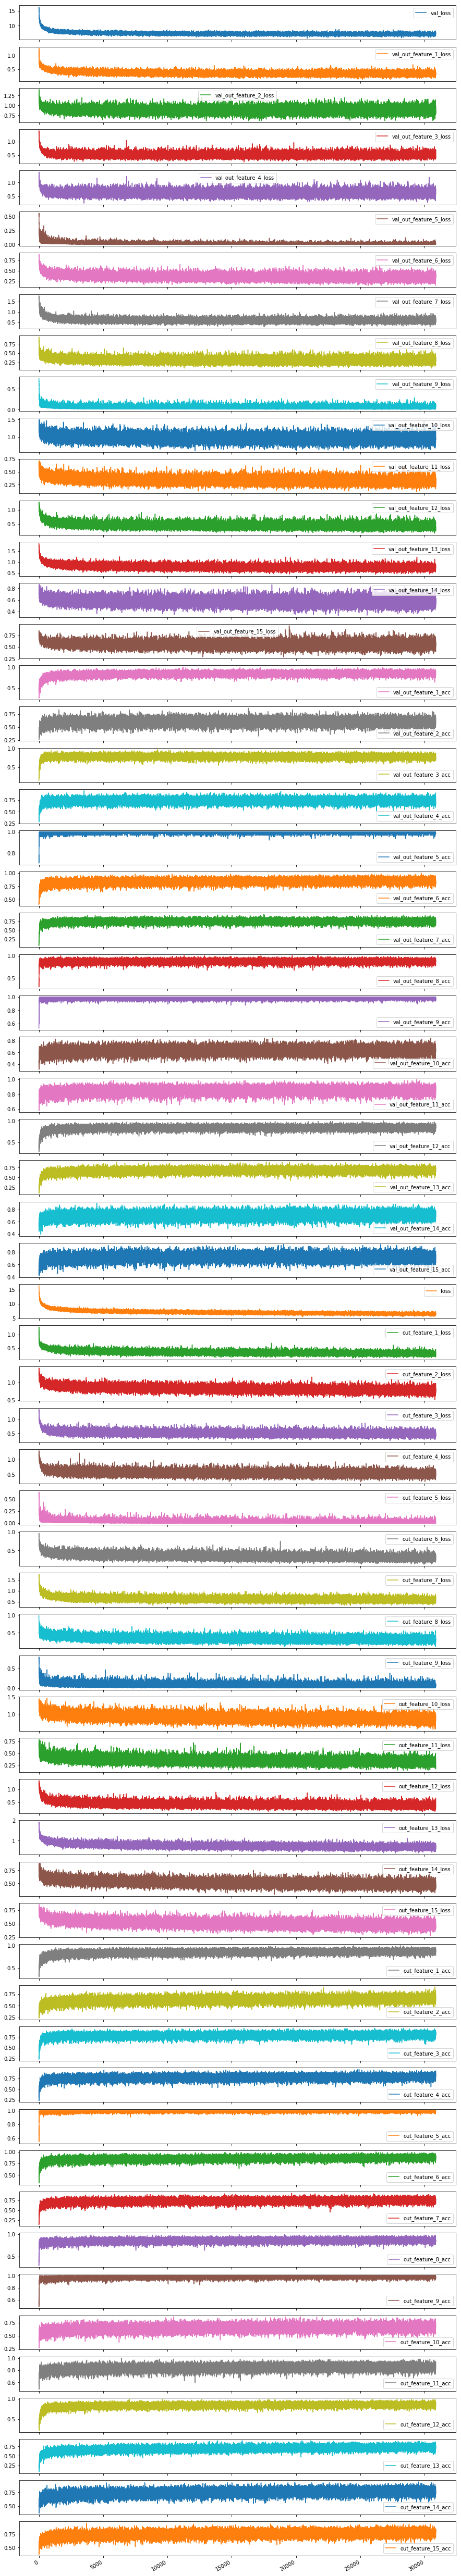

In [28]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<6.31]

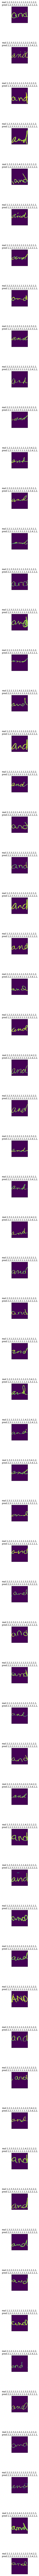

In [29]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('weights/15-Multitask-FrozenEncoder-seen_v1.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [30]:
# print(df_hist.columns)
total = 0
for i in range(1,16):
    print(df_hist.iloc[18351]['val_out_feature_{0}_acc'.format(i)].max())
    total+=df_hist.iloc[18351]['val_out_feature_{0}_acc'.format(i)]
print('total_acc:',total/15)
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

0.8125
0.609375
0.734375
0.71875
1.0
0.796875
0.65625
0.890625
0.984375
0.6875
0.84375
0.796875
0.609375
0.703125
0.734375
total_acc: 0.771875


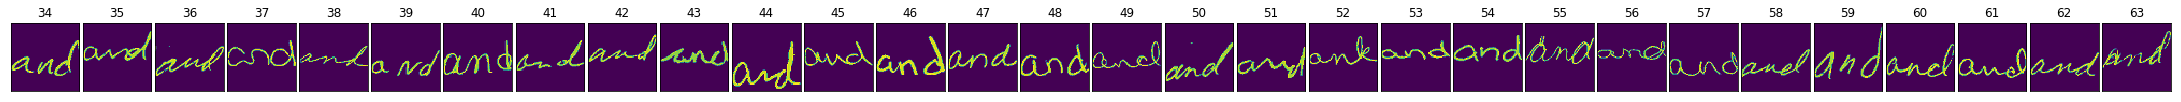

In [31]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [32]:
# plt.imshow(inputs[10].reshape((64,64)))
# plt.subplots_adjust(hspace = 0.1)
# for i in range(1,9):
#     visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
#     vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
#     vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
#     f,ax = plt.subplots(8,8)
#     f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
#     f.set_size_inches(15,15)
#     f.suptitle('dense_layer_'+str(i), fontsize=15)
# #     f.subplots_adjust(hspace = 0.1)
# #     plt.title('dense_layer_'+str(i))
#     print(vis_out.shape)
#     for r in range(8):
#         for c in range (8):
#             ax[r,c].imshow(vis_out[c+r*8])
#             ax[r,c].axis('off')
# #     break

In [33]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

# Evaluation

In [34]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

NameError: name 'cosine_similarity' is not defined

In [ ]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('dense_layer_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('encoded').output)

In [ ]:
test_g = datagen(len(val_images)*5,val_path,val_images, vshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [ ]:
feature_wise_pred_y=human_features_eval.predict(testx)
latent_pred_y=human_features_encoder.predict(testx)

In [ ]:
feature_wise_pred_y=np.array(feature_wise_pred_y)
latent_pred_y=np.array(latent_pred_y).reshape((-1,512))

In [ ]:
latent_pred_y.shape,feature_wise_pred_y.shape

In [ ]:
ids = testy[0].reshape(-1,1)
imagenames = testy[1].reshape(-1,1)
data=[]
for i in range(len(testx)):
    data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(10)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [ ]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [ ]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.8
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 20
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [ ]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
df_cos_dist_out.head()

In [ ]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

In [ ]:
csv_data.var()